In [20]:
import pandas as pd
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

## Data Preprocessing

In [2]:
# Importing data
# import data
df = pd.read_csv('df_post_eda.csv')
df.head(2)

,Date,MMWR_week,Location,Distributed,Distributed_Janssen,Distributed_Moderna,Distributed_Pfizer,Distributed_Unk_Manuf,Dist_Per_100K,Distributed_Per_100k_5Plus,...,day_of_week,quarter,dayofyear,dayofmonth,weekofyear,season,holidays,holiday_season,vax_announcement,Additional_Doses_Vax_Pct_1_w_lag
0,2023-05-10,19,NE,5481710,152400,1647380,2905630,0,283379,303944.0,...,Wednesday,2,130,10,19,spring,Normal day,False,False,NaN
1,2023-05-10,19,LA,10282120,330500,3807980,5164550,0,221178,236516.0,...,Wednesday,2,130,10,19,spring,Normal day,False,False,55.8


In [3]:
# Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Make sure the data is sorted by Date
df.sort_values('Date', inplace=True)

# Set 'Date' column to index
df.set_index('Date', inplace=True)

In [4]:
# Group df by date
grouped = df.groupby(df.index).mean()
grouped.head()

,MMWR_week,Distributed,Distributed_Janssen,Distributed_Moderna,Distributed_Pfizer,Distributed_Unk_Manuf,Dist_Per_100K,Distributed_Per_100k_5Plus,Distributed_Per_100k_12Plus,Distributed_Per_100k_18Plus,...,Additional_Doses_Unk_Manuf,month,year,quarter,dayofyear,dayofmonth,weekofyear,holiday_season,vax_announcement,Additional_Doses_Vax_Pct_1_w_lag
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-03,44.0,1.663188e+07,818798.4375,6.480709e+06,9.242425e+06,89947.65625,146818.062500,152028.625000,167037.250000,186038.703125,...,249.390625,11.0,2021.0,4.0,307.0,3.0,44.0,0.0,0.0,10.367188
2021-11-10,45.0,1.714537e+07,836476.5625,6.642025e+06,9.666864e+06,0.00000,151460.531250,156997.781250,173446.453125,194278.203125,...,243.156250,11.0,2021.0,4.0,314.0,10.0,45.0,1.0,0.0,13.204688
2021-11-17,46.0,1.768302e+07,853621.8750,6.841471e+06,9.987929e+06,0.00000,155606.890625,161287.484375,178169.640625,199577.812500,...,272.468750,11.0,2021.0,4.0,321.0,17.0,46.0,0.0,1.0,15.907813
2021-11-24,47.0,1.811490e+07,874050.0000,6.908257e+06,1.033259e+07,0.00000,159194.265625,165021.546875,182287.593750,204172.562500,...,310.875000,11.0,2021.0,4.0,328.0,24.0,47.0,1.0,0.0,18.985937
2021-12-01,48.0,1.822699e+07,882312.5000,6.931029e+06,1.041364e+07,0.00000,160201.109375,166069.109375,183443.203125,205459.156250,...,332.187500,12.0,2021.0,4.0,335.0,1.0,48.0,0.0,1.0,20.384375


In [5]:
# Predictive variable
pred_var = 'Additional_Doses_Vax_Pct'

In [6]:
# Dropping Unncessary Columns

# Prophet model takes these dates and adds in these seasonalities
columns_to_drop = ['MMWR_week', 'month', 'year', 'quarter', 'dayofyear', 'dayofmonth', 'weekofyear', 'Additional_Doses_Vax_Pct_1_w_lag']

# Drop the specified columns
df = grouped.drop(columns=columns_to_drop)

In [7]:
df.columns

Index(['Distributed', 'Distributed_Janssen', 'Distributed_Moderna',
       'Distributed_Pfizer', 'Distributed_Unk_Manuf', 'Dist_Per_100K',
       'Distributed_Per_100k_5Plus', 'Distributed_Per_100k_12Plus',
       'Distributed_Per_100k_18Plus', 'Distributed_Per_100k_65Plus',
       'Administered', 'Administered_5Plus', 'Administered_12Plus',
       'Administered_18Plus', 'Administered_65Plus', 'Administered_Janssen',
       'Administered_Moderna', 'Administered_Pfizer', 'Administered_Unk_Manuf',
       'Admin_Per_100K', 'Admin_Per_100k_5Plus', 'Admin_Per_100k_12Plus',
       'Admin_Per_100k_18Plus', 'Admin_Per_100k_65Plus', 'Recip_Administered',
       'Administered_Dose1_Pop_Pct', 'Administered_Dose1_Recip_5PlusPop_Pct',
       'Administered_Dose1_Recip_12PlusPop_Pct',
       'Administered_Dose1_Recip_18PlusPop_Pct',
       'Administered_Dose1_Recip_65PlusPop_Pct', 'Series_Complete_Pop_Pct',
       'Series_Complete_5PlusPop_Pct', 'Series_Complete_12PlusPop_Pct',
       'Series_Complet

In [8]:
# Scale data -> some % columns, some raw number columns
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
df_scaled.head(3)

,Distributed,Distributed_Janssen,Distributed_Moderna,Distributed_Pfizer,Distributed_Unk_Manuf,Dist_Per_100K,Distributed_Per_100k_5Plus,Distributed_Per_100k_12Plus,Distributed_Per_100k_18Plus,Distributed_Per_100k_65Plus,...,Additional_Doses_Vax_Pct,Additional_Doses_18Plus_Vax_Pct,Additional_Doses_50Plus_Vax_Pct,Additional_Doses_65Plus_Vax_Pct,Additional_Doses_Moderna,Additional_Doses_Pfizer,Additional_Doses_Janssen,Additional_Doses_Unk_Manuf,holiday_season,vax_announcement
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-03,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002677,0.0,0.0
2021-11-10,0.035505,0.083761,0.034580,0.045848,0.0,0.035776,0.035678,0.041371,0.048715,0.137336,...,0.070026,0.070491,0.089551,0.118364,0.075766,0.039331,0.085305,0.000000,1.0,0.0
2021-11-17,0.072682,0.164997,0.077333,0.080529,0.0,0.067730,0.066477,0.071859,0.080049,0.163318,...,0.135949,0.136967,0.169501,0.216584,0.147337,0.080079,0.164947,0.012586,0.0,1.0


# Single Prophet - Scaled Data

In [9]:
# subsetting to Date and Predictor -> making Prophet dataframe
df_single = df_scaled.groupby(df_scaled.index)[pred_var].mean()
df_single = pd.DataFrame(df_single)
df_single.reset_index(level=0, inplace=True)
df_single = df_single.rename(columns={'Date': 'ds', 'Additional_Doses_Vax_Pct': 'y'})
df_single.head()

,ds,y
0,2021-11-03,0.000000
1,2021-11-10,0.070026
2,2021-11-17,0.135949
3,2021-11-24,0.204748
4,2021-12-01,0.254180


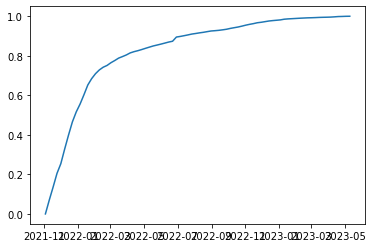

In [10]:
plt.plot(df_single['ds'], df_single['y'],)

In [11]:
# Splitting data into Train and Test -> test is from start of 2023 and beyond

split_date = '2023-01-03'

train = df_single[df_single['ds'] < split_date]
test = df_single[df_single['ds'] >= split_date]

In [12]:
print(train.shape, test.shape)

(61, 2) (19, 2)


In [13]:
train.tail(1)

,ds,y
60,2022-12-28,0.979751


In [14]:
test.head(1)

,ds,y
61,2023-01-04,0.981554


### Baseline Prophet Model

In [25]:
# Create a Prophet model
model = Prophet()

# Fit the model on the training data
model.fit(train)

# Make predictions on the training set
train_predictions = model.predict(train)

# Make predictions on the test set
test_predictions = model.predict(test)

# Extract the actual and predicted values
train_actual = train['y']
test_actual = test['y']

train_pred = train_predictions['yhat']
test_pred = test_predictions['yhat']

# Calculate RMSE for training set
train_rmse = np.sqrt(mean_squared_error(train_actual, train_pred))

# Calculate RMSE for test set
test_rmse = np.sqrt(mean_squared_error(test_actual, test_pred))

print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")

16:53:55 - cmdstanpy - INFO - Chain [1] start processing
16:53:56 - cmdstanpy - INFO - Chain [1] done processing


Training RMSE: 0.0028713622193601443
Testing RMSE: 0.029572437335438392


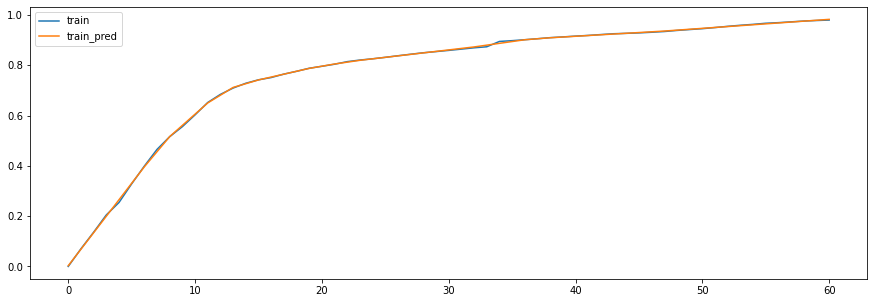

In [26]:
# Plot the training predictions
pd.concat([train['y'], train_predictions['yhat']], axis=1).plot(figsize=(15,5))
plt.legend(['train', 'train_pred'])

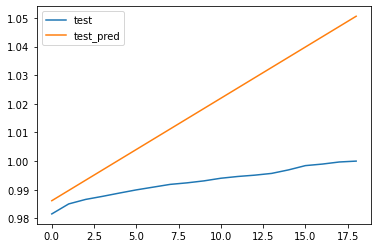

In [27]:
pd.concat([test.reset_index()['y'],test_predictions['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])

### Train RMSE: 0.0028713622193601443, Test RMSE: 0.029572437335438392

### Prophet Model - Logistic Growth

In [34]:
train['cap'] = 1
test['cap'] = 1

# Create a Prophet model
model = Prophet(growth='logistic')

# Fit the model on the training data
model.fit(train)

# Make predictions on the training set
train_predictions = model.predict(train)

# Make predictions on the test set
test_predictions = model.predict(test)

# Extract the actual and predicted values
train_actual = train['y']
test_actual = test['y']

train_pred = train_predictions['yhat']
test_pred = test_predictions['yhat']

# Calculate RMSE for training set
train_rmse = np.sqrt(mean_squared_error(train_actual, train_pred))

# Calculate RMSE for test set
test_rmse = np.sqrt(mean_squared_error(test_actual, test_pred))

print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")

/var/folders/rz/ms4bc2dx43n8vtgvzg9n9tyr0000gn/T/ipykernel_7531/3166486465.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['cap'] = 1
/var/folders/rz/ms4bc2dx43n8vtgvzg9n9tyr0000gn/T/ipykernel_7531/3166486465.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['cap'] = 1
19:29:46 - cmdstanpy - INFO - Chain [1] start processing
19:29:46 - cmdstanpy - INFO - Chain [1] done processing


Training RMSE: 0.24794113726182446
Testing RMSE: 0.24414838647504167


In [35]:
## Logistic Growth doesn't seem to be making RMSE better -> insufficient data, etc.

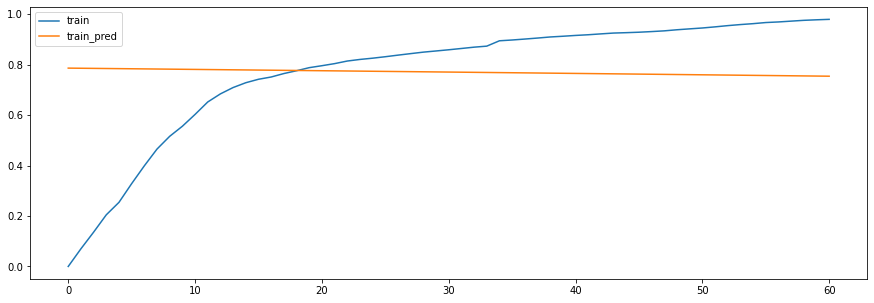

In [37]:
# Plot the training predictions
pd.concat([train['y'], train_predictions['yhat']], axis=1).plot(figsize=(15,5))
plt.legend(['train', 'train_pred'])

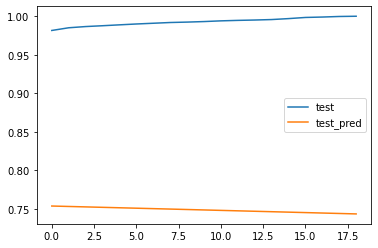

In [36]:
pd.concat([test.reset_index()['y'],test_predictions['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])

#### Single Prophet - Checking seasonality_mode

In [38]:
# Create a Prophet model
model = Prophet(seasonality_mode='multiplicative')

# Fit the model on the training data
model.fit(train)

# Make predictions on the training set
train_predictions = model.predict(train)

# Make predictions on the test set
test_predictions = model.predict(test)

# Extract the actual and predicted values
train_actual = train['y']
test_actual = test['y']

train_pred = train_predictions['yhat']
test_pred = test_predictions['yhat']

# Calculate RMSE for training set
train_rmse = np.sqrt(mean_squared_error(train_actual, train_pred))

# Calculate RMSE for test set
test_rmse = np.sqrt(mean_squared_error(test_actual, test_pred))

print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")

19:30:23 - cmdstanpy - INFO - Chain [1] start processing
19:30:24 - cmdstanpy - INFO - Chain [1] done processing


Training RMSE: 0.0028713622193601443
Testing RMSE: 0.029572437335438392


#### Single Prophet - Adding Holidays

In [18]:
# Create a Prophet model
model = Prophet()
model.add_country_holidays(country_name='US')

# Fit the model on the training data
model.fit(train)

# Make predictions on the training set
train_predictions = model.predict(train)

# Make predictions on the test set
test_predictions = model.predict(test)

# Extract the actual and predicted values
train_actual = train['y']
test_actual = test['y']

train_pred = train_predictions['yhat']
test_pred = test_predictions['yhat']

# Calculate RMSE for training set
train_rmse = np.sqrt(mean_squared_error(train_actual, train_pred))

# Calculate RMSE for test set
test_rmse = np.sqrt(mean_squared_error(test_actual, test_pred))

print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")

17:07:14 - cmdstanpy - INFO - Chain [1] start processing
17:07:14 - cmdstanpy - INFO - Chain [1] done processing


Training RMSE: 0.0028713622179383563
Testing RMSE: 0.029572437567866667


In [19]:
# Doing seasonality = multiplicative and adding holidays to model didn't change model at all

### Tuning Single Prophet Model - Tuning Cross Validation first

In [22]:
# not randomized, iterate through entire grid

from sklearn.model_selection import ParameterSampler
from sklearn.model_selection import ParameterGrid

param_grid = {
    'initial': list(range(49, 210, 7)),  #1-25 weeks
    'period': [7, 14] ,  
    'horizon': [7, 14]  #1-25 weeks
}

all_params = list(ParameterGrid(param_grid))

best_rmse = float('inf')
best_params = None

for params in all_params:
    model = Prophet().fit(train)
    horizon = f'{params["horizon"]} days'
    initial = f'{params["initial"]} days'
    period = f'{params["period"]} days'
    
    df_cv = cross_validation(model, horizon=horizon, initial=initial, period=period)

    metrics = performance_metrics(df_cv)
    rmse = metrics['rmse'].mean()
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)


17:23:11 - cmdstanpy - INFO - Chain [1] start processing
17:23:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/53 [00:00<?, ?it/s]

17:23:12 - cmdstanpy - INFO - Chain [1] start processing
17:23:12 - cmdstanpy - INFO - Chain [1] done processing
17:23:12 - cmdstanpy - INFO - Chain [1] start processing
17:23:12 - cmdstanpy - INFO - Chain [1] done processing
17:23:12 - cmdstanpy - INFO - Chain [1] start processing
17:23:12 - cmdstanpy - INFO - Chain [1] done processing
17:23:12 - cmdstanpy - INFO - Chain [1] start processing
17:23:12 - cmdstanpy - INFO - Chain [1] done processing
17:23:12 - cmdstanpy - INFO - Chain [1] start processing
17:23:12 - cmdstanpy - INFO - Chain [1] done processing
17:23:12 - cmdstanpy - INFO - Chain [1] start processing
17:23:12 - cmdstanpy - INFO - Chain [1] done processing
17:23:12 - cmdstanpy - INFO - Chain [1] start processing
17:23:12 - cmdstanpy - INFO - Chain [1] done processing
17:23:13 - cmdstanpy - INFO - Chain [1] start processing
17:23:13 - cmdstanpy - INFO - Chain [1] done processing
17:23:13 - cmdstanpy - INFO - Chain [1] start processing
17:23:13 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/27 [00:00<?, ?it/s]

17:23:22 - cmdstanpy - INFO - Chain [1] start processing
17:23:22 - cmdstanpy - INFO - Chain [1] done processing
17:23:22 - cmdstanpy - INFO - Chain [1] start processing
17:23:22 - cmdstanpy - INFO - Chain [1] done processing
17:23:22 - cmdstanpy - INFO - Chain [1] start processing
17:23:22 - cmdstanpy - INFO - Chain [1] done processing
17:23:22 - cmdstanpy - INFO - Chain [1] start processing
17:23:22 - cmdstanpy - INFO - Chain [1] done processing
17:23:22 - cmdstanpy - INFO - Chain [1] start processing
17:23:22 - cmdstanpy - INFO - Chain [1] done processing
17:23:22 - cmdstanpy - INFO - Chain [1] start processing
17:23:23 - cmdstanpy - INFO - Chain [1] done processing
17:23:23 - cmdstanpy - INFO - Chain [1] start processing
17:23:23 - cmdstanpy - INFO - Chain [1] done processing
17:23:23 - cmdstanpy - INFO - Chain [1] start processing
17:23:23 - cmdstanpy - INFO - Chain [1] done processing
17:23:23 - cmdstanpy - INFO - Chain [1] start processing
17:23:23 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/52 [00:00<?, ?it/s]

17:23:27 - cmdstanpy - INFO - Chain [1] start processing
17:23:27 - cmdstanpy - INFO - Chain [1] done processing
17:23:27 - cmdstanpy - INFO - Chain [1] start processing
17:23:27 - cmdstanpy - INFO - Chain [1] done processing
17:23:27 - cmdstanpy - INFO - Chain [1] start processing
17:23:27 - cmdstanpy - INFO - Chain [1] done processing
17:23:28 - cmdstanpy - INFO - Chain [1] start processing
17:23:28 - cmdstanpy - INFO - Chain [1] done processing
17:23:28 - cmdstanpy - INFO - Chain [1] start processing
17:23:28 - cmdstanpy - INFO - Chain [1] done processing
17:23:28 - cmdstanpy - INFO - Chain [1] start processing
17:23:28 - cmdstanpy - INFO - Chain [1] done processing
17:23:28 - cmdstanpy - INFO - Chain [1] start processing
17:23:28 - cmdstanpy - INFO - Chain [1] done processing
17:23:28 - cmdstanpy - INFO - Chain [1] start processing
17:23:28 - cmdstanpy - INFO - Chain [1] done processing
17:23:28 - cmdstanpy - INFO - Chain [1] start processing
17:23:28 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/26 [00:00<?, ?it/s]

17:23:37 - cmdstanpy - INFO - Chain [1] start processing
17:23:37 - cmdstanpy - INFO - Chain [1] done processing
17:23:37 - cmdstanpy - INFO - Chain [1] start processing
17:23:37 - cmdstanpy - INFO - Chain [1] done processing
17:23:37 - cmdstanpy - INFO - Chain [1] start processing
17:23:38 - cmdstanpy - INFO - Chain [1] done processing
17:23:38 - cmdstanpy - INFO - Chain [1] start processing
17:23:38 - cmdstanpy - INFO - Chain [1] done processing
17:23:38 - cmdstanpy - INFO - Chain [1] start processing
17:23:38 - cmdstanpy - INFO - Chain [1] done processing
17:23:38 - cmdstanpy - INFO - Chain [1] start processing
17:23:38 - cmdstanpy - INFO - Chain [1] done processing
17:23:38 - cmdstanpy - INFO - Chain [1] start processing
17:23:38 - cmdstanpy - INFO - Chain [1] done processing
17:23:38 - cmdstanpy - INFO - Chain [1] start processing
17:23:38 - cmdstanpy - INFO - Chain [1] done processing
17:23:38 - cmdstanpy - INFO - Chain [1] start processing
17:23:38 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/51 [00:00<?, ?it/s]

17:23:42 - cmdstanpy - INFO - Chain [1] start processing
17:23:43 - cmdstanpy - INFO - Chain [1] done processing
17:23:43 - cmdstanpy - INFO - Chain [1] start processing
17:23:43 - cmdstanpy - INFO - Chain [1] done processing
17:23:43 - cmdstanpy - INFO - Chain [1] start processing
17:23:43 - cmdstanpy - INFO - Chain [1] done processing
17:23:43 - cmdstanpy - INFO - Chain [1] start processing
17:23:43 - cmdstanpy - INFO - Chain [1] done processing
17:23:43 - cmdstanpy - INFO - Chain [1] start processing
17:23:43 - cmdstanpy - INFO - Chain [1] done processing
17:23:43 - cmdstanpy - INFO - Chain [1] start processing
17:23:43 - cmdstanpy - INFO - Chain [1] done processing
17:23:43 - cmdstanpy - INFO - Chain [1] start processing
17:23:43 - cmdstanpy - INFO - Chain [1] done processing
17:23:43 - cmdstanpy - INFO - Chain [1] start processing
17:23:43 - cmdstanpy - INFO - Chain [1] done processing
17:23:43 - cmdstanpy - INFO - Chain [1] start processing
17:23:44 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/26 [00:00<?, ?it/s]

17:23:52 - cmdstanpy - INFO - Chain [1] start processing
17:23:52 - cmdstanpy - INFO - Chain [1] done processing
17:23:53 - cmdstanpy - INFO - Chain [1] start processing
17:23:53 - cmdstanpy - INFO - Chain [1] done processing
17:23:53 - cmdstanpy - INFO - Chain [1] start processing
17:23:53 - cmdstanpy - INFO - Chain [1] done processing
17:23:53 - cmdstanpy - INFO - Chain [1] start processing
17:23:53 - cmdstanpy - INFO - Chain [1] done processing
17:23:53 - cmdstanpy - INFO - Chain [1] start processing
17:23:53 - cmdstanpy - INFO - Chain [1] done processing
17:23:53 - cmdstanpy - INFO - Chain [1] start processing
17:23:53 - cmdstanpy - INFO - Chain [1] done processing
17:23:53 - cmdstanpy - INFO - Chain [1] start processing
17:23:53 - cmdstanpy - INFO - Chain [1] done processing
17:23:53 - cmdstanpy - INFO - Chain [1] start processing
17:23:53 - cmdstanpy - INFO - Chain [1] done processing
17:23:53 - cmdstanpy - INFO - Chain [1] start processing
17:23:53 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/50 [00:00<?, ?it/s]

17:23:58 - cmdstanpy - INFO - Chain [1] start processing
17:23:58 - cmdstanpy - INFO - Chain [1] done processing
17:23:58 - cmdstanpy - INFO - Chain [1] start processing
17:23:58 - cmdstanpy - INFO - Chain [1] done processing
17:23:58 - cmdstanpy - INFO - Chain [1] start processing
17:23:58 - cmdstanpy - INFO - Chain [1] done processing
17:23:58 - cmdstanpy - INFO - Chain [1] start processing
17:23:58 - cmdstanpy - INFO - Chain [1] done processing
17:23:58 - cmdstanpy - INFO - Chain [1] start processing
17:23:58 - cmdstanpy - INFO - Chain [1] done processing
17:23:58 - cmdstanpy - INFO - Chain [1] start processing
17:23:58 - cmdstanpy - INFO - Chain [1] done processing
17:23:58 - cmdstanpy - INFO - Chain [1] start processing
17:23:58 - cmdstanpy - INFO - Chain [1] done processing
17:23:58 - cmdstanpy - INFO - Chain [1] start processing
17:23:59 - cmdstanpy - INFO - Chain [1] done processing
17:23:59 - cmdstanpy - INFO - Chain [1] start processing
17:23:59 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/25 [00:00<?, ?it/s]

17:24:07 - cmdstanpy - INFO - Chain [1] start processing
17:24:07 - cmdstanpy - INFO - Chain [1] done processing
17:24:07 - cmdstanpy - INFO - Chain [1] start processing
17:24:08 - cmdstanpy - INFO - Chain [1] done processing
17:24:08 - cmdstanpy - INFO - Chain [1] start processing
17:24:08 - cmdstanpy - INFO - Chain [1] done processing
17:24:08 - cmdstanpy - INFO - Chain [1] start processing
17:24:08 - cmdstanpy - INFO - Chain [1] done processing
17:24:08 - cmdstanpy - INFO - Chain [1] start processing
17:24:08 - cmdstanpy - INFO - Chain [1] done processing
17:24:08 - cmdstanpy - INFO - Chain [1] start processing
17:24:08 - cmdstanpy - INFO - Chain [1] done processing
17:24:08 - cmdstanpy - INFO - Chain [1] start processing
17:24:08 - cmdstanpy - INFO - Chain [1] done processing
17:24:08 - cmdstanpy - INFO - Chain [1] start processing
17:24:08 - cmdstanpy - INFO - Chain [1] done processing
17:24:08 - cmdstanpy - INFO - Chain [1] start processing
17:24:08 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/49 [00:00<?, ?it/s]

17:24:12 - cmdstanpy - INFO - Chain [1] start processing
17:24:12 - cmdstanpy - INFO - Chain [1] done processing
17:24:12 - cmdstanpy - INFO - Chain [1] start processing
17:24:13 - cmdstanpy - INFO - Chain [1] done processing
17:24:13 - cmdstanpy - INFO - Chain [1] start processing
17:24:13 - cmdstanpy - INFO - Chain [1] done processing
17:24:13 - cmdstanpy - INFO - Chain [1] start processing
17:24:13 - cmdstanpy - INFO - Chain [1] done processing
17:24:13 - cmdstanpy - INFO - Chain [1] start processing
17:24:13 - cmdstanpy - INFO - Chain [1] done processing
17:24:13 - cmdstanpy - INFO - Chain [1] start processing
17:24:13 - cmdstanpy - INFO - Chain [1] done processing
17:24:13 - cmdstanpy - INFO - Chain [1] start processing
17:24:13 - cmdstanpy - INFO - Chain [1] done processing
17:24:13 - cmdstanpy - INFO - Chain [1] start processing
17:24:13 - cmdstanpy - INFO - Chain [1] done processing
17:24:13 - cmdstanpy - INFO - Chain [1] start processing
17:24:13 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/25 [00:00<?, ?it/s]

17:24:22 - cmdstanpy - INFO - Chain [1] start processing
17:24:22 - cmdstanpy - INFO - Chain [1] done processing
17:24:22 - cmdstanpy - INFO - Chain [1] start processing
17:24:22 - cmdstanpy - INFO - Chain [1] done processing
17:24:22 - cmdstanpy - INFO - Chain [1] start processing
17:24:22 - cmdstanpy - INFO - Chain [1] done processing
17:24:22 - cmdstanpy - INFO - Chain [1] start processing
17:24:23 - cmdstanpy - INFO - Chain [1] done processing
17:24:23 - cmdstanpy - INFO - Chain [1] start processing
17:24:23 - cmdstanpy - INFO - Chain [1] done processing
17:24:23 - cmdstanpy - INFO - Chain [1] start processing
17:24:23 - cmdstanpy - INFO - Chain [1] done processing
17:24:23 - cmdstanpy - INFO - Chain [1] start processing
17:24:23 - cmdstanpy - INFO - Chain [1] done processing
17:24:23 - cmdstanpy - INFO - Chain [1] start processing
17:24:23 - cmdstanpy - INFO - Chain [1] done processing
17:24:23 - cmdstanpy - INFO - Chain [1] start processing
17:24:23 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/48 [00:00<?, ?it/s]

17:24:27 - cmdstanpy - INFO - Chain [1] start processing
17:24:27 - cmdstanpy - INFO - Chain [1] done processing
17:24:27 - cmdstanpy - INFO - Chain [1] start processing
17:24:27 - cmdstanpy - INFO - Chain [1] done processing
17:24:27 - cmdstanpy - INFO - Chain [1] start processing
17:24:27 - cmdstanpy - INFO - Chain [1] done processing
17:24:27 - cmdstanpy - INFO - Chain [1] start processing
17:24:28 - cmdstanpy - INFO - Chain [1] done processing
17:24:28 - cmdstanpy - INFO - Chain [1] start processing
17:24:28 - cmdstanpy - INFO - Chain [1] done processing
17:24:28 - cmdstanpy - INFO - Chain [1] start processing
17:24:28 - cmdstanpy - INFO - Chain [1] done processing
17:24:28 - cmdstanpy - INFO - Chain [1] start processing
17:24:28 - cmdstanpy - INFO - Chain [1] done processing
17:24:28 - cmdstanpy - INFO - Chain [1] start processing
17:24:28 - cmdstanpy - INFO - Chain [1] done processing
17:24:28 - cmdstanpy - INFO - Chain [1] start processing
17:24:28 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/24 [00:00<?, ?it/s]

17:24:37 - cmdstanpy - INFO - Chain [1] start processing
17:24:37 - cmdstanpy - INFO - Chain [1] done processing
17:24:37 - cmdstanpy - INFO - Chain [1] start processing
17:24:37 - cmdstanpy - INFO - Chain [1] done processing
17:24:37 - cmdstanpy - INFO - Chain [1] start processing
17:24:37 - cmdstanpy - INFO - Chain [1] done processing
17:24:37 - cmdstanpy - INFO - Chain [1] start processing
17:24:37 - cmdstanpy - INFO - Chain [1] done processing
17:24:37 - cmdstanpy - INFO - Chain [1] start processing
17:24:37 - cmdstanpy - INFO - Chain [1] done processing
17:24:37 - cmdstanpy - INFO - Chain [1] start processing
17:24:37 - cmdstanpy - INFO - Chain [1] done processing
17:24:37 - cmdstanpy - INFO - Chain [1] start processing
17:24:37 - cmdstanpy - INFO - Chain [1] done processing
17:24:37 - cmdstanpy - INFO - Chain [1] start processing
17:24:37 - cmdstanpy - INFO - Chain [1] done processing
17:24:38 - cmdstanpy - INFO - Chain [1] start processing
17:24:38 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/47 [00:00<?, ?it/s]

17:24:41 - cmdstanpy - INFO - Chain [1] start processing
17:24:42 - cmdstanpy - INFO - Chain [1] done processing
17:24:42 - cmdstanpy - INFO - Chain [1] start processing
17:24:42 - cmdstanpy - INFO - Chain [1] done processing
17:24:42 - cmdstanpy - INFO - Chain [1] start processing
17:24:42 - cmdstanpy - INFO - Chain [1] done processing
17:24:42 - cmdstanpy - INFO - Chain [1] start processing
17:24:42 - cmdstanpy - INFO - Chain [1] done processing
17:24:42 - cmdstanpy - INFO - Chain [1] start processing
17:24:42 - cmdstanpy - INFO - Chain [1] done processing
17:24:42 - cmdstanpy - INFO - Chain [1] start processing
17:24:42 - cmdstanpy - INFO - Chain [1] done processing
17:24:42 - cmdstanpy - INFO - Chain [1] start processing
17:24:42 - cmdstanpy - INFO - Chain [1] done processing
17:24:42 - cmdstanpy - INFO - Chain [1] start processing
17:24:42 - cmdstanpy - INFO - Chain [1] done processing
17:24:42 - cmdstanpy - INFO - Chain [1] start processing
17:24:42 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/24 [00:00<?, ?it/s]

17:24:51 - cmdstanpy - INFO - Chain [1] start processing
17:24:51 - cmdstanpy - INFO - Chain [1] done processing
17:24:51 - cmdstanpy - INFO - Chain [1] start processing
17:24:51 - cmdstanpy - INFO - Chain [1] done processing
17:24:51 - cmdstanpy - INFO - Chain [1] start processing
17:24:51 - cmdstanpy - INFO - Chain [1] done processing
17:24:51 - cmdstanpy - INFO - Chain [1] start processing
17:24:51 - cmdstanpy - INFO - Chain [1] done processing
17:24:51 - cmdstanpy - INFO - Chain [1] start processing
17:24:51 - cmdstanpy - INFO - Chain [1] done processing
17:24:51 - cmdstanpy - INFO - Chain [1] start processing
17:24:51 - cmdstanpy - INFO - Chain [1] done processing
17:24:51 - cmdstanpy - INFO - Chain [1] start processing
17:24:52 - cmdstanpy - INFO - Chain [1] done processing
17:24:52 - cmdstanpy - INFO - Chain [1] start processing
17:24:52 - cmdstanpy - INFO - Chain [1] done processing
17:24:52 - cmdstanpy - INFO - Chain [1] start processing
17:24:52 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/46 [00:00<?, ?it/s]

17:24:56 - cmdstanpy - INFO - Chain [1] start processing
17:24:56 - cmdstanpy - INFO - Chain [1] done processing
17:24:56 - cmdstanpy - INFO - Chain [1] start processing
17:24:56 - cmdstanpy - INFO - Chain [1] done processing
17:24:56 - cmdstanpy - INFO - Chain [1] start processing
17:24:56 - cmdstanpy - INFO - Chain [1] done processing
17:24:56 - cmdstanpy - INFO - Chain [1] start processing
17:24:56 - cmdstanpy - INFO - Chain [1] done processing
17:24:56 - cmdstanpy - INFO - Chain [1] start processing
17:24:56 - cmdstanpy - INFO - Chain [1] done processing
17:24:56 - cmdstanpy - INFO - Chain [1] start processing
17:24:56 - cmdstanpy - INFO - Chain [1] done processing
17:24:56 - cmdstanpy - INFO - Chain [1] start processing
17:24:56 - cmdstanpy - INFO - Chain [1] done processing
17:24:56 - cmdstanpy - INFO - Chain [1] start processing
17:24:56 - cmdstanpy - INFO - Chain [1] done processing
17:24:56 - cmdstanpy - INFO - Chain [1] start processing
17:24:57 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/23 [00:00<?, ?it/s]

17:25:05 - cmdstanpy - INFO - Chain [1] start processing
17:25:05 - cmdstanpy - INFO - Chain [1] done processing
17:25:05 - cmdstanpy - INFO - Chain [1] start processing
17:25:05 - cmdstanpy - INFO - Chain [1] done processing
17:25:05 - cmdstanpy - INFO - Chain [1] start processing
17:25:05 - cmdstanpy - INFO - Chain [1] done processing
17:25:05 - cmdstanpy - INFO - Chain [1] start processing
17:25:05 - cmdstanpy - INFO - Chain [1] done processing
17:25:05 - cmdstanpy - INFO - Chain [1] start processing
17:25:05 - cmdstanpy - INFO - Chain [1] done processing
17:25:05 - cmdstanpy - INFO - Chain [1] start processing
17:25:05 - cmdstanpy - INFO - Chain [1] done processing
17:25:05 - cmdstanpy - INFO - Chain [1] start processing
17:25:06 - cmdstanpy - INFO - Chain [1] done processing
17:25:06 - cmdstanpy - INFO - Chain [1] start processing
17:25:06 - cmdstanpy - INFO - Chain [1] done processing
17:25:06 - cmdstanpy - INFO - Chain [1] start processing
17:25:06 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/45 [00:00<?, ?it/s]

17:25:09 - cmdstanpy - INFO - Chain [1] start processing
17:25:10 - cmdstanpy - INFO - Chain [1] done processing
17:25:10 - cmdstanpy - INFO - Chain [1] start processing
17:25:10 - cmdstanpy - INFO - Chain [1] done processing
17:25:10 - cmdstanpy - INFO - Chain [1] start processing
17:25:10 - cmdstanpy - INFO - Chain [1] done processing
17:25:10 - cmdstanpy - INFO - Chain [1] start processing
17:25:10 - cmdstanpy - INFO - Chain [1] done processing
17:25:10 - cmdstanpy - INFO - Chain [1] start processing
17:25:10 - cmdstanpy - INFO - Chain [1] done processing
17:25:10 - cmdstanpy - INFO - Chain [1] start processing
17:25:10 - cmdstanpy - INFO - Chain [1] done processing
17:25:10 - cmdstanpy - INFO - Chain [1] start processing
17:25:10 - cmdstanpy - INFO - Chain [1] done processing
17:25:10 - cmdstanpy - INFO - Chain [1] start processing
17:25:10 - cmdstanpy - INFO - Chain [1] done processing
17:25:10 - cmdstanpy - INFO - Chain [1] start processing
17:25:10 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/23 [00:00<?, ?it/s]

17:25:18 - cmdstanpy - INFO - Chain [1] start processing
17:25:19 - cmdstanpy - INFO - Chain [1] done processing
17:25:19 - cmdstanpy - INFO - Chain [1] start processing
17:25:19 - cmdstanpy - INFO - Chain [1] done processing
17:25:19 - cmdstanpy - INFO - Chain [1] start processing
17:25:19 - cmdstanpy - INFO - Chain [1] done processing
17:25:19 - cmdstanpy - INFO - Chain [1] start processing
17:25:19 - cmdstanpy - INFO - Chain [1] done processing
17:25:19 - cmdstanpy - INFO - Chain [1] start processing
17:25:19 - cmdstanpy - INFO - Chain [1] done processing
17:25:19 - cmdstanpy - INFO - Chain [1] start processing
17:25:19 - cmdstanpy - INFO - Chain [1] done processing
17:25:19 - cmdstanpy - INFO - Chain [1] start processing
17:25:19 - cmdstanpy - INFO - Chain [1] done processing
17:25:19 - cmdstanpy - INFO - Chain [1] start processing
17:25:19 - cmdstanpy - INFO - Chain [1] done processing
17:25:19 - cmdstanpy - INFO - Chain [1] start processing
17:25:20 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/44 [00:00<?, ?it/s]

17:25:23 - cmdstanpy - INFO - Chain [1] start processing
17:25:23 - cmdstanpy - INFO - Chain [1] done processing
17:25:23 - cmdstanpy - INFO - Chain [1] start processing
17:25:23 - cmdstanpy - INFO - Chain [1] done processing
17:25:23 - cmdstanpy - INFO - Chain [1] start processing
17:25:24 - cmdstanpy - INFO - Chain [1] done processing
17:25:24 - cmdstanpy - INFO - Chain [1] start processing
17:25:24 - cmdstanpy - INFO - Chain [1] done processing
17:25:24 - cmdstanpy - INFO - Chain [1] start processing
17:25:24 - cmdstanpy - INFO - Chain [1] done processing
17:25:24 - cmdstanpy - INFO - Chain [1] start processing
17:25:24 - cmdstanpy - INFO - Chain [1] done processing
17:25:24 - cmdstanpy - INFO - Chain [1] start processing
17:25:24 - cmdstanpy - INFO - Chain [1] done processing
17:25:24 - cmdstanpy - INFO - Chain [1] start processing
17:25:24 - cmdstanpy - INFO - Chain [1] done processing
17:25:24 - cmdstanpy - INFO - Chain [1] start processing
17:25:24 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/22 [00:00<?, ?it/s]

17:25:32 - cmdstanpy - INFO - Chain [1] start processing
17:25:32 - cmdstanpy - INFO - Chain [1] done processing
17:25:32 - cmdstanpy - INFO - Chain [1] start processing
17:25:32 - cmdstanpy - INFO - Chain [1] done processing
17:25:32 - cmdstanpy - INFO - Chain [1] start processing
17:25:33 - cmdstanpy - INFO - Chain [1] done processing
17:25:33 - cmdstanpy - INFO - Chain [1] start processing
17:25:33 - cmdstanpy - INFO - Chain [1] done processing
17:25:33 - cmdstanpy - INFO - Chain [1] start processing
17:25:33 - cmdstanpy - INFO - Chain [1] done processing
17:25:33 - cmdstanpy - INFO - Chain [1] start processing
17:25:33 - cmdstanpy - INFO - Chain [1] done processing
17:25:33 - cmdstanpy - INFO - Chain [1] start processing
17:25:33 - cmdstanpy - INFO - Chain [1] done processing
17:25:33 - cmdstanpy - INFO - Chain [1] start processing
17:25:33 - cmdstanpy - INFO - Chain [1] done processing
17:25:33 - cmdstanpy - INFO - Chain [1] start processing
17:25:33 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/43 [00:00<?, ?it/s]

17:25:37 - cmdstanpy - INFO - Chain [1] start processing
17:25:37 - cmdstanpy - INFO - Chain [1] done processing
17:25:37 - cmdstanpy - INFO - Chain [1] start processing
17:25:37 - cmdstanpy - INFO - Chain [1] done processing
17:25:37 - cmdstanpy - INFO - Chain [1] start processing
17:25:37 - cmdstanpy - INFO - Chain [1] done processing
17:25:37 - cmdstanpy - INFO - Chain [1] start processing
17:25:37 - cmdstanpy - INFO - Chain [1] done processing
17:25:37 - cmdstanpy - INFO - Chain [1] start processing
17:25:37 - cmdstanpy - INFO - Chain [1] done processing
17:25:37 - cmdstanpy - INFO - Chain [1] start processing
17:25:38 - cmdstanpy - INFO - Chain [1] done processing
17:25:38 - cmdstanpy - INFO - Chain [1] start processing
17:25:38 - cmdstanpy - INFO - Chain [1] done processing
17:25:38 - cmdstanpy - INFO - Chain [1] start processing
17:25:38 - cmdstanpy - INFO - Chain [1] done processing
17:25:38 - cmdstanpy - INFO - Chain [1] start processing
17:25:38 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/22 [00:00<?, ?it/s]

17:25:46 - cmdstanpy - INFO - Chain [1] start processing
17:25:46 - cmdstanpy - INFO - Chain [1] done processing
17:25:46 - cmdstanpy - INFO - Chain [1] start processing
17:25:46 - cmdstanpy - INFO - Chain [1] done processing
17:25:46 - cmdstanpy - INFO - Chain [1] start processing
17:25:46 - cmdstanpy - INFO - Chain [1] done processing
17:25:46 - cmdstanpy - INFO - Chain [1] start processing
17:25:46 - cmdstanpy - INFO - Chain [1] done processing
17:25:46 - cmdstanpy - INFO - Chain [1] start processing
17:25:46 - cmdstanpy - INFO - Chain [1] done processing
17:25:46 - cmdstanpy - INFO - Chain [1] start processing
17:25:47 - cmdstanpy - INFO - Chain [1] done processing
17:25:47 - cmdstanpy - INFO - Chain [1] start processing
17:25:47 - cmdstanpy - INFO - Chain [1] done processing
17:25:47 - cmdstanpy - INFO - Chain [1] start processing
17:25:47 - cmdstanpy - INFO - Chain [1] done processing
17:25:47 - cmdstanpy - INFO - Chain [1] start processing
17:25:47 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/42 [00:00<?, ?it/s]

17:25:50 - cmdstanpy - INFO - Chain [1] start processing
17:25:51 - cmdstanpy - INFO - Chain [1] done processing
17:25:51 - cmdstanpy - INFO - Chain [1] start processing
17:25:51 - cmdstanpy - INFO - Chain [1] done processing
17:25:51 - cmdstanpy - INFO - Chain [1] start processing
17:25:51 - cmdstanpy - INFO - Chain [1] done processing
17:25:51 - cmdstanpy - INFO - Chain [1] start processing
17:25:51 - cmdstanpy - INFO - Chain [1] done processing
17:25:51 - cmdstanpy - INFO - Chain [1] start processing
17:25:51 - cmdstanpy - INFO - Chain [1] done processing
17:25:51 - cmdstanpy - INFO - Chain [1] start processing
17:25:51 - cmdstanpy - INFO - Chain [1] done processing
17:25:51 - cmdstanpy - INFO - Chain [1] start processing
17:25:51 - cmdstanpy - INFO - Chain [1] done processing
17:25:51 - cmdstanpy - INFO - Chain [1] start processing
17:25:51 - cmdstanpy - INFO - Chain [1] done processing
17:25:51 - cmdstanpy - INFO - Chain [1] start processing
17:25:51 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/21 [00:00<?, ?it/s]

17:25:59 - cmdstanpy - INFO - Chain [1] start processing
17:25:59 - cmdstanpy - INFO - Chain [1] done processing
17:25:59 - cmdstanpy - INFO - Chain [1] start processing
17:25:59 - cmdstanpy - INFO - Chain [1] done processing
17:25:59 - cmdstanpy - INFO - Chain [1] start processing
17:25:59 - cmdstanpy - INFO - Chain [1] done processing
17:26:00 - cmdstanpy - INFO - Chain [1] start processing
17:26:00 - cmdstanpy - INFO - Chain [1] done processing
17:26:00 - cmdstanpy - INFO - Chain [1] start processing
17:26:00 - cmdstanpy - INFO - Chain [1] done processing
17:26:00 - cmdstanpy - INFO - Chain [1] start processing
17:26:00 - cmdstanpy - INFO - Chain [1] done processing
17:26:00 - cmdstanpy - INFO - Chain [1] start processing
17:26:00 - cmdstanpy - INFO - Chain [1] done processing
17:26:00 - cmdstanpy - INFO - Chain [1] start processing
17:26:00 - cmdstanpy - INFO - Chain [1] done processing
17:26:00 - cmdstanpy - INFO - Chain [1] start processing
17:26:00 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/41 [00:00<?, ?it/s]

17:26:04 - cmdstanpy - INFO - Chain [1] start processing
17:26:04 - cmdstanpy - INFO - Chain [1] done processing
17:26:04 - cmdstanpy - INFO - Chain [1] start processing
17:26:04 - cmdstanpy - INFO - Chain [1] done processing
17:26:04 - cmdstanpy - INFO - Chain [1] start processing
17:26:04 - cmdstanpy - INFO - Chain [1] done processing
17:26:04 - cmdstanpy - INFO - Chain [1] start processing
17:26:04 - cmdstanpy - INFO - Chain [1] done processing
17:26:04 - cmdstanpy - INFO - Chain [1] start processing
17:26:04 - cmdstanpy - INFO - Chain [1] done processing
17:26:04 - cmdstanpy - INFO - Chain [1] start processing
17:26:04 - cmdstanpy - INFO - Chain [1] done processing
17:26:04 - cmdstanpy - INFO - Chain [1] start processing
17:26:04 - cmdstanpy - INFO - Chain [1] done processing
17:26:04 - cmdstanpy - INFO - Chain [1] start processing
17:26:05 - cmdstanpy - INFO - Chain [1] done processing
17:26:05 - cmdstanpy - INFO - Chain [1] start processing
17:26:05 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/21 [00:00<?, ?it/s]

17:26:12 - cmdstanpy - INFO - Chain [1] start processing
17:26:12 - cmdstanpy - INFO - Chain [1] done processing
17:26:12 - cmdstanpy - INFO - Chain [1] start processing
17:26:12 - cmdstanpy - INFO - Chain [1] done processing
17:26:12 - cmdstanpy - INFO - Chain [1] start processing
17:26:13 - cmdstanpy - INFO - Chain [1] done processing
17:26:13 - cmdstanpy - INFO - Chain [1] start processing
17:26:13 - cmdstanpy - INFO - Chain [1] done processing
17:26:13 - cmdstanpy - INFO - Chain [1] start processing
17:26:13 - cmdstanpy - INFO - Chain [1] done processing
17:26:13 - cmdstanpy - INFO - Chain [1] start processing
17:26:13 - cmdstanpy - INFO - Chain [1] done processing
17:26:13 - cmdstanpy - INFO - Chain [1] start processing
17:26:13 - cmdstanpy - INFO - Chain [1] done processing
17:26:13 - cmdstanpy - INFO - Chain [1] start processing
17:26:13 - cmdstanpy - INFO - Chain [1] done processing
17:26:13 - cmdstanpy - INFO - Chain [1] start processing
17:26:13 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/40 [00:00<?, ?it/s]

17:26:17 - cmdstanpy - INFO - Chain [1] start processing
17:26:17 - cmdstanpy - INFO - Chain [1] done processing
17:26:17 - cmdstanpy - INFO - Chain [1] start processing
17:26:17 - cmdstanpy - INFO - Chain [1] done processing
17:26:17 - cmdstanpy - INFO - Chain [1] start processing
17:26:17 - cmdstanpy - INFO - Chain [1] done processing
17:26:17 - cmdstanpy - INFO - Chain [1] start processing
17:26:17 - cmdstanpy - INFO - Chain [1] done processing
17:26:17 - cmdstanpy - INFO - Chain [1] start processing
17:26:17 - cmdstanpy - INFO - Chain [1] done processing
17:26:17 - cmdstanpy - INFO - Chain [1] start processing
17:26:17 - cmdstanpy - INFO - Chain [1] done processing
17:26:17 - cmdstanpy - INFO - Chain [1] start processing
17:26:18 - cmdstanpy - INFO - Chain [1] done processing
17:26:18 - cmdstanpy - INFO - Chain [1] start processing
17:26:18 - cmdstanpy - INFO - Chain [1] done processing
17:26:18 - cmdstanpy - INFO - Chain [1] start processing
17:26:18 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/20 [00:00<?, ?it/s]

17:26:25 - cmdstanpy - INFO - Chain [1] start processing
17:26:25 - cmdstanpy - INFO - Chain [1] done processing
17:26:25 - cmdstanpy - INFO - Chain [1] start processing
17:26:25 - cmdstanpy - INFO - Chain [1] done processing
17:26:25 - cmdstanpy - INFO - Chain [1] start processing
17:26:26 - cmdstanpy - INFO - Chain [1] done processing
17:26:26 - cmdstanpy - INFO - Chain [1] start processing
17:26:26 - cmdstanpy - INFO - Chain [1] done processing
17:26:26 - cmdstanpy - INFO - Chain [1] start processing
17:26:26 - cmdstanpy - INFO - Chain [1] done processing
17:26:26 - cmdstanpy - INFO - Chain [1] start processing
17:26:26 - cmdstanpy - INFO - Chain [1] done processing
17:26:26 - cmdstanpy - INFO - Chain [1] start processing
17:26:26 - cmdstanpy - INFO - Chain [1] done processing
17:26:26 - cmdstanpy - INFO - Chain [1] start processing
17:26:26 - cmdstanpy - INFO - Chain [1] done processing
17:26:26 - cmdstanpy - INFO - Chain [1] start processing
17:26:26 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/39 [00:00<?, ?it/s]

17:26:30 - cmdstanpy - INFO - Chain [1] start processing
17:26:30 - cmdstanpy - INFO - Chain [1] done processing
17:26:30 - cmdstanpy - INFO - Chain [1] start processing
17:26:30 - cmdstanpy - INFO - Chain [1] done processing
17:26:30 - cmdstanpy - INFO - Chain [1] start processing
17:26:30 - cmdstanpy - INFO - Chain [1] done processing
17:26:30 - cmdstanpy - INFO - Chain [1] start processing
17:26:30 - cmdstanpy - INFO - Chain [1] done processing
17:26:30 - cmdstanpy - INFO - Chain [1] start processing
17:26:30 - cmdstanpy - INFO - Chain [1] done processing
17:26:30 - cmdstanpy - INFO - Chain [1] start processing
17:26:30 - cmdstanpy - INFO - Chain [1] done processing
17:26:30 - cmdstanpy - INFO - Chain [1] start processing
17:26:30 - cmdstanpy - INFO - Chain [1] done processing
17:26:30 - cmdstanpy - INFO - Chain [1] start processing
17:26:31 - cmdstanpy - INFO - Chain [1] done processing
17:26:31 - cmdstanpy - INFO - Chain [1] start processing
17:26:31 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/20 [00:00<?, ?it/s]

17:26:38 - cmdstanpy - INFO - Chain [1] start processing
17:26:38 - cmdstanpy - INFO - Chain [1] done processing
17:26:38 - cmdstanpy - INFO - Chain [1] start processing
17:26:38 - cmdstanpy - INFO - Chain [1] done processing
17:26:38 - cmdstanpy - INFO - Chain [1] start processing
17:26:38 - cmdstanpy - INFO - Chain [1] done processing
17:26:38 - cmdstanpy - INFO - Chain [1] start processing
17:26:38 - cmdstanpy - INFO - Chain [1] done processing
17:26:39 - cmdstanpy - INFO - Chain [1] start processing
17:26:39 - cmdstanpy - INFO - Chain [1] done processing
17:26:39 - cmdstanpy - INFO - Chain [1] start processing
17:26:39 - cmdstanpy - INFO - Chain [1] done processing
17:26:39 - cmdstanpy - INFO - Chain [1] start processing
17:26:39 - cmdstanpy - INFO - Chain [1] done processing
17:26:39 - cmdstanpy - INFO - Chain [1] start processing
17:26:39 - cmdstanpy - INFO - Chain [1] done processing
17:26:39 - cmdstanpy - INFO - Chain [1] start processing
17:26:39 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/38 [00:00<?, ?it/s]

17:26:42 - cmdstanpy - INFO - Chain [1] start processing
17:26:43 - cmdstanpy - INFO - Chain [1] done processing
17:26:43 - cmdstanpy - INFO - Chain [1] start processing
17:26:43 - cmdstanpy - INFO - Chain [1] done processing
17:26:43 - cmdstanpy - INFO - Chain [1] start processing
17:26:43 - cmdstanpy - INFO - Chain [1] done processing
17:26:43 - cmdstanpy - INFO - Chain [1] start processing
17:26:43 - cmdstanpy - INFO - Chain [1] done processing
17:26:43 - cmdstanpy - INFO - Chain [1] start processing
17:26:43 - cmdstanpy - INFO - Chain [1] done processing
17:26:43 - cmdstanpy - INFO - Chain [1] start processing
17:26:43 - cmdstanpy - INFO - Chain [1] done processing
17:26:43 - cmdstanpy - INFO - Chain [1] start processing
17:26:43 - cmdstanpy - INFO - Chain [1] done processing
17:26:43 - cmdstanpy - INFO - Chain [1] start processing
17:26:44 - cmdstanpy - INFO - Chain [1] done processing
17:26:44 - cmdstanpy - INFO - Chain [1] start processing
17:26:44 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/19 [00:00<?, ?it/s]

17:26:51 - cmdstanpy - INFO - Chain [1] start processing
17:26:51 - cmdstanpy - INFO - Chain [1] done processing
17:26:51 - cmdstanpy - INFO - Chain [1] start processing
17:26:51 - cmdstanpy - INFO - Chain [1] done processing
17:26:51 - cmdstanpy - INFO - Chain [1] start processing
17:26:51 - cmdstanpy - INFO - Chain [1] done processing
17:26:51 - cmdstanpy - INFO - Chain [1] start processing
17:26:51 - cmdstanpy - INFO - Chain [1] done processing
17:26:51 - cmdstanpy - INFO - Chain [1] start processing
17:26:51 - cmdstanpy - INFO - Chain [1] done processing
17:26:51 - cmdstanpy - INFO - Chain [1] start processing
17:26:52 - cmdstanpy - INFO - Chain [1] done processing
17:26:52 - cmdstanpy - INFO - Chain [1] start processing
17:26:52 - cmdstanpy - INFO - Chain [1] done processing
17:26:52 - cmdstanpy - INFO - Chain [1] start processing
17:26:52 - cmdstanpy - INFO - Chain [1] done processing
17:26:52 - cmdstanpy - INFO - Chain [1] start processing
17:26:52 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/37 [00:00<?, ?it/s]

17:26:55 - cmdstanpy - INFO - Chain [1] start processing
17:26:55 - cmdstanpy - INFO - Chain [1] done processing
17:26:55 - cmdstanpy - INFO - Chain [1] start processing
17:26:55 - cmdstanpy - INFO - Chain [1] done processing
17:26:55 - cmdstanpy - INFO - Chain [1] start processing
17:26:55 - cmdstanpy - INFO - Chain [1] done processing
17:26:55 - cmdstanpy - INFO - Chain [1] start processing
17:26:56 - cmdstanpy - INFO - Chain [1] done processing
17:26:56 - cmdstanpy - INFO - Chain [1] start processing
17:26:56 - cmdstanpy - INFO - Chain [1] done processing
17:26:56 - cmdstanpy - INFO - Chain [1] start processing
17:26:56 - cmdstanpy - INFO - Chain [1] done processing
17:26:56 - cmdstanpy - INFO - Chain [1] start processing
17:26:56 - cmdstanpy - INFO - Chain [1] done processing
17:26:56 - cmdstanpy - INFO - Chain [1] start processing
17:26:56 - cmdstanpy - INFO - Chain [1] done processing
17:26:56 - cmdstanpy - INFO - Chain [1] start processing
17:26:56 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/19 [00:00<?, ?it/s]

17:27:03 - cmdstanpy - INFO - Chain [1] start processing
17:27:03 - cmdstanpy - INFO - Chain [1] done processing
17:27:03 - cmdstanpy - INFO - Chain [1] start processing
17:27:03 - cmdstanpy - INFO - Chain [1] done processing
17:27:03 - cmdstanpy - INFO - Chain [1] start processing
17:27:04 - cmdstanpy - INFO - Chain [1] done processing
17:27:04 - cmdstanpy - INFO - Chain [1] start processing
17:27:04 - cmdstanpy - INFO - Chain [1] done processing
17:27:04 - cmdstanpy - INFO - Chain [1] start processing
17:27:04 - cmdstanpy - INFO - Chain [1] done processing
17:27:04 - cmdstanpy - INFO - Chain [1] start processing
17:27:04 - cmdstanpy - INFO - Chain [1] done processing
17:27:04 - cmdstanpy - INFO - Chain [1] start processing
17:27:04 - cmdstanpy - INFO - Chain [1] done processing
17:27:04 - cmdstanpy - INFO - Chain [1] start processing
17:27:04 - cmdstanpy - INFO - Chain [1] done processing
17:27:04 - cmdstanpy - INFO - Chain [1] start processing
17:27:05 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/36 [00:00<?, ?it/s]

17:27:07 - cmdstanpy - INFO - Chain [1] start processing
17:27:08 - cmdstanpy - INFO - Chain [1] done processing
17:27:08 - cmdstanpy - INFO - Chain [1] start processing
17:27:08 - cmdstanpy - INFO - Chain [1] done processing
17:27:08 - cmdstanpy - INFO - Chain [1] start processing
17:27:08 - cmdstanpy - INFO - Chain [1] done processing
17:27:08 - cmdstanpy - INFO - Chain [1] start processing
17:27:08 - cmdstanpy - INFO - Chain [1] done processing
17:27:08 - cmdstanpy - INFO - Chain [1] start processing
17:27:08 - cmdstanpy - INFO - Chain [1] done processing
17:27:08 - cmdstanpy - INFO - Chain [1] start processing
17:27:08 - cmdstanpy - INFO - Chain [1] done processing
17:27:08 - cmdstanpy - INFO - Chain [1] start processing
17:27:08 - cmdstanpy - INFO - Chain [1] done processing
17:27:08 - cmdstanpy - INFO - Chain [1] start processing
17:27:09 - cmdstanpy - INFO - Chain [1] done processing
17:27:09 - cmdstanpy - INFO - Chain [1] start processing
17:27:09 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/18 [00:00<?, ?it/s]

17:27:16 - cmdstanpy - INFO - Chain [1] start processing
17:27:16 - cmdstanpy - INFO - Chain [1] done processing
17:27:16 - cmdstanpy - INFO - Chain [1] start processing
17:27:16 - cmdstanpy - INFO - Chain [1] done processing
17:27:16 - cmdstanpy - INFO - Chain [1] start processing
17:27:16 - cmdstanpy - INFO - Chain [1] done processing
17:27:16 - cmdstanpy - INFO - Chain [1] start processing
17:27:16 - cmdstanpy - INFO - Chain [1] done processing
17:27:16 - cmdstanpy - INFO - Chain [1] start processing
17:27:16 - cmdstanpy - INFO - Chain [1] done processing
17:27:16 - cmdstanpy - INFO - Chain [1] start processing
17:27:16 - cmdstanpy - INFO - Chain [1] done processing
17:27:16 - cmdstanpy - INFO - Chain [1] start processing
17:27:17 - cmdstanpy - INFO - Chain [1] done processing
17:27:17 - cmdstanpy - INFO - Chain [1] start processing
17:27:17 - cmdstanpy - INFO - Chain [1] done processing
17:27:17 - cmdstanpy - INFO - Chain [1] start processing
17:27:17 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/35 [00:00<?, ?it/s]

17:27:20 - cmdstanpy - INFO - Chain [1] start processing
17:27:20 - cmdstanpy - INFO - Chain [1] done processing
17:27:20 - cmdstanpy - INFO - Chain [1] start processing
17:27:20 - cmdstanpy - INFO - Chain [1] done processing
17:27:20 - cmdstanpy - INFO - Chain [1] start processing
17:27:20 - cmdstanpy - INFO - Chain [1] done processing
17:27:20 - cmdstanpy - INFO - Chain [1] start processing
17:27:20 - cmdstanpy - INFO - Chain [1] done processing
17:27:20 - cmdstanpy - INFO - Chain [1] start processing
17:27:20 - cmdstanpy - INFO - Chain [1] done processing
17:27:20 - cmdstanpy - INFO - Chain [1] start processing
17:27:21 - cmdstanpy - INFO - Chain [1] done processing
17:27:21 - cmdstanpy - INFO - Chain [1] start processing
17:27:21 - cmdstanpy - INFO - Chain [1] done processing
17:27:21 - cmdstanpy - INFO - Chain [1] start processing
17:27:21 - cmdstanpy - INFO - Chain [1] done processing
17:27:21 - cmdstanpy - INFO - Chain [1] start processing
17:27:21 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/18 [00:00<?, ?it/s]

17:27:28 - cmdstanpy - INFO - Chain [1] start processing
17:27:28 - cmdstanpy - INFO - Chain [1] done processing
17:27:29 - cmdstanpy - INFO - Chain [1] start processing
17:27:29 - cmdstanpy - INFO - Chain [1] done processing
17:27:29 - cmdstanpy - INFO - Chain [1] start processing
17:27:29 - cmdstanpy - INFO - Chain [1] done processing
17:27:29 - cmdstanpy - INFO - Chain [1] start processing
17:27:29 - cmdstanpy - INFO - Chain [1] done processing
17:27:29 - cmdstanpy - INFO - Chain [1] start processing
17:27:29 - cmdstanpy - INFO - Chain [1] done processing
17:27:29 - cmdstanpy - INFO - Chain [1] start processing
17:27:29 - cmdstanpy - INFO - Chain [1] done processing
17:27:29 - cmdstanpy - INFO - Chain [1] start processing
17:27:29 - cmdstanpy - INFO - Chain [1] done processing
17:27:29 - cmdstanpy - INFO - Chain [1] start processing
17:27:30 - cmdstanpy - INFO - Chain [1] done processing
17:27:30 - cmdstanpy - INFO - Chain [1] start processing
17:27:30 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/34 [00:00<?, ?it/s]

17:27:33 - cmdstanpy - INFO - Chain [1] start processing
17:27:33 - cmdstanpy - INFO - Chain [1] done processing
17:27:33 - cmdstanpy - INFO - Chain [1] start processing
17:27:33 - cmdstanpy - INFO - Chain [1] done processing
17:27:33 - cmdstanpy - INFO - Chain [1] start processing
17:27:33 - cmdstanpy - INFO - Chain [1] done processing
17:27:33 - cmdstanpy - INFO - Chain [1] start processing
17:27:33 - cmdstanpy - INFO - Chain [1] done processing
17:27:33 - cmdstanpy - INFO - Chain [1] start processing
17:27:33 - cmdstanpy - INFO - Chain [1] done processing
17:27:33 - cmdstanpy - INFO - Chain [1] start processing
17:27:33 - cmdstanpy - INFO - Chain [1] done processing
17:27:33 - cmdstanpy - INFO - Chain [1] start processing
17:27:34 - cmdstanpy - INFO - Chain [1] done processing
17:27:34 - cmdstanpy - INFO - Chain [1] start processing
17:27:34 - cmdstanpy - INFO - Chain [1] done processing
17:27:34 - cmdstanpy - INFO - Chain [1] start processing
17:27:34 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/17 [00:00<?, ?it/s]

17:27:40 - cmdstanpy - INFO - Chain [1] start processing
17:27:40 - cmdstanpy - INFO - Chain [1] done processing
17:27:41 - cmdstanpy - INFO - Chain [1] start processing
17:27:41 - cmdstanpy - INFO - Chain [1] done processing
17:27:41 - cmdstanpy - INFO - Chain [1] start processing
17:27:41 - cmdstanpy - INFO - Chain [1] done processing
17:27:41 - cmdstanpy - INFO - Chain [1] start processing
17:27:41 - cmdstanpy - INFO - Chain [1] done processing
17:27:41 - cmdstanpy - INFO - Chain [1] start processing
17:27:41 - cmdstanpy - INFO - Chain [1] done processing
17:27:41 - cmdstanpy - INFO - Chain [1] start processing
17:27:41 - cmdstanpy - INFO - Chain [1] done processing
17:27:41 - cmdstanpy - INFO - Chain [1] start processing
17:27:42 - cmdstanpy - INFO - Chain [1] done processing
17:27:42 - cmdstanpy - INFO - Chain [1] start processing
17:27:42 - cmdstanpy - INFO - Chain [1] done processing
17:27:42 - cmdstanpy - INFO - Chain [1] start processing
17:27:42 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/33 [00:00<?, ?it/s]

17:27:45 - cmdstanpy - INFO - Chain [1] start processing
17:27:45 - cmdstanpy - INFO - Chain [1] done processing
17:27:45 - cmdstanpy - INFO - Chain [1] start processing
17:27:45 - cmdstanpy - INFO - Chain [1] done processing
17:27:45 - cmdstanpy - INFO - Chain [1] start processing
17:27:45 - cmdstanpy - INFO - Chain [1] done processing
17:27:45 - cmdstanpy - INFO - Chain [1] start processing
17:27:45 - cmdstanpy - INFO - Chain [1] done processing
17:27:45 - cmdstanpy - INFO - Chain [1] start processing
17:27:45 - cmdstanpy - INFO - Chain [1] done processing
17:27:45 - cmdstanpy - INFO - Chain [1] start processing
17:27:45 - cmdstanpy - INFO - Chain [1] done processing
17:27:45 - cmdstanpy - INFO - Chain [1] start processing
17:27:46 - cmdstanpy - INFO - Chain [1] done processing
17:27:46 - cmdstanpy - INFO - Chain [1] start processing
17:27:46 - cmdstanpy - INFO - Chain [1] done processing
17:27:46 - cmdstanpy - INFO - Chain [1] start processing
17:27:46 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/17 [00:00<?, ?it/s]

17:27:52 - cmdstanpy - INFO - Chain [1] start processing
17:27:52 - cmdstanpy - INFO - Chain [1] done processing
17:27:52 - cmdstanpy - INFO - Chain [1] start processing
17:27:53 - cmdstanpy - INFO - Chain [1] done processing
17:27:53 - cmdstanpy - INFO - Chain [1] start processing
17:27:53 - cmdstanpy - INFO - Chain [1] done processing
17:27:53 - cmdstanpy - INFO - Chain [1] start processing
17:27:53 - cmdstanpy - INFO - Chain [1] done processing
17:27:53 - cmdstanpy - INFO - Chain [1] start processing
17:27:53 - cmdstanpy - INFO - Chain [1] done processing
17:27:53 - cmdstanpy - INFO - Chain [1] start processing
17:27:53 - cmdstanpy - INFO - Chain [1] done processing
17:27:53 - cmdstanpy - INFO - Chain [1] start processing
17:27:53 - cmdstanpy - INFO - Chain [1] done processing
17:27:53 - cmdstanpy - INFO - Chain [1] start processing
17:27:54 - cmdstanpy - INFO - Chain [1] done processing
17:27:54 - cmdstanpy - INFO - Chain [1] start processing
17:27:54 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/32 [00:00<?, ?it/s]

17:27:56 - cmdstanpy - INFO - Chain [1] start processing
17:27:56 - cmdstanpy - INFO - Chain [1] done processing
17:27:56 - cmdstanpy - INFO - Chain [1] start processing
17:27:57 - cmdstanpy - INFO - Chain [1] done processing
17:27:57 - cmdstanpy - INFO - Chain [1] start processing
17:27:57 - cmdstanpy - INFO - Chain [1] done processing
17:27:57 - cmdstanpy - INFO - Chain [1] start processing
17:27:57 - cmdstanpy - INFO - Chain [1] done processing
17:27:57 - cmdstanpy - INFO - Chain [1] start processing
17:27:57 - cmdstanpy - INFO - Chain [1] done processing
17:27:57 - cmdstanpy - INFO - Chain [1] start processing
17:27:57 - cmdstanpy - INFO - Chain [1] done processing
17:27:57 - cmdstanpy - INFO - Chain [1] start processing
17:27:57 - cmdstanpy - INFO - Chain [1] done processing
17:27:57 - cmdstanpy - INFO - Chain [1] start processing
17:27:58 - cmdstanpy - INFO - Chain [1] done processing
17:27:58 - cmdstanpy - INFO - Chain [1] start processing
17:27:58 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

17:28:04 - cmdstanpy - INFO - Chain [1] start processing
17:28:04 - cmdstanpy - INFO - Chain [1] done processing
17:28:04 - cmdstanpy - INFO - Chain [1] start processing
17:28:04 - cmdstanpy - INFO - Chain [1] done processing
17:28:04 - cmdstanpy - INFO - Chain [1] start processing
17:28:04 - cmdstanpy - INFO - Chain [1] done processing
17:28:04 - cmdstanpy - INFO - Chain [1] start processing
17:28:04 - cmdstanpy - INFO - Chain [1] done processing
17:28:05 - cmdstanpy - INFO - Chain [1] start processing
17:28:05 - cmdstanpy - INFO - Chain [1] done processing
17:28:05 - cmdstanpy - INFO - Chain [1] start processing
17:28:05 - cmdstanpy - INFO - Chain [1] done processing
17:28:05 - cmdstanpy - INFO - Chain [1] start processing
17:28:05 - cmdstanpy - INFO - Chain [1] done processing
17:28:05 - cmdstanpy - INFO - Chain [1] start processing
17:28:05 - cmdstanpy - INFO - Chain [1] done processing
17:28:05 - cmdstanpy - INFO - Chain [1] start processing
17:28:05 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/31 [00:00<?, ?it/s]

17:28:08 - cmdstanpy - INFO - Chain [1] start processing
17:28:08 - cmdstanpy - INFO - Chain [1] done processing
17:28:08 - cmdstanpy - INFO - Chain [1] start processing
17:28:08 - cmdstanpy - INFO - Chain [1] done processing
17:28:08 - cmdstanpy - INFO - Chain [1] start processing
17:28:08 - cmdstanpy - INFO - Chain [1] done processing
17:28:08 - cmdstanpy - INFO - Chain [1] start processing
17:28:08 - cmdstanpy - INFO - Chain [1] done processing
17:28:08 - cmdstanpy - INFO - Chain [1] start processing
17:28:09 - cmdstanpy - INFO - Chain [1] done processing
17:28:09 - cmdstanpy - INFO - Chain [1] start processing
17:28:09 - cmdstanpy - INFO - Chain [1] done processing
17:28:09 - cmdstanpy - INFO - Chain [1] start processing
17:28:09 - cmdstanpy - INFO - Chain [1] done processing
17:28:09 - cmdstanpy - INFO - Chain [1] start processing
17:28:09 - cmdstanpy - INFO - Chain [1] done processing
17:28:09 - cmdstanpy - INFO - Chain [1] start processing
17:28:09 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

17:28:15 - cmdstanpy - INFO - Chain [1] start processing
17:28:15 - cmdstanpy - INFO - Chain [1] done processing
17:28:15 - cmdstanpy - INFO - Chain [1] start processing
17:28:15 - cmdstanpy - INFO - Chain [1] done processing
17:28:16 - cmdstanpy - INFO - Chain [1] start processing
17:28:16 - cmdstanpy - INFO - Chain [1] done processing
17:28:16 - cmdstanpy - INFO - Chain [1] start processing
17:28:16 - cmdstanpy - INFO - Chain [1] done processing
17:28:16 - cmdstanpy - INFO - Chain [1] start processing
17:28:16 - cmdstanpy - INFO - Chain [1] done processing
17:28:16 - cmdstanpy - INFO - Chain [1] start processing
17:28:16 - cmdstanpy - INFO - Chain [1] done processing
17:28:16 - cmdstanpy - INFO - Chain [1] start processing
17:28:16 - cmdstanpy - INFO - Chain [1] done processing
17:28:16 - cmdstanpy - INFO - Chain [1] start processing
17:28:17 - cmdstanpy - INFO - Chain [1] done processing
17:28:17 - cmdstanpy - INFO - Chain [1] start processing
17:28:17 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/52 [00:00<?, ?it/s]

17:28:19 - cmdstanpy - INFO - Chain [1] start processing
17:28:19 - cmdstanpy - INFO - Chain [1] done processing
17:28:19 - cmdstanpy - INFO - Chain [1] start processing
17:28:19 - cmdstanpy - INFO - Chain [1] done processing
17:28:19 - cmdstanpy - INFO - Chain [1] start processing
17:28:19 - cmdstanpy - INFO - Chain [1] done processing
17:28:19 - cmdstanpy - INFO - Chain [1] start processing
17:28:20 - cmdstanpy - INFO - Chain [1] done processing
17:28:20 - cmdstanpy - INFO - Chain [1] start processing
17:28:20 - cmdstanpy - INFO - Chain [1] done processing
17:28:20 - cmdstanpy - INFO - Chain [1] start processing
17:28:20 - cmdstanpy - INFO - Chain [1] done processing
17:28:20 - cmdstanpy - INFO - Chain [1] start processing
17:28:20 - cmdstanpy - INFO - Chain [1] done processing
17:28:20 - cmdstanpy - INFO - Chain [1] start processing
17:28:20 - cmdstanpy - INFO - Chain [1] done processing
17:28:20 - cmdstanpy - INFO - Chain [1] start processing
17:28:20 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/26 [00:00<?, ?it/s]

17:28:29 - cmdstanpy - INFO - Chain [1] start processing
17:28:29 - cmdstanpy - INFO - Chain [1] done processing
17:28:29 - cmdstanpy - INFO - Chain [1] start processing
17:28:29 - cmdstanpy - INFO - Chain [1] done processing
17:28:29 - cmdstanpy - INFO - Chain [1] start processing
17:28:29 - cmdstanpy - INFO - Chain [1] done processing
17:28:29 - cmdstanpy - INFO - Chain [1] start processing
17:28:30 - cmdstanpy - INFO - Chain [1] done processing
17:28:30 - cmdstanpy - INFO - Chain [1] start processing
17:28:30 - cmdstanpy - INFO - Chain [1] done processing
17:28:30 - cmdstanpy - INFO - Chain [1] start processing
17:28:30 - cmdstanpy - INFO - Chain [1] done processing
17:28:30 - cmdstanpy - INFO - Chain [1] start processing
17:28:30 - cmdstanpy - INFO - Chain [1] done processing
17:28:30 - cmdstanpy - INFO - Chain [1] start processing
17:28:30 - cmdstanpy - INFO - Chain [1] done processing
17:28:30 - cmdstanpy - INFO - Chain [1] start processing
17:28:30 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/51 [00:00<?, ?it/s]

17:28:34 - cmdstanpy - INFO - Chain [1] start processing
17:28:34 - cmdstanpy - INFO - Chain [1] done processing
17:28:35 - cmdstanpy - INFO - Chain [1] start processing
17:28:35 - cmdstanpy - INFO - Chain [1] done processing
17:28:35 - cmdstanpy - INFO - Chain [1] start processing
17:28:35 - cmdstanpy - INFO - Chain [1] done processing
17:28:35 - cmdstanpy - INFO - Chain [1] start processing
17:28:35 - cmdstanpy - INFO - Chain [1] done processing
17:28:35 - cmdstanpy - INFO - Chain [1] start processing
17:28:35 - cmdstanpy - INFO - Chain [1] done processing
17:28:35 - cmdstanpy - INFO - Chain [1] start processing
17:28:35 - cmdstanpy - INFO - Chain [1] done processing
17:28:35 - cmdstanpy - INFO - Chain [1] start processing
17:28:35 - cmdstanpy - INFO - Chain [1] done processing
17:28:35 - cmdstanpy - INFO - Chain [1] start processing
17:28:35 - cmdstanpy - INFO - Chain [1] done processing
17:28:35 - cmdstanpy - INFO - Chain [1] start processing
17:28:35 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/26 [00:00<?, ?it/s]

17:28:44 - cmdstanpy - INFO - Chain [1] start processing
17:28:44 - cmdstanpy - INFO - Chain [1] done processing
17:28:44 - cmdstanpy - INFO - Chain [1] start processing
17:28:44 - cmdstanpy - INFO - Chain [1] done processing
17:28:44 - cmdstanpy - INFO - Chain [1] start processing
17:28:44 - cmdstanpy - INFO - Chain [1] done processing
17:28:45 - cmdstanpy - INFO - Chain [1] start processing
17:28:45 - cmdstanpy - INFO - Chain [1] done processing
17:28:45 - cmdstanpy - INFO - Chain [1] start processing
17:28:45 - cmdstanpy - INFO - Chain [1] done processing
17:28:45 - cmdstanpy - INFO - Chain [1] start processing
17:28:45 - cmdstanpy - INFO - Chain [1] done processing
17:28:45 - cmdstanpy - INFO - Chain [1] start processing
17:28:45 - cmdstanpy - INFO - Chain [1] done processing
17:28:45 - cmdstanpy - INFO - Chain [1] start processing
17:28:45 - cmdstanpy - INFO - Chain [1] done processing
17:28:45 - cmdstanpy - INFO - Chain [1] start processing
17:28:45 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/50 [00:00<?, ?it/s]

17:28:49 - cmdstanpy - INFO - Chain [1] start processing
17:28:50 - cmdstanpy - INFO - Chain [1] done processing
17:28:50 - cmdstanpy - INFO - Chain [1] start processing
17:28:50 - cmdstanpy - INFO - Chain [1] done processing
17:28:50 - cmdstanpy - INFO - Chain [1] start processing
17:28:50 - cmdstanpy - INFO - Chain [1] done processing
17:28:50 - cmdstanpy - INFO - Chain [1] start processing
17:28:50 - cmdstanpy - INFO - Chain [1] done processing
17:28:50 - cmdstanpy - INFO - Chain [1] start processing
17:28:50 - cmdstanpy - INFO - Chain [1] done processing
17:28:50 - cmdstanpy - INFO - Chain [1] start processing
17:28:50 - cmdstanpy - INFO - Chain [1] done processing
17:28:50 - cmdstanpy - INFO - Chain [1] start processing
17:28:50 - cmdstanpy - INFO - Chain [1] done processing
17:28:50 - cmdstanpy - INFO - Chain [1] start processing
17:28:50 - cmdstanpy - INFO - Chain [1] done processing
17:28:50 - cmdstanpy - INFO - Chain [1] start processing
17:28:51 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/25 [00:00<?, ?it/s]

17:28:59 - cmdstanpy - INFO - Chain [1] start processing
17:28:59 - cmdstanpy - INFO - Chain [1] done processing
17:28:59 - cmdstanpy - INFO - Chain [1] start processing
17:28:59 - cmdstanpy - INFO - Chain [1] done processing
17:29:00 - cmdstanpy - INFO - Chain [1] start processing
17:29:00 - cmdstanpy - INFO - Chain [1] done processing
17:29:00 - cmdstanpy - INFO - Chain [1] start processing
17:29:00 - cmdstanpy - INFO - Chain [1] done processing
17:29:00 - cmdstanpy - INFO - Chain [1] start processing
17:29:00 - cmdstanpy - INFO - Chain [1] done processing
17:29:00 - cmdstanpy - INFO - Chain [1] start processing
17:29:00 - cmdstanpy - INFO - Chain [1] done processing
17:29:00 - cmdstanpy - INFO - Chain [1] start processing
17:29:00 - cmdstanpy - INFO - Chain [1] done processing
17:29:00 - cmdstanpy - INFO - Chain [1] start processing
17:29:00 - cmdstanpy - INFO - Chain [1] done processing
17:29:00 - cmdstanpy - INFO - Chain [1] start processing
17:29:00 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/49 [00:00<?, ?it/s]

17:29:05 - cmdstanpy - INFO - Chain [1] start processing
17:29:05 - cmdstanpy - INFO - Chain [1] done processing
17:29:05 - cmdstanpy - INFO - Chain [1] start processing
17:29:05 - cmdstanpy - INFO - Chain [1] done processing
17:29:05 - cmdstanpy - INFO - Chain [1] start processing
17:29:05 - cmdstanpy - INFO - Chain [1] done processing
17:29:05 - cmdstanpy - INFO - Chain [1] start processing
17:29:05 - cmdstanpy - INFO - Chain [1] done processing
17:29:05 - cmdstanpy - INFO - Chain [1] start processing
17:29:05 - cmdstanpy - INFO - Chain [1] done processing
17:29:05 - cmdstanpy - INFO - Chain [1] start processing
17:29:05 - cmdstanpy - INFO - Chain [1] done processing
17:29:05 - cmdstanpy - INFO - Chain [1] start processing
17:29:05 - cmdstanpy - INFO - Chain [1] done processing
17:29:05 - cmdstanpy - INFO - Chain [1] start processing
17:29:06 - cmdstanpy - INFO - Chain [1] done processing
17:29:06 - cmdstanpy - INFO - Chain [1] start processing
17:29:06 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/25 [00:00<?, ?it/s]

17:29:14 - cmdstanpy - INFO - Chain [1] start processing
17:29:14 - cmdstanpy - INFO - Chain [1] done processing
17:29:14 - cmdstanpy - INFO - Chain [1] start processing
17:29:14 - cmdstanpy - INFO - Chain [1] done processing
17:29:15 - cmdstanpy - INFO - Chain [1] start processing
17:29:15 - cmdstanpy - INFO - Chain [1] done processing
17:29:15 - cmdstanpy - INFO - Chain [1] start processing
17:29:15 - cmdstanpy - INFO - Chain [1] done processing
17:29:15 - cmdstanpy - INFO - Chain [1] start processing
17:29:15 - cmdstanpy - INFO - Chain [1] done processing
17:29:15 - cmdstanpy - INFO - Chain [1] start processing
17:29:15 - cmdstanpy - INFO - Chain [1] done processing
17:29:15 - cmdstanpy - INFO - Chain [1] start processing
17:29:15 - cmdstanpy - INFO - Chain [1] done processing
17:29:15 - cmdstanpy - INFO - Chain [1] start processing
17:29:15 - cmdstanpy - INFO - Chain [1] done processing
17:29:15 - cmdstanpy - INFO - Chain [1] start processing
17:29:15 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/48 [00:00<?, ?it/s]

17:29:19 - cmdstanpy - INFO - Chain [1] start processing
17:29:20 - cmdstanpy - INFO - Chain [1] done processing
17:29:20 - cmdstanpy - INFO - Chain [1] start processing
17:29:20 - cmdstanpy - INFO - Chain [1] done processing
17:29:20 - cmdstanpy - INFO - Chain [1] start processing
17:29:20 - cmdstanpy - INFO - Chain [1] done processing
17:29:20 - cmdstanpy - INFO - Chain [1] start processing
17:29:20 - cmdstanpy - INFO - Chain [1] done processing
17:29:20 - cmdstanpy - INFO - Chain [1] start processing
17:29:20 - cmdstanpy - INFO - Chain [1] done processing
17:29:20 - cmdstanpy - INFO - Chain [1] start processing
17:29:20 - cmdstanpy - INFO - Chain [1] done processing
17:29:20 - cmdstanpy - INFO - Chain [1] start processing
17:29:20 - cmdstanpy - INFO - Chain [1] done processing
17:29:20 - cmdstanpy - INFO - Chain [1] start processing
17:29:20 - cmdstanpy - INFO - Chain [1] done processing
17:29:21 - cmdstanpy - INFO - Chain [1] start processing
17:29:21 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/24 [00:00<?, ?it/s]

17:29:29 - cmdstanpy - INFO - Chain [1] start processing
17:29:29 - cmdstanpy - INFO - Chain [1] done processing
17:29:29 - cmdstanpy - INFO - Chain [1] start processing
17:29:29 - cmdstanpy - INFO - Chain [1] done processing
17:29:29 - cmdstanpy - INFO - Chain [1] start processing
17:29:29 - cmdstanpy - INFO - Chain [1] done processing
17:29:30 - cmdstanpy - INFO - Chain [1] start processing
17:29:30 - cmdstanpy - INFO - Chain [1] done processing
17:29:30 - cmdstanpy - INFO - Chain [1] start processing
17:29:30 - cmdstanpy - INFO - Chain [1] done processing
17:29:30 - cmdstanpy - INFO - Chain [1] start processing
17:29:30 - cmdstanpy - INFO - Chain [1] done processing
17:29:30 - cmdstanpy - INFO - Chain [1] start processing
17:29:30 - cmdstanpy - INFO - Chain [1] done processing
17:29:30 - cmdstanpy - INFO - Chain [1] start processing
17:29:30 - cmdstanpy - INFO - Chain [1] done processing
17:29:30 - cmdstanpy - INFO - Chain [1] start processing
17:29:30 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/47 [00:00<?, ?it/s]

17:29:34 - cmdstanpy - INFO - Chain [1] start processing
17:29:34 - cmdstanpy - INFO - Chain [1] done processing
17:29:34 - cmdstanpy - INFO - Chain [1] start processing
17:29:34 - cmdstanpy - INFO - Chain [1] done processing
17:29:34 - cmdstanpy - INFO - Chain [1] start processing
17:29:34 - cmdstanpy - INFO - Chain [1] done processing
17:29:35 - cmdstanpy - INFO - Chain [1] start processing
17:29:35 - cmdstanpy - INFO - Chain [1] done processing
17:29:35 - cmdstanpy - INFO - Chain [1] start processing
17:29:35 - cmdstanpy - INFO - Chain [1] done processing
17:29:35 - cmdstanpy - INFO - Chain [1] start processing
17:29:35 - cmdstanpy - INFO - Chain [1] done processing
17:29:35 - cmdstanpy - INFO - Chain [1] start processing
17:29:35 - cmdstanpy - INFO - Chain [1] done processing
17:29:35 - cmdstanpy - INFO - Chain [1] start processing
17:29:35 - cmdstanpy - INFO - Chain [1] done processing
17:29:35 - cmdstanpy - INFO - Chain [1] start processing
17:29:35 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/24 [00:00<?, ?it/s]

17:29:43 - cmdstanpy - INFO - Chain [1] start processing
17:29:43 - cmdstanpy - INFO - Chain [1] done processing
17:29:43 - cmdstanpy - INFO - Chain [1] start processing
17:29:44 - cmdstanpy - INFO - Chain [1] done processing
17:29:44 - cmdstanpy - INFO - Chain [1] start processing
17:29:44 - cmdstanpy - INFO - Chain [1] done processing
17:29:44 - cmdstanpy - INFO - Chain [1] start processing
17:29:44 - cmdstanpy - INFO - Chain [1] done processing
17:29:44 - cmdstanpy - INFO - Chain [1] start processing
17:29:44 - cmdstanpy - INFO - Chain [1] done processing
17:29:44 - cmdstanpy - INFO - Chain [1] start processing
17:29:44 - cmdstanpy - INFO - Chain [1] done processing
17:29:44 - cmdstanpy - INFO - Chain [1] start processing
17:29:44 - cmdstanpy - INFO - Chain [1] done processing
17:29:44 - cmdstanpy - INFO - Chain [1] start processing
17:29:44 - cmdstanpy - INFO - Chain [1] done processing
17:29:44 - cmdstanpy - INFO - Chain [1] start processing
17:29:44 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/46 [00:00<?, ?it/s]

17:29:48 - cmdstanpy - INFO - Chain [1] start processing
17:29:48 - cmdstanpy - INFO - Chain [1] done processing
17:29:48 - cmdstanpy - INFO - Chain [1] start processing
17:29:49 - cmdstanpy - INFO - Chain [1] done processing
17:29:49 - cmdstanpy - INFO - Chain [1] start processing
17:29:49 - cmdstanpy - INFO - Chain [1] done processing
17:29:49 - cmdstanpy - INFO - Chain [1] start processing
17:29:49 - cmdstanpy - INFO - Chain [1] done processing
17:29:49 - cmdstanpy - INFO - Chain [1] start processing
17:29:49 - cmdstanpy - INFO - Chain [1] done processing
17:29:49 - cmdstanpy - INFO - Chain [1] start processing
17:29:49 - cmdstanpy - INFO - Chain [1] done processing
17:29:49 - cmdstanpy - INFO - Chain [1] start processing
17:29:49 - cmdstanpy - INFO - Chain [1] done processing
17:29:49 - cmdstanpy - INFO - Chain [1] start processing
17:29:49 - cmdstanpy - INFO - Chain [1] done processing
17:29:49 - cmdstanpy - INFO - Chain [1] start processing
17:29:49 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/23 [00:00<?, ?it/s]

17:29:58 - cmdstanpy - INFO - Chain [1] start processing
17:29:58 - cmdstanpy - INFO - Chain [1] done processing
17:29:58 - cmdstanpy - INFO - Chain [1] start processing
17:29:58 - cmdstanpy - INFO - Chain [1] done processing
17:29:58 - cmdstanpy - INFO - Chain [1] start processing
17:29:58 - cmdstanpy - INFO - Chain [1] done processing
17:29:58 - cmdstanpy - INFO - Chain [1] start processing
17:29:58 - cmdstanpy - INFO - Chain [1] done processing
17:29:58 - cmdstanpy - INFO - Chain [1] start processing
17:29:58 - cmdstanpy - INFO - Chain [1] done processing
17:29:58 - cmdstanpy - INFO - Chain [1] start processing
17:29:58 - cmdstanpy - INFO - Chain [1] done processing
17:29:58 - cmdstanpy - INFO - Chain [1] start processing
17:29:58 - cmdstanpy - INFO - Chain [1] done processing
17:29:58 - cmdstanpy - INFO - Chain [1] start processing
17:29:59 - cmdstanpy - INFO - Chain [1] done processing
17:29:59 - cmdstanpy - INFO - Chain [1] start processing
17:29:59 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/45 [00:00<?, ?it/s]

17:30:02 - cmdstanpy - INFO - Chain [1] start processing
17:30:03 - cmdstanpy - INFO - Chain [1] done processing
17:30:03 - cmdstanpy - INFO - Chain [1] start processing
17:30:03 - cmdstanpy - INFO - Chain [1] done processing
17:30:03 - cmdstanpy - INFO - Chain [1] start processing
17:30:03 - cmdstanpy - INFO - Chain [1] done processing
17:30:03 - cmdstanpy - INFO - Chain [1] start processing
17:30:03 - cmdstanpy - INFO - Chain [1] done processing
17:30:03 - cmdstanpy - INFO - Chain [1] start processing
17:30:03 - cmdstanpy - INFO - Chain [1] done processing
17:30:03 - cmdstanpy - INFO - Chain [1] start processing
17:30:03 - cmdstanpy - INFO - Chain [1] done processing
17:30:03 - cmdstanpy - INFO - Chain [1] start processing
17:30:03 - cmdstanpy - INFO - Chain [1] done processing
17:30:03 - cmdstanpy - INFO - Chain [1] start processing
17:30:03 - cmdstanpy - INFO - Chain [1] done processing
17:30:03 - cmdstanpy - INFO - Chain [1] start processing
17:30:03 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/23 [00:00<?, ?it/s]

17:30:12 - cmdstanpy - INFO - Chain [1] start processing
17:30:12 - cmdstanpy - INFO - Chain [1] done processing
17:30:12 - cmdstanpy - INFO - Chain [1] start processing
17:30:12 - cmdstanpy - INFO - Chain [1] done processing
17:30:12 - cmdstanpy - INFO - Chain [1] start processing
17:30:12 - cmdstanpy - INFO - Chain [1] done processing
17:30:12 - cmdstanpy - INFO - Chain [1] start processing
17:30:12 - cmdstanpy - INFO - Chain [1] done processing
17:30:12 - cmdstanpy - INFO - Chain [1] start processing
17:30:12 - cmdstanpy - INFO - Chain [1] done processing
17:30:12 - cmdstanpy - INFO - Chain [1] start processing
17:30:12 - cmdstanpy - INFO - Chain [1] done processing
17:30:12 - cmdstanpy - INFO - Chain [1] start processing
17:30:12 - cmdstanpy - INFO - Chain [1] done processing
17:30:12 - cmdstanpy - INFO - Chain [1] start processing
17:30:13 - cmdstanpy - INFO - Chain [1] done processing
17:30:13 - cmdstanpy - INFO - Chain [1] start processing
17:30:13 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/44 [00:00<?, ?it/s]

17:30:17 - cmdstanpy - INFO - Chain [1] start processing
17:30:17 - cmdstanpy - INFO - Chain [1] done processing
17:30:17 - cmdstanpy - INFO - Chain [1] start processing
17:30:17 - cmdstanpy - INFO - Chain [1] done processing
17:30:17 - cmdstanpy - INFO - Chain [1] start processing
17:30:17 - cmdstanpy - INFO - Chain [1] done processing
17:30:17 - cmdstanpy - INFO - Chain [1] start processing
17:30:17 - cmdstanpy - INFO - Chain [1] done processing
17:30:17 - cmdstanpy - INFO - Chain [1] start processing
17:30:17 - cmdstanpy - INFO - Chain [1] done processing
17:30:17 - cmdstanpy - INFO - Chain [1] start processing
17:30:17 - cmdstanpy - INFO - Chain [1] done processing
17:30:17 - cmdstanpy - INFO - Chain [1] start processing
17:30:17 - cmdstanpy - INFO - Chain [1] done processing
17:30:17 - cmdstanpy - INFO - Chain [1] start processing
17:30:17 - cmdstanpy - INFO - Chain [1] done processing
17:30:17 - cmdstanpy - INFO - Chain [1] start processing
17:30:18 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/22 [00:00<?, ?it/s]

17:30:26 - cmdstanpy - INFO - Chain [1] start processing
17:30:26 - cmdstanpy - INFO - Chain [1] done processing
17:30:26 - cmdstanpy - INFO - Chain [1] start processing
17:30:26 - cmdstanpy - INFO - Chain [1] done processing
17:30:26 - cmdstanpy - INFO - Chain [1] start processing
17:30:26 - cmdstanpy - INFO - Chain [1] done processing
17:30:26 - cmdstanpy - INFO - Chain [1] start processing
17:30:26 - cmdstanpy - INFO - Chain [1] done processing
17:30:26 - cmdstanpy - INFO - Chain [1] start processing
17:30:26 - cmdstanpy - INFO - Chain [1] done processing
17:30:26 - cmdstanpy - INFO - Chain [1] start processing
17:30:26 - cmdstanpy - INFO - Chain [1] done processing
17:30:26 - cmdstanpy - INFO - Chain [1] start processing
17:30:26 - cmdstanpy - INFO - Chain [1] done processing
17:30:26 - cmdstanpy - INFO - Chain [1] start processing
17:30:27 - cmdstanpy - INFO - Chain [1] done processing
17:30:27 - cmdstanpy - INFO - Chain [1] start processing
17:30:27 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/43 [00:00<?, ?it/s]

17:30:30 - cmdstanpy - INFO - Chain [1] start processing
17:30:30 - cmdstanpy - INFO - Chain [1] done processing
17:30:30 - cmdstanpy - INFO - Chain [1] start processing
17:30:31 - cmdstanpy - INFO - Chain [1] done processing
17:30:31 - cmdstanpy - INFO - Chain [1] start processing
17:30:31 - cmdstanpy - INFO - Chain [1] done processing
17:30:31 - cmdstanpy - INFO - Chain [1] start processing
17:30:31 - cmdstanpy - INFO - Chain [1] done processing
17:30:31 - cmdstanpy - INFO - Chain [1] start processing
17:30:31 - cmdstanpy - INFO - Chain [1] done processing
17:30:31 - cmdstanpy - INFO - Chain [1] start processing
17:30:31 - cmdstanpy - INFO - Chain [1] done processing
17:30:31 - cmdstanpy - INFO - Chain [1] start processing
17:30:31 - cmdstanpy - INFO - Chain [1] done processing
17:30:31 - cmdstanpy - INFO - Chain [1] start processing
17:30:31 - cmdstanpy - INFO - Chain [1] done processing
17:30:31 - cmdstanpy - INFO - Chain [1] start processing
17:30:31 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/22 [00:00<?, ?it/s]

17:30:39 - cmdstanpy - INFO - Chain [1] start processing
17:30:39 - cmdstanpy - INFO - Chain [1] done processing
17:30:39 - cmdstanpy - INFO - Chain [1] start processing
17:30:39 - cmdstanpy - INFO - Chain [1] done processing
17:30:39 - cmdstanpy - INFO - Chain [1] start processing
17:30:39 - cmdstanpy - INFO - Chain [1] done processing
17:30:39 - cmdstanpy - INFO - Chain [1] start processing
17:30:40 - cmdstanpy - INFO - Chain [1] done processing
17:30:40 - cmdstanpy - INFO - Chain [1] start processing
17:30:40 - cmdstanpy - INFO - Chain [1] done processing
17:30:40 - cmdstanpy - INFO - Chain [1] start processing
17:30:40 - cmdstanpy - INFO - Chain [1] done processing
17:30:40 - cmdstanpy - INFO - Chain [1] start processing
17:30:40 - cmdstanpy - INFO - Chain [1] done processing
17:30:40 - cmdstanpy - INFO - Chain [1] start processing
17:30:40 - cmdstanpy - INFO - Chain [1] done processing
17:30:40 - cmdstanpy - INFO - Chain [1] start processing
17:30:40 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/42 [00:00<?, ?it/s]

17:30:44 - cmdstanpy - INFO - Chain [1] start processing
17:30:44 - cmdstanpy - INFO - Chain [1] done processing
17:30:44 - cmdstanpy - INFO - Chain [1] start processing
17:30:44 - cmdstanpy - INFO - Chain [1] done processing
17:30:44 - cmdstanpy - INFO - Chain [1] start processing
17:30:44 - cmdstanpy - INFO - Chain [1] done processing
17:30:44 - cmdstanpy - INFO - Chain [1] start processing
17:30:44 - cmdstanpy - INFO - Chain [1] done processing
17:30:44 - cmdstanpy - INFO - Chain [1] start processing
17:30:45 - cmdstanpy - INFO - Chain [1] done processing
17:30:45 - cmdstanpy - INFO - Chain [1] start processing
17:30:45 - cmdstanpy - INFO - Chain [1] done processing
17:30:45 - cmdstanpy - INFO - Chain [1] start processing
17:30:45 - cmdstanpy - INFO - Chain [1] done processing
17:30:45 - cmdstanpy - INFO - Chain [1] start processing
17:30:45 - cmdstanpy - INFO - Chain [1] done processing
17:30:45 - cmdstanpy - INFO - Chain [1] start processing
17:30:45 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/21 [00:00<?, ?it/s]

17:30:53 - cmdstanpy - INFO - Chain [1] start processing
17:30:53 - cmdstanpy - INFO - Chain [1] done processing
17:30:53 - cmdstanpy - INFO - Chain [1] start processing
17:30:53 - cmdstanpy - INFO - Chain [1] done processing
17:30:53 - cmdstanpy - INFO - Chain [1] start processing
17:30:53 - cmdstanpy - INFO - Chain [1] done processing
17:30:53 - cmdstanpy - INFO - Chain [1] start processing
17:30:53 - cmdstanpy - INFO - Chain [1] done processing
17:30:53 - cmdstanpy - INFO - Chain [1] start processing
17:30:53 - cmdstanpy - INFO - Chain [1] done processing
17:30:53 - cmdstanpy - INFO - Chain [1] start processing
17:30:54 - cmdstanpy - INFO - Chain [1] done processing
17:30:54 - cmdstanpy - INFO - Chain [1] start processing
17:30:54 - cmdstanpy - INFO - Chain [1] done processing
17:30:54 - cmdstanpy - INFO - Chain [1] start processing
17:30:54 - cmdstanpy - INFO - Chain [1] done processing
17:30:54 - cmdstanpy - INFO - Chain [1] start processing
17:30:54 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/41 [00:00<?, ?it/s]

17:30:58 - cmdstanpy - INFO - Chain [1] start processing
17:30:58 - cmdstanpy - INFO - Chain [1] done processing
17:30:58 - cmdstanpy - INFO - Chain [1] start processing
17:30:58 - cmdstanpy - INFO - Chain [1] done processing
17:30:58 - cmdstanpy - INFO - Chain [1] start processing
17:30:58 - cmdstanpy - INFO - Chain [1] done processing
17:30:58 - cmdstanpy - INFO - Chain [1] start processing
17:30:58 - cmdstanpy - INFO - Chain [1] done processing
17:30:58 - cmdstanpy - INFO - Chain [1] start processing
17:30:58 - cmdstanpy - INFO - Chain [1] done processing
17:30:58 - cmdstanpy - INFO - Chain [1] start processing
17:30:58 - cmdstanpy - INFO - Chain [1] done processing
17:30:58 - cmdstanpy - INFO - Chain [1] start processing
17:30:58 - cmdstanpy - INFO - Chain [1] done processing
17:30:58 - cmdstanpy - INFO - Chain [1] start processing
17:30:59 - cmdstanpy - INFO - Chain [1] done processing
17:30:59 - cmdstanpy - INFO - Chain [1] start processing
17:30:59 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/21 [00:00<?, ?it/s]

17:31:06 - cmdstanpy - INFO - Chain [1] start processing
17:31:06 - cmdstanpy - INFO - Chain [1] done processing
17:31:06 - cmdstanpy - INFO - Chain [1] start processing
17:31:07 - cmdstanpy - INFO - Chain [1] done processing
17:31:07 - cmdstanpy - INFO - Chain [1] start processing
17:31:07 - cmdstanpy - INFO - Chain [1] done processing
17:31:07 - cmdstanpy - INFO - Chain [1] start processing
17:31:07 - cmdstanpy - INFO - Chain [1] done processing
17:31:07 - cmdstanpy - INFO - Chain [1] start processing
17:31:07 - cmdstanpy - INFO - Chain [1] done processing
17:31:07 - cmdstanpy - INFO - Chain [1] start processing
17:31:07 - cmdstanpy - INFO - Chain [1] done processing
17:31:07 - cmdstanpy - INFO - Chain [1] start processing
17:31:07 - cmdstanpy - INFO - Chain [1] done processing
17:31:07 - cmdstanpy - INFO - Chain [1] start processing
17:31:07 - cmdstanpy - INFO - Chain [1] done processing
17:31:07 - cmdstanpy - INFO - Chain [1] start processing
17:31:08 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/40 [00:00<?, ?it/s]

17:31:11 - cmdstanpy - INFO - Chain [1] start processing
17:31:11 - cmdstanpy - INFO - Chain [1] done processing
17:31:11 - cmdstanpy - INFO - Chain [1] start processing
17:31:11 - cmdstanpy - INFO - Chain [1] done processing
17:31:11 - cmdstanpy - INFO - Chain [1] start processing
17:31:11 - cmdstanpy - INFO - Chain [1] done processing
17:31:11 - cmdstanpy - INFO - Chain [1] start processing
17:31:11 - cmdstanpy - INFO - Chain [1] done processing
17:31:11 - cmdstanpy - INFO - Chain [1] start processing
17:31:12 - cmdstanpy - INFO - Chain [1] done processing
17:31:12 - cmdstanpy - INFO - Chain [1] start processing
17:31:12 - cmdstanpy - INFO - Chain [1] done processing
17:31:12 - cmdstanpy - INFO - Chain [1] start processing
17:31:12 - cmdstanpy - INFO - Chain [1] done processing
17:31:12 - cmdstanpy - INFO - Chain [1] start processing
17:31:12 - cmdstanpy - INFO - Chain [1] done processing
17:31:12 - cmdstanpy - INFO - Chain [1] start processing
17:31:12 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/20 [00:00<?, ?it/s]

17:31:20 - cmdstanpy - INFO - Chain [1] start processing
17:31:20 - cmdstanpy - INFO - Chain [1] done processing
17:31:20 - cmdstanpy - INFO - Chain [1] start processing
17:31:20 - cmdstanpy - INFO - Chain [1] done processing
17:31:20 - cmdstanpy - INFO - Chain [1] start processing
17:31:20 - cmdstanpy - INFO - Chain [1] done processing
17:31:20 - cmdstanpy - INFO - Chain [1] start processing
17:31:20 - cmdstanpy - INFO - Chain [1] done processing
17:31:20 - cmdstanpy - INFO - Chain [1] start processing
17:31:20 - cmdstanpy - INFO - Chain [1] done processing
17:31:20 - cmdstanpy - INFO - Chain [1] start processing
17:31:20 - cmdstanpy - INFO - Chain [1] done processing
17:31:20 - cmdstanpy - INFO - Chain [1] start processing
17:31:21 - cmdstanpy - INFO - Chain [1] done processing
17:31:21 - cmdstanpy - INFO - Chain [1] start processing
17:31:21 - cmdstanpy - INFO - Chain [1] done processing
17:31:21 - cmdstanpy - INFO - Chain [1] start processing
17:31:21 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/39 [00:00<?, ?it/s]

17:31:24 - cmdstanpy - INFO - Chain [1] start processing
17:31:24 - cmdstanpy - INFO - Chain [1] done processing
17:31:24 - cmdstanpy - INFO - Chain [1] start processing
17:31:24 - cmdstanpy - INFO - Chain [1] done processing
17:31:24 - cmdstanpy - INFO - Chain [1] start processing
17:31:25 - cmdstanpy - INFO - Chain [1] done processing
17:31:25 - cmdstanpy - INFO - Chain [1] start processing
17:31:25 - cmdstanpy - INFO - Chain [1] done processing
17:31:25 - cmdstanpy - INFO - Chain [1] start processing
17:31:25 - cmdstanpy - INFO - Chain [1] done processing
17:31:25 - cmdstanpy - INFO - Chain [1] start processing
17:31:25 - cmdstanpy - INFO - Chain [1] done processing
17:31:25 - cmdstanpy - INFO - Chain [1] start processing
17:31:25 - cmdstanpy - INFO - Chain [1] done processing
17:31:25 - cmdstanpy - INFO - Chain [1] start processing
17:31:25 - cmdstanpy - INFO - Chain [1] done processing
17:31:25 - cmdstanpy - INFO - Chain [1] start processing
17:31:25 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/20 [00:00<?, ?it/s]

17:31:33 - cmdstanpy - INFO - Chain [1] start processing
17:31:33 - cmdstanpy - INFO - Chain [1] done processing
17:31:33 - cmdstanpy - INFO - Chain [1] start processing
17:31:33 - cmdstanpy - INFO - Chain [1] done processing
17:31:33 - cmdstanpy - INFO - Chain [1] start processing
17:31:33 - cmdstanpy - INFO - Chain [1] done processing
17:31:33 - cmdstanpy - INFO - Chain [1] start processing
17:31:33 - cmdstanpy - INFO - Chain [1] done processing
17:31:33 - cmdstanpy - INFO - Chain [1] start processing
17:31:33 - cmdstanpy - INFO - Chain [1] done processing
17:31:33 - cmdstanpy - INFO - Chain [1] start processing
17:31:34 - cmdstanpy - INFO - Chain [1] done processing
17:31:34 - cmdstanpy - INFO - Chain [1] start processing
17:31:34 - cmdstanpy - INFO - Chain [1] done processing
17:31:34 - cmdstanpy - INFO - Chain [1] start processing
17:31:34 - cmdstanpy - INFO - Chain [1] done processing
17:31:34 - cmdstanpy - INFO - Chain [1] start processing
17:31:34 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/38 [00:00<?, ?it/s]

17:31:37 - cmdstanpy - INFO - Chain [1] start processing
17:31:37 - cmdstanpy - INFO - Chain [1] done processing
17:31:37 - cmdstanpy - INFO - Chain [1] start processing
17:31:38 - cmdstanpy - INFO - Chain [1] done processing
17:31:38 - cmdstanpy - INFO - Chain [1] start processing
17:31:38 - cmdstanpy - INFO - Chain [1] done processing
17:31:38 - cmdstanpy - INFO - Chain [1] start processing
17:31:38 - cmdstanpy - INFO - Chain [1] done processing
17:31:38 - cmdstanpy - INFO - Chain [1] start processing
17:31:38 - cmdstanpy - INFO - Chain [1] done processing
17:31:38 - cmdstanpy - INFO - Chain [1] start processing
17:31:38 - cmdstanpy - INFO - Chain [1] done processing
17:31:38 - cmdstanpy - INFO - Chain [1] start processing
17:31:38 - cmdstanpy - INFO - Chain [1] done processing
17:31:38 - cmdstanpy - INFO - Chain [1] start processing
17:31:38 - cmdstanpy - INFO - Chain [1] done processing
17:31:38 - cmdstanpy - INFO - Chain [1] start processing
17:31:39 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/19 [00:00<?, ?it/s]

17:31:46 - cmdstanpy - INFO - Chain [1] start processing
17:31:46 - cmdstanpy - INFO - Chain [1] done processing
17:31:46 - cmdstanpy - INFO - Chain [1] start processing
17:31:46 - cmdstanpy - INFO - Chain [1] done processing
17:31:46 - cmdstanpy - INFO - Chain [1] start processing
17:31:46 - cmdstanpy - INFO - Chain [1] done processing
17:31:46 - cmdstanpy - INFO - Chain [1] start processing
17:31:46 - cmdstanpy - INFO - Chain [1] done processing
17:31:46 - cmdstanpy - INFO - Chain [1] start processing
17:31:47 - cmdstanpy - INFO - Chain [1] done processing
17:31:47 - cmdstanpy - INFO - Chain [1] start processing
17:31:47 - cmdstanpy - INFO - Chain [1] done processing
17:31:47 - cmdstanpy - INFO - Chain [1] start processing
17:31:47 - cmdstanpy - INFO - Chain [1] done processing
17:31:47 - cmdstanpy - INFO - Chain [1] start processing
17:31:47 - cmdstanpy - INFO - Chain [1] done processing
17:31:47 - cmdstanpy - INFO - Chain [1] start processing
17:31:47 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/37 [00:00<?, ?it/s]

17:31:50 - cmdstanpy - INFO - Chain [1] start processing
17:31:50 - cmdstanpy - INFO - Chain [1] done processing
17:31:51 - cmdstanpy - INFO - Chain [1] start processing
17:31:51 - cmdstanpy - INFO - Chain [1] done processing
17:31:51 - cmdstanpy - INFO - Chain [1] start processing
17:31:51 - cmdstanpy - INFO - Chain [1] done processing
17:31:51 - cmdstanpy - INFO - Chain [1] start processing
17:31:51 - cmdstanpy - INFO - Chain [1] done processing
17:31:51 - cmdstanpy - INFO - Chain [1] start processing
17:31:51 - cmdstanpy - INFO - Chain [1] done processing
17:31:51 - cmdstanpy - INFO - Chain [1] start processing
17:31:51 - cmdstanpy - INFO - Chain [1] done processing
17:31:51 - cmdstanpy - INFO - Chain [1] start processing
17:31:51 - cmdstanpy - INFO - Chain [1] done processing
17:31:51 - cmdstanpy - INFO - Chain [1] start processing
17:31:51 - cmdstanpy - INFO - Chain [1] done processing
17:31:52 - cmdstanpy - INFO - Chain [1] start processing
17:31:52 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/19 [00:00<?, ?it/s]

17:31:59 - cmdstanpy - INFO - Chain [1] start processing
17:31:59 - cmdstanpy - INFO - Chain [1] done processing
17:31:59 - cmdstanpy - INFO - Chain [1] start processing
17:31:59 - cmdstanpy - INFO - Chain [1] done processing
17:31:59 - cmdstanpy - INFO - Chain [1] start processing
17:31:59 - cmdstanpy - INFO - Chain [1] done processing
17:31:59 - cmdstanpy - INFO - Chain [1] start processing
17:31:59 - cmdstanpy - INFO - Chain [1] done processing
17:31:59 - cmdstanpy - INFO - Chain [1] start processing
17:31:59 - cmdstanpy - INFO - Chain [1] done processing
17:31:59 - cmdstanpy - INFO - Chain [1] start processing
17:32:00 - cmdstanpy - INFO - Chain [1] done processing
17:32:00 - cmdstanpy - INFO - Chain [1] start processing
17:32:00 - cmdstanpy - INFO - Chain [1] done processing
17:32:00 - cmdstanpy - INFO - Chain [1] start processing
17:32:00 - cmdstanpy - INFO - Chain [1] done processing
17:32:00 - cmdstanpy - INFO - Chain [1] start processing
17:32:00 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/36 [00:00<?, ?it/s]

17:32:03 - cmdstanpy - INFO - Chain [1] start processing
17:32:03 - cmdstanpy - INFO - Chain [1] done processing
17:32:03 - cmdstanpy - INFO - Chain [1] start processing
17:32:03 - cmdstanpy - INFO - Chain [1] done processing
17:32:03 - cmdstanpy - INFO - Chain [1] start processing
17:32:04 - cmdstanpy - INFO - Chain [1] done processing
17:32:04 - cmdstanpy - INFO - Chain [1] start processing
17:32:04 - cmdstanpy - INFO - Chain [1] done processing
17:32:04 - cmdstanpy - INFO - Chain [1] start processing
17:32:04 - cmdstanpy - INFO - Chain [1] done processing
17:32:04 - cmdstanpy - INFO - Chain [1] start processing
17:32:04 - cmdstanpy - INFO - Chain [1] done processing
17:32:04 - cmdstanpy - INFO - Chain [1] start processing
17:32:04 - cmdstanpy - INFO - Chain [1] done processing
17:32:04 - cmdstanpy - INFO - Chain [1] start processing
17:32:04 - cmdstanpy - INFO - Chain [1] done processing
17:32:04 - cmdstanpy - INFO - Chain [1] start processing
17:32:04 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/18 [00:00<?, ?it/s]

17:32:11 - cmdstanpy - INFO - Chain [1] start processing
17:32:11 - cmdstanpy - INFO - Chain [1] done processing
17:32:12 - cmdstanpy - INFO - Chain [1] start processing
17:32:12 - cmdstanpy - INFO - Chain [1] done processing
17:32:12 - cmdstanpy - INFO - Chain [1] start processing
17:32:12 - cmdstanpy - INFO - Chain [1] done processing
17:32:12 - cmdstanpy - INFO - Chain [1] start processing
17:32:12 - cmdstanpy - INFO - Chain [1] done processing
17:32:12 - cmdstanpy - INFO - Chain [1] start processing
17:32:12 - cmdstanpy - INFO - Chain [1] done processing
17:32:12 - cmdstanpy - INFO - Chain [1] start processing
17:32:12 - cmdstanpy - INFO - Chain [1] done processing
17:32:12 - cmdstanpy - INFO - Chain [1] start processing
17:32:13 - cmdstanpy - INFO - Chain [1] done processing
17:32:13 - cmdstanpy - INFO - Chain [1] start processing
17:32:13 - cmdstanpy - INFO - Chain [1] done processing
17:32:13 - cmdstanpy - INFO - Chain [1] start processing
17:32:13 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/35 [00:00<?, ?it/s]

17:32:16 - cmdstanpy - INFO - Chain [1] start processing
17:32:16 - cmdstanpy - INFO - Chain [1] done processing
17:32:16 - cmdstanpy - INFO - Chain [1] start processing
17:32:16 - cmdstanpy - INFO - Chain [1] done processing
17:32:16 - cmdstanpy - INFO - Chain [1] start processing
17:32:16 - cmdstanpy - INFO - Chain [1] done processing
17:32:16 - cmdstanpy - INFO - Chain [1] start processing
17:32:16 - cmdstanpy - INFO - Chain [1] done processing
17:32:16 - cmdstanpy - INFO - Chain [1] start processing
17:32:16 - cmdstanpy - INFO - Chain [1] done processing
17:32:16 - cmdstanpy - INFO - Chain [1] start processing
17:32:16 - cmdstanpy - INFO - Chain [1] done processing
17:32:17 - cmdstanpy - INFO - Chain [1] start processing
17:32:17 - cmdstanpy - INFO - Chain [1] done processing
17:32:17 - cmdstanpy - INFO - Chain [1] start processing
17:32:17 - cmdstanpy - INFO - Chain [1] done processing
17:32:17 - cmdstanpy - INFO - Chain [1] start processing
17:32:17 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/18 [00:00<?, ?it/s]

17:32:24 - cmdstanpy - INFO - Chain [1] start processing
17:32:24 - cmdstanpy - INFO - Chain [1] done processing
17:32:24 - cmdstanpy - INFO - Chain [1] start processing
17:32:24 - cmdstanpy - INFO - Chain [1] done processing
17:32:24 - cmdstanpy - INFO - Chain [1] start processing
17:32:24 - cmdstanpy - INFO - Chain [1] done processing
17:32:24 - cmdstanpy - INFO - Chain [1] start processing
17:32:24 - cmdstanpy - INFO - Chain [1] done processing
17:32:24 - cmdstanpy - INFO - Chain [1] start processing
17:32:24 - cmdstanpy - INFO - Chain [1] done processing
17:32:24 - cmdstanpy - INFO - Chain [1] start processing
17:32:24 - cmdstanpy - INFO - Chain [1] done processing
17:32:24 - cmdstanpy - INFO - Chain [1] start processing
17:32:25 - cmdstanpy - INFO - Chain [1] done processing
17:32:25 - cmdstanpy - INFO - Chain [1] start processing
17:32:25 - cmdstanpy - INFO - Chain [1] done processing
17:32:25 - cmdstanpy - INFO - Chain [1] start processing
17:32:25 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/34 [00:00<?, ?it/s]

17:32:28 - cmdstanpy - INFO - Chain [1] start processing
17:32:28 - cmdstanpy - INFO - Chain [1] done processing
17:32:28 - cmdstanpy - INFO - Chain [1] start processing
17:32:28 - cmdstanpy - INFO - Chain [1] done processing
17:32:28 - cmdstanpy - INFO - Chain [1] start processing
17:32:28 - cmdstanpy - INFO - Chain [1] done processing
17:32:28 - cmdstanpy - INFO - Chain [1] start processing
17:32:28 - cmdstanpy - INFO - Chain [1] done processing
17:32:28 - cmdstanpy - INFO - Chain [1] start processing
17:32:28 - cmdstanpy - INFO - Chain [1] done processing
17:32:28 - cmdstanpy - INFO - Chain [1] start processing
17:32:29 - cmdstanpy - INFO - Chain [1] done processing
17:32:29 - cmdstanpy - INFO - Chain [1] start processing
17:32:29 - cmdstanpy - INFO - Chain [1] done processing
17:32:29 - cmdstanpy - INFO - Chain [1] start processing
17:32:29 - cmdstanpy - INFO - Chain [1] done processing
17:32:29 - cmdstanpy - INFO - Chain [1] start processing
17:32:29 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/17 [00:00<?, ?it/s]

17:32:35 - cmdstanpy - INFO - Chain [1] start processing
17:32:36 - cmdstanpy - INFO - Chain [1] done processing
17:32:36 - cmdstanpy - INFO - Chain [1] start processing
17:32:36 - cmdstanpy - INFO - Chain [1] done processing
17:32:36 - cmdstanpy - INFO - Chain [1] start processing
17:32:36 - cmdstanpy - INFO - Chain [1] done processing
17:32:36 - cmdstanpy - INFO - Chain [1] start processing
17:32:36 - cmdstanpy - INFO - Chain [1] done processing
17:32:36 - cmdstanpy - INFO - Chain [1] start processing
17:32:36 - cmdstanpy - INFO - Chain [1] done processing
17:32:36 - cmdstanpy - INFO - Chain [1] start processing
17:32:37 - cmdstanpy - INFO - Chain [1] done processing
17:32:37 - cmdstanpy - INFO - Chain [1] start processing
17:32:37 - cmdstanpy - INFO - Chain [1] done processing
17:32:37 - cmdstanpy - INFO - Chain [1] start processing
17:32:37 - cmdstanpy - INFO - Chain [1] done processing
17:32:37 - cmdstanpy - INFO - Chain [1] start processing
17:32:37 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/33 [00:00<?, ?it/s]

17:32:41 - cmdstanpy - INFO - Chain [1] start processing
17:32:41 - cmdstanpy - INFO - Chain [1] done processing
17:32:41 - cmdstanpy - INFO - Chain [1] start processing
17:32:41 - cmdstanpy - INFO - Chain [1] done processing
17:32:41 - cmdstanpy - INFO - Chain [1] start processing
17:32:41 - cmdstanpy - INFO - Chain [1] done processing
17:32:41 - cmdstanpy - INFO - Chain [1] start processing
17:32:41 - cmdstanpy - INFO - Chain [1] done processing
17:32:42 - cmdstanpy - INFO - Chain [1] start processing
17:32:42 - cmdstanpy - INFO - Chain [1] done processing
17:32:42 - cmdstanpy - INFO - Chain [1] start processing
17:32:42 - cmdstanpy - INFO - Chain [1] done processing
17:32:42 - cmdstanpy - INFO - Chain [1] start processing
17:32:42 - cmdstanpy - INFO - Chain [1] done processing
17:32:42 - cmdstanpy - INFO - Chain [1] start processing
17:32:43 - cmdstanpy - INFO - Chain [1] done processing
17:32:43 - cmdstanpy - INFO - Chain [1] start processing
17:32:43 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/17 [00:00<?, ?it/s]

17:32:53 - cmdstanpy - INFO - Chain [1] start processing
17:32:53 - cmdstanpy - INFO - Chain [1] done processing
17:32:53 - cmdstanpy - INFO - Chain [1] start processing
17:32:53 - cmdstanpy - INFO - Chain [1] done processing
17:32:53 - cmdstanpy - INFO - Chain [1] start processing
17:32:53 - cmdstanpy - INFO - Chain [1] done processing
17:32:54 - cmdstanpy - INFO - Chain [1] start processing
17:32:54 - cmdstanpy - INFO - Chain [1] done processing
17:32:54 - cmdstanpy - INFO - Chain [1] start processing
17:32:54 - cmdstanpy - INFO - Chain [1] done processing
17:32:54 - cmdstanpy - INFO - Chain [1] start processing
17:32:54 - cmdstanpy - INFO - Chain [1] done processing
17:32:54 - cmdstanpy - INFO - Chain [1] start processing
17:32:55 - cmdstanpy - INFO - Chain [1] done processing
17:32:55 - cmdstanpy - INFO - Chain [1] start processing
17:32:55 - cmdstanpy - INFO - Chain [1] done processing
17:32:55 - cmdstanpy - INFO - Chain [1] start processing
17:32:55 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/32 [00:00<?, ?it/s]

17:32:59 - cmdstanpy - INFO - Chain [1] start processing
17:32:59 - cmdstanpy - INFO - Chain [1] done processing
17:32:59 - cmdstanpy - INFO - Chain [1] start processing
17:32:59 - cmdstanpy - INFO - Chain [1] done processing
17:32:59 - cmdstanpy - INFO - Chain [1] start processing
17:32:59 - cmdstanpy - INFO - Chain [1] done processing
17:32:59 - cmdstanpy - INFO - Chain [1] start processing
17:33:00 - cmdstanpy - INFO - Chain [1] done processing
17:33:00 - cmdstanpy - INFO - Chain [1] start processing
17:33:00 - cmdstanpy - INFO - Chain [1] done processing
17:33:00 - cmdstanpy - INFO - Chain [1] start processing
17:33:00 - cmdstanpy - INFO - Chain [1] done processing
17:33:00 - cmdstanpy - INFO - Chain [1] start processing
17:33:00 - cmdstanpy - INFO - Chain [1] done processing
17:33:00 - cmdstanpy - INFO - Chain [1] start processing
17:33:00 - cmdstanpy - INFO - Chain [1] done processing
17:33:00 - cmdstanpy - INFO - Chain [1] start processing
17:33:01 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

17:33:07 - cmdstanpy - INFO - Chain [1] start processing
17:33:07 - cmdstanpy - INFO - Chain [1] done processing
17:33:07 - cmdstanpy - INFO - Chain [1] start processing
17:33:07 - cmdstanpy - INFO - Chain [1] done processing
17:33:07 - cmdstanpy - INFO - Chain [1] start processing
17:33:07 - cmdstanpy - INFO - Chain [1] done processing
17:33:07 - cmdstanpy - INFO - Chain [1] start processing
17:33:08 - cmdstanpy - INFO - Chain [1] done processing
17:33:08 - cmdstanpy - INFO - Chain [1] start processing
17:33:08 - cmdstanpy - INFO - Chain [1] done processing
17:33:08 - cmdstanpy - INFO - Chain [1] start processing
17:33:08 - cmdstanpy - INFO - Chain [1] done processing
17:33:08 - cmdstanpy - INFO - Chain [1] start processing
17:33:08 - cmdstanpy - INFO - Chain [1] done processing
17:33:08 - cmdstanpy - INFO - Chain [1] start processing
17:33:08 - cmdstanpy - INFO - Chain [1] done processing
17:33:08 - cmdstanpy - INFO - Chain [1] start processing
17:33:09 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/31 [00:00<?, ?it/s]

17:33:11 - cmdstanpy - INFO - Chain [1] start processing
17:33:11 - cmdstanpy - INFO - Chain [1] done processing
17:33:11 - cmdstanpy - INFO - Chain [1] start processing
17:33:11 - cmdstanpy - INFO - Chain [1] done processing
17:33:11 - cmdstanpy - INFO - Chain [1] start processing
17:33:12 - cmdstanpy - INFO - Chain [1] done processing
17:33:12 - cmdstanpy - INFO - Chain [1] start processing
17:33:12 - cmdstanpy - INFO - Chain [1] done processing
17:33:12 - cmdstanpy - INFO - Chain [1] start processing
17:33:12 - cmdstanpy - INFO - Chain [1] done processing
17:33:12 - cmdstanpy - INFO - Chain [1] start processing
17:33:12 - cmdstanpy - INFO - Chain [1] done processing
17:33:12 - cmdstanpy - INFO - Chain [1] start processing
17:33:12 - cmdstanpy - INFO - Chain [1] done processing
17:33:12 - cmdstanpy - INFO - Chain [1] start processing
17:33:12 - cmdstanpy - INFO - Chain [1] done processing
17:33:12 - cmdstanpy - INFO - Chain [1] start processing
17:33:13 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/16 [00:00<?, ?it/s]

17:33:19 - cmdstanpy - INFO - Chain [1] start processing
17:33:19 - cmdstanpy - INFO - Chain [1] done processing
17:33:19 - cmdstanpy - INFO - Chain [1] start processing
17:33:19 - cmdstanpy - INFO - Chain [1] done processing
17:33:19 - cmdstanpy - INFO - Chain [1] start processing
17:33:19 - cmdstanpy - INFO - Chain [1] done processing
17:33:19 - cmdstanpy - INFO - Chain [1] start processing
17:33:19 - cmdstanpy - INFO - Chain [1] done processing
17:33:19 - cmdstanpy - INFO - Chain [1] start processing
17:33:20 - cmdstanpy - INFO - Chain [1] done processing
17:33:20 - cmdstanpy - INFO - Chain [1] start processing
17:33:20 - cmdstanpy - INFO - Chain [1] done processing
17:33:20 - cmdstanpy - INFO - Chain [1] start processing
17:33:20 - cmdstanpy - INFO - Chain [1] done processing
17:33:20 - cmdstanpy - INFO - Chain [1] start processing
17:33:20 - cmdstanpy - INFO - Chain [1] done processing
17:33:20 - cmdstanpy - INFO - Chain [1] start processing
17:33:20 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/30 [00:00<?, ?it/s]

17:33:23 - cmdstanpy - INFO - Chain [1] start processing
17:33:23 - cmdstanpy - INFO - Chain [1] done processing
17:33:23 - cmdstanpy - INFO - Chain [1] start processing
17:33:23 - cmdstanpy - INFO - Chain [1] done processing
17:33:23 - cmdstanpy - INFO - Chain [1] start processing
17:33:23 - cmdstanpy - INFO - Chain [1] done processing
17:33:23 - cmdstanpy - INFO - Chain [1] start processing
17:33:24 - cmdstanpy - INFO - Chain [1] done processing
17:33:24 - cmdstanpy - INFO - Chain [1] start processing
17:33:24 - cmdstanpy - INFO - Chain [1] done processing
17:33:24 - cmdstanpy - INFO - Chain [1] start processing
17:33:24 - cmdstanpy - INFO - Chain [1] done processing
17:33:24 - cmdstanpy - INFO - Chain [1] start processing
17:33:24 - cmdstanpy - INFO - Chain [1] done processing
17:33:24 - cmdstanpy - INFO - Chain [1] start processing
17:33:24 - cmdstanpy - INFO - Chain [1] done processing
17:33:24 - cmdstanpy - INFO - Chain [1] start processing
17:33:25 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/15 [00:00<?, ?it/s]

17:33:30 - cmdstanpy - INFO - Chain [1] start processing
17:33:31 - cmdstanpy - INFO - Chain [1] done processing
17:33:31 - cmdstanpy - INFO - Chain [1] start processing
17:33:31 - cmdstanpy - INFO - Chain [1] done processing
17:33:31 - cmdstanpy - INFO - Chain [1] start processing
17:33:31 - cmdstanpy - INFO - Chain [1] done processing
17:33:31 - cmdstanpy - INFO - Chain [1] start processing
17:33:31 - cmdstanpy - INFO - Chain [1] done processing
17:33:31 - cmdstanpy - INFO - Chain [1] start processing
17:33:31 - cmdstanpy - INFO - Chain [1] done processing
17:33:31 - cmdstanpy - INFO - Chain [1] start processing
17:33:32 - cmdstanpy - INFO - Chain [1] done processing
17:33:32 - cmdstanpy - INFO - Chain [1] start processing
17:33:32 - cmdstanpy - INFO - Chain [1] done processing
17:33:32 - cmdstanpy - INFO - Chain [1] start processing
17:33:32 - cmdstanpy - INFO - Chain [1] done processing
17:33:32 - cmdstanpy - INFO - Chain [1] start processing
17:33:32 - cmdstanpy - INFO - Chain [1]

Best Parameters: {'horizon': 7, 'initial': 203, 'period': 7}
Best RMSE: 0.10579359140073528


In [23]:
model = Prophet().fit(train)
cv_results = cross_validation(model, initial='203 days', period='7 days', horizon='7 days')
df_p = performance_metrics(cv_results)
df_p.head()

17:34:15 - cmdstanpy - INFO - Chain [1] start processing
17:34:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/31 [00:00<?, ?it/s]

17:34:15 - cmdstanpy - INFO - Chain [1] start processing
17:34:15 - cmdstanpy - INFO - Chain [1] done processing
17:34:15 - cmdstanpy - INFO - Chain [1] start processing
17:34:15 - cmdstanpy - INFO - Chain [1] done processing
17:34:15 - cmdstanpy - INFO - Chain [1] start processing
17:34:15 - cmdstanpy - INFO - Chain [1] done processing
17:34:15 - cmdstanpy - INFO - Chain [1] start processing
17:34:16 - cmdstanpy - INFO - Chain [1] done processing
17:34:16 - cmdstanpy - INFO - Chain [1] start processing
17:34:16 - cmdstanpy - INFO - Chain [1] done processing
17:34:16 - cmdstanpy - INFO - Chain [1] start processing
17:34:16 - cmdstanpy - INFO - Chain [1] done processing
17:34:16 - cmdstanpy - INFO - Chain [1] start processing
17:34:16 - cmdstanpy - INFO - Chain [1] done processing
17:34:16 - cmdstanpy - INFO - Chain [1] start processing
17:34:16 - cmdstanpy - INFO - Chain [1] done processing
17:34:16 - cmdstanpy - INFO - Chain [1] start processing
17:34:17 - cmdstanpy - INFO - Chain [1]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,7 days,0.011192,0.105794,0.070006,0.07796,0.004289,0.071576,0.548387


### Tuning Single Prophet Model - Tuning Hyperparameters

In [26]:
# Python
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    df_cv = cross_validation(m, parallel="processes", initial='203 days', period='7 days', horizon='7 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

17:36:04 - cmdstanpy - INFO - Chain [1] start processing
17:36:05 - cmdstanpy - INFO - Chain [1] done processing
17:36:07 - cmdstanpy - INFO - Chain [1] start processing
17:36:07 - cmdstanpy - INFO - Chain [1] start processing
17:36:07 - cmdstanpy - INFO - Chain [1] start processing
17:36:07 - cmdstanpy - INFO - Chain [1] start processing
17:36:07 - cmdstanpy - INFO - Chain [1] start processing
17:36:07 - cmdstanpy - INFO - Chain [1] start processing
17:36:07 - cmdstanpy - INFO - Chain [1] start processing
17:36:07 - cmdstanpy - INFO - Chain [1] start processing
17:36:07 - cmdstanpy - INFO - Chain [1] done processing
17:36:07 - cmdstanpy - INFO - Chain [1] start processing
17:36:07 - cmdstanpy - INFO - Chain [1] done processing
17:36:07 - cmdstanpy - INFO - Chain [1] done processing
17:36:08 - cmdstanpy - INFO - Chain [1] start processing
17:36:08 - cmdstanpy - INFO - Chain [1] start processing
17:36:08 - cmdstanpy - INFO - Chain [1] done processing
17:36:08 - cmdstanpy - INFO - Chain 

17:36:17 - cmdstanpy - INFO - Chain [1] done processing
17:36:17 - cmdstanpy - INFO - Chain [1] done processing
17:36:17 - cmdstanpy - INFO - Chain [1] done processing
17:36:17 - cmdstanpy - INFO - Chain [1] done processing
17:36:17 - cmdstanpy - INFO - Chain [1] start processing
17:36:17 - cmdstanpy - INFO - Chain [1] start processing
17:36:17 - cmdstanpy - INFO - Chain [1] start processing
17:36:17 - cmdstanpy - INFO - Chain [1] done processing
17:36:17 - cmdstanpy - INFO - Chain [1] start processing
17:36:17 - cmdstanpy - INFO - Chain [1] start processing
17:36:17 - cmdstanpy - INFO - Chain [1] done processing
17:36:17 - cmdstanpy - INFO - Chain [1] done processing
17:36:17 - cmdstanpy - INFO - Chain [1] done processing
17:36:17 - cmdstanpy - INFO - Chain [1] start processing
17:36:17 - cmdstanpy - INFO - Chain [1] done processing
17:36:17 - cmdstanpy - INFO - Chain [1] done processing
17:36:17 - cmdstanpy - INFO - Chain [1] start processing
17:36:17 - cmdstanpy - INFO - Chain [1] s

17:36:27 - cmdstanpy - INFO - Chain [1] start processing
17:36:27 - cmdstanpy - INFO - Chain [1] done processing
17:36:27 - cmdstanpy - INFO - Chain [1] done processing
17:36:27 - cmdstanpy - INFO - Chain [1] done processing
17:36:27 - cmdstanpy - INFO - Chain [1] start processing
17:36:27 - cmdstanpy - INFO - Chain [1] start processing
17:36:27 - cmdstanpy - INFO - Chain [1] start processing
17:36:27 - cmdstanpy - INFO - Chain [1] done processing
17:36:27 - cmdstanpy - INFO - Chain [1] start processing
17:36:27 - cmdstanpy - INFO - Chain [1] done processing
17:36:27 - cmdstanpy - INFO - Chain [1] done processing
17:36:27 - cmdstanpy - INFO - Chain [1] done processing
17:36:27 - cmdstanpy - INFO - Chain [1] done processing
17:36:27 - cmdstanpy - INFO - Chain [1] start processing
17:36:27 - cmdstanpy - INFO - Chain [1] start processing
17:36:27 - cmdstanpy - INFO - Chain [1] done processing
17:36:27 - cmdstanpy - INFO - Chain [1] start processing
17:36:27 - cmdstanpy - INFO - Chain [1] 

17:36:36 - cmdstanpy - INFO - Chain [1] done processing
17:36:36 - cmdstanpy - INFO - Chain [1] done processing
17:36:36 - cmdstanpy - INFO - Chain [1] done processing
17:36:37 - cmdstanpy - INFO - Chain [1] done processing
17:36:37 - cmdstanpy - INFO - Chain [1] start processing
17:36:37 - cmdstanpy - INFO - Chain [1] done processing
17:36:40 - cmdstanpy - INFO - Chain [1] start processing
17:36:40 - cmdstanpy - INFO - Chain [1] start processing
17:36:40 - cmdstanpy - INFO - Chain [1] start processing
17:36:40 - cmdstanpy - INFO - Chain [1] start processing
17:36:40 - cmdstanpy - INFO - Chain [1] start processing
17:36:40 - cmdstanpy - INFO - Chain [1] start processing
17:36:40 - cmdstanpy - INFO - Chain [1] start processing
17:36:40 - cmdstanpy - INFO - Chain [1] start processing
17:36:40 - cmdstanpy - INFO - Chain [1] done processing
17:36:40 - cmdstanpy - INFO - Chain [1] done processing
17:36:40 - cmdstanpy - INFO - Chain [1] start processing
17:36:40 - cmdstanpy - INFO - Chain [1

17:36:50 - cmdstanpy - INFO - Chain [1] start processing
17:36:50 - cmdstanpy - INFO - Chain [1] start processing
17:36:50 - cmdstanpy - INFO - Chain [1] done processing
17:36:50 - cmdstanpy - INFO - Chain [1] done processing
17:36:50 - cmdstanpy - INFO - Chain [1] start processing
17:36:50 - cmdstanpy - INFO - Chain [1] done processing
17:36:50 - cmdstanpy - INFO - Chain [1] done processing
17:36:50 - cmdstanpy - INFO - Chain [1] done processing
17:36:50 - cmdstanpy - INFO - Chain [1] done processing
17:36:50 - cmdstanpy - INFO - Chain [1] start processing
17:36:50 - cmdstanpy - INFO - Chain [1] start processing
17:36:50 - cmdstanpy - INFO - Chain [1] start processing
17:36:50 - cmdstanpy - INFO - Chain [1] start processing
17:36:50 - cmdstanpy - INFO - Chain [1] start processing
17:36:50 - cmdstanpy - INFO - Chain [1] done processing
17:36:50 - cmdstanpy - INFO - Chain [1] done processing
17:36:50 - cmdstanpy - INFO - Chain [1] start processing
17:36:50 - cmdstanpy - INFO - Chain [1]

17:36:59 - cmdstanpy - INFO - Chain [1] done processing
17:36:59 - cmdstanpy - INFO - Chain [1] done processing
17:36:59 - cmdstanpy - INFO - Chain [1] done processing
17:36:59 - cmdstanpy - INFO - Chain [1] done processing
17:36:59 - cmdstanpy - INFO - Chain [1] start processing
17:36:59 - cmdstanpy - INFO - Chain [1] start processing
17:36:59 - cmdstanpy - INFO - Chain [1] done processing
17:36:59 - cmdstanpy - INFO - Chain [1] start processing
17:36:59 - cmdstanpy - INFO - Chain [1] start processing
17:36:59 - cmdstanpy - INFO - Chain [1] done processing
17:36:59 - cmdstanpy - INFO - Chain [1] start processing
17:36:59 - cmdstanpy - INFO - Chain [1] done processing
17:36:59 - cmdstanpy - INFO - Chain [1] done processing
17:36:59 - cmdstanpy - INFO - Chain [1] done processing
17:36:59 - cmdstanpy - INFO - Chain [1] done processing
17:36:59 - cmdstanpy - INFO - Chain [1] done processing
17:37:00 - cmdstanpy - INFO - Chain [1] done processing
17:37:00 - cmdstanpy - INFO - Chain [1] don

17:37:10 - cmdstanpy - INFO - Chain [1] done processing
17:37:12 - cmdstanpy - INFO - Chain [1] start processing
17:37:12 - cmdstanpy - INFO - Chain [1] start processing
17:37:12 - cmdstanpy - INFO - Chain [1] start processing
17:37:12 - cmdstanpy - INFO - Chain [1] start processing
17:37:12 - cmdstanpy - INFO - Chain [1] start processing
17:37:12 - cmdstanpy - INFO - Chain [1] start processing
17:37:12 - cmdstanpy - INFO - Chain [1] start processing
17:37:12 - cmdstanpy - INFO - Chain [1] start processing
17:37:12 - cmdstanpy - INFO - Chain [1] done processing
17:37:12 - cmdstanpy - INFO - Chain [1] done processing
17:37:12 - cmdstanpy - INFO - Chain [1] start processing
17:37:12 - cmdstanpy - INFO - Chain [1] start processing
17:37:12 - cmdstanpy - INFO - Chain [1] done processing
17:37:12 - cmdstanpy - INFO - Chain [1] done processing
17:37:12 - cmdstanpy - INFO - Chain [1] done processing
17:37:12 - cmdstanpy - INFO - Chain [1] start processing
17:37:12 - cmdstanpy - INFO - Chain [

17:37:21 - cmdstanpy - INFO - Chain [1] done processing
17:37:22 - cmdstanpy - INFO - Chain [1] start processing
17:37:22 - cmdstanpy - INFO - Chain [1] done processing
17:37:22 - cmdstanpy - INFO - Chain [1] done processing
17:37:22 - cmdstanpy - INFO - Chain [1] done processing
17:37:22 - cmdstanpy - INFO - Chain [1] done processing
17:37:22 - cmdstanpy - INFO - Chain [1] start processing
17:37:22 - cmdstanpy - INFO - Chain [1] done processing
17:37:22 - cmdstanpy - INFO - Chain [1] start processing
17:37:22 - cmdstanpy - INFO - Chain [1] done processing
17:37:22 - cmdstanpy - INFO - Chain [1] start processing
17:37:22 - cmdstanpy - INFO - Chain [1] start processing
17:37:22 - cmdstanpy - INFO - Chain [1] start processing
17:37:22 - cmdstanpy - INFO - Chain [1] done processing
17:37:22 - cmdstanpy - INFO - Chain [1] start processing
17:37:22 - cmdstanpy - INFO - Chain [1] start processing
17:37:22 - cmdstanpy - INFO - Chain [1] done processing
17:37:22 - cmdstanpy - INFO - Chain [1] 

17:37:31 - cmdstanpy - INFO - Chain [1] start processing
17:37:31 - cmdstanpy - INFO - Chain [1] start processing
17:37:31 - cmdstanpy - INFO - Chain [1] done processing
17:37:31 - cmdstanpy - INFO - Chain [1] done processing
17:37:31 - cmdstanpy - INFO - Chain [1] done processing
17:37:31 - cmdstanpy - INFO - Chain [1] done processing
17:37:31 - cmdstanpy - INFO - Chain [1] done processing
17:37:31 - cmdstanpy - INFO - Chain [1] done processing
17:37:31 - cmdstanpy - INFO - Chain [1] done processing
17:37:32 - cmdstanpy - INFO - Chain [1] done processing
17:37:32 - cmdstanpy - INFO - Chain [1] start processing
17:37:32 - cmdstanpy - INFO - Chain [1] done processing
17:37:34 - cmdstanpy - INFO - Chain [1] start processing
17:37:34 - cmdstanpy - INFO - Chain [1] start processing
17:37:34 - cmdstanpy - INFO - Chain [1] start processing
17:37:34 - cmdstanpy - INFO - Chain [1] start processing
17:37:34 - cmdstanpy - INFO - Chain [1] start processing
17:37:35 - cmdstanpy - INFO - Chain [1] 

17:37:44 - cmdstanpy - INFO - Chain [1] done processing
17:37:44 - cmdstanpy - INFO - Chain [1] done processing
17:37:44 - cmdstanpy - INFO - Chain [1] start processing
17:37:44 - cmdstanpy - INFO - Chain [1] start processing
17:37:44 - cmdstanpy - INFO - Chain [1] done processing
17:37:44 - cmdstanpy - INFO - Chain [1] done processing
17:37:44 - cmdstanpy - INFO - Chain [1] done processing
17:37:44 - cmdstanpy - INFO - Chain [1] done processing
17:37:44 - cmdstanpy - INFO - Chain [1] start processing
17:37:44 - cmdstanpy - INFO - Chain [1] done processing
17:37:44 - cmdstanpy - INFO - Chain [1] start processing
17:37:44 - cmdstanpy - INFO - Chain [1] done processing
17:37:44 - cmdstanpy - INFO - Chain [1] start processing
17:37:44 - cmdstanpy - INFO - Chain [1] start processing
17:37:44 - cmdstanpy - INFO - Chain [1] start processing
17:37:44 - cmdstanpy - INFO - Chain [1] start processing
17:37:44 - cmdstanpy - INFO - Chain [1] done processing
17:37:44 - cmdstanpy - INFO - Chain [1] 

17:37:53 - cmdstanpy - INFO - Chain [1] done processing
17:37:53 - cmdstanpy - INFO - Chain [1] start processing
17:37:53 - cmdstanpy - INFO - Chain [1] done processing
17:37:53 - cmdstanpy - INFO - Chain [1] done processing
17:37:53 - cmdstanpy - INFO - Chain [1] start processing
17:37:53 - cmdstanpy - INFO - Chain [1] start processing
17:37:53 - cmdstanpy - INFO - Chain [1] start processing
17:37:53 - cmdstanpy - INFO - Chain [1] done processing
17:37:53 - cmdstanpy - INFO - Chain [1] done processing
17:37:53 - cmdstanpy - INFO - Chain [1] done processing
17:37:53 - cmdstanpy - INFO - Chain [1] start processing
17:37:53 - cmdstanpy - INFO - Chain [1] done processing
17:37:53 - cmdstanpy - INFO - Chain [1] done processing
17:37:53 - cmdstanpy - INFO - Chain [1] start processing
17:37:53 - cmdstanpy - INFO - Chain [1] done processing
17:37:53 - cmdstanpy - INFO - Chain [1] start processing
17:37:53 - cmdstanpy - INFO - Chain [1] start processing
17:37:53 - cmdstanpy - INFO - Chain [1] 

17:38:02 - cmdstanpy - INFO - Chain [1] done processing
17:38:02 - cmdstanpy - INFO - Chain [1] done processing
17:38:02 - cmdstanpy - INFO - Chain [1] done processing
17:38:03 - cmdstanpy - INFO - Chain [1] done processing
17:38:03 - cmdstanpy - INFO - Chain [1] done processing
17:38:03 - cmdstanpy - INFO - Chain [1] start processing
17:38:04 - cmdstanpy - INFO - Chain [1] done processing
17:38:06 - cmdstanpy - INFO - Chain [1] start processing
17:38:06 - cmdstanpy - INFO - Chain [1] start processing
17:38:06 - cmdstanpy - INFO - Chain [1] start processing
17:38:06 - cmdstanpy - INFO - Chain [1] start processing
17:38:06 - cmdstanpy - INFO - Chain [1] start processing
17:38:06 - cmdstanpy - INFO - Chain [1] start processing
17:38:06 - cmdstanpy - INFO - Chain [1] start processing
17:38:06 - cmdstanpy - INFO - Chain [1] start processing
17:38:06 - cmdstanpy - INFO - Chain [1] done processing
17:38:06 - cmdstanpy - INFO - Chain [1] done processing
17:38:06 - cmdstanpy - INFO - Chain [1]

17:38:15 - cmdstanpy - INFO - Chain [1] done processing
17:38:15 - cmdstanpy - INFO - Chain [1] start processing
17:38:15 - cmdstanpy - INFO - Chain [1] done processing
17:38:15 - cmdstanpy - INFO - Chain [1] start processing
17:38:15 - cmdstanpy - INFO - Chain [1] start processing
17:38:15 - cmdstanpy - INFO - Chain [1] start processing
17:38:15 - cmdstanpy - INFO - Chain [1] done processing
17:38:15 - cmdstanpy - INFO - Chain [1] start processing
17:38:15 - cmdstanpy - INFO - Chain [1] done processing
17:38:15 - cmdstanpy - INFO - Chain [1] done processing
17:38:15 - cmdstanpy - INFO - Chain [1] done processing
17:38:15 - cmdstanpy - INFO - Chain [1] done processing
17:38:15 - cmdstanpy - INFO - Chain [1] start processing
17:38:15 - cmdstanpy - INFO - Chain [1] start processing
17:38:15 - cmdstanpy - INFO - Chain [1] start processing
17:38:15 - cmdstanpy - INFO - Chain [1] done processing
17:38:15 - cmdstanpy - INFO - Chain [1] start processing
17:38:15 - cmdstanpy - INFO - Chain [1]

17:38:25 - cmdstanpy - INFO - Chain [1] done processing
17:38:25 - cmdstanpy - INFO - Chain [1] done processing
17:38:25 - cmdstanpy - INFO - Chain [1] done processing
17:38:25 - cmdstanpy - INFO - Chain [1] start processing
17:38:25 - cmdstanpy - INFO - Chain [1] start processing
17:38:25 - cmdstanpy - INFO - Chain [1] done processing
17:38:25 - cmdstanpy - INFO - Chain [1] done processing
17:38:25 - cmdstanpy - INFO - Chain [1] done processing
17:38:25 - cmdstanpy - INFO - Chain [1] start processing
17:38:25 - cmdstanpy - INFO - Chain [1] start processing
17:38:25 - cmdstanpy - INFO - Chain [1] done processing
17:38:25 - cmdstanpy - INFO - Chain [1] done processing
17:38:25 - cmdstanpy - INFO - Chain [1] done processing
17:38:25 - cmdstanpy - INFO - Chain [1] done processing
17:38:25 - cmdstanpy - INFO - Chain [1] done processing
17:38:26 - cmdstanpy - INFO - Chain [1] done processing
17:38:26 - cmdstanpy - INFO - Chain [1] start processing
17:38:26 - cmdstanpy - INFO - Chain [1] don

17:38:36 - cmdstanpy - INFO - Chain [1] start processing
17:38:36 - cmdstanpy - INFO - Chain [1] start processing
17:38:36 - cmdstanpy - INFO - Chain [1] start processing
17:38:36 - cmdstanpy - INFO - Chain [1] start processing
17:38:36 - cmdstanpy - INFO - Chain [1] start processing
17:38:36 - cmdstanpy - INFO - Chain [1] start processing
17:38:36 - cmdstanpy - INFO - Chain [1] done processing
17:38:36 - cmdstanpy - INFO - Chain [1] done processing
17:38:36 - cmdstanpy - INFO - Chain [1] done processing
17:38:36 - cmdstanpy - INFO - Chain [1] start processing
17:38:36 - cmdstanpy - INFO - Chain [1] start processing
17:38:36 - cmdstanpy - INFO - Chain [1] start processing
17:38:36 - cmdstanpy - INFO - Chain [1] start processing
17:38:36 - cmdstanpy - INFO - Chain [1] start processing
17:38:36 - cmdstanpy - INFO - Chain [1] done processing
17:38:36 - cmdstanpy - INFO - Chain [1] done processing
17:38:36 - cmdstanpy - INFO - Chain [1] done processing
17:38:36 - cmdstanpy - INFO - Chain [

17:38:43 - cmdstanpy - INFO - Chain [1] start processing
17:38:43 - cmdstanpy - INFO - Chain [1] start processing
17:38:43 - cmdstanpy - INFO - Chain [1] done processing
17:38:43 - cmdstanpy - INFO - Chain [1] start processing
17:38:43 - cmdstanpy - INFO - Chain [1] done processing
17:38:43 - cmdstanpy - INFO - Chain [1] done processing
17:38:43 - cmdstanpy - INFO - Chain [1] done processing
17:38:43 - cmdstanpy - INFO - Chain [1] start processing
17:38:43 - cmdstanpy - INFO - Chain [1] start processing
17:38:43 - cmdstanpy - INFO - Chain [1] done processing
17:38:43 - cmdstanpy - INFO - Chain [1] start processing
17:38:43 - cmdstanpy - INFO - Chain [1] start processing
17:38:43 - cmdstanpy - INFO - Chain [1] done processing
17:38:43 - cmdstanpy - INFO - Chain [1] done processing
17:38:43 - cmdstanpy - INFO - Chain [1] done processing
17:38:43 - cmdstanpy - INFO - Chain [1] start processing
17:38:43 - cmdstanpy - INFO - Chain [1] start processing
17:38:43 - cmdstanpy - INFO - Chain [1]

17:38:50 - cmdstanpy - INFO - Chain [1] start processing
17:38:51 - cmdstanpy - INFO - Chain [1] done processing
17:38:53 - cmdstanpy - INFO - Chain [1] start processing
17:38:53 - cmdstanpy - INFO - Chain [1] start processing
17:38:53 - cmdstanpy - INFO - Chain [1] start processing
17:38:53 - cmdstanpy - INFO - Chain [1] done processing
17:38:53 - cmdstanpy - INFO - Chain [1] start processing
17:38:53 - cmdstanpy - INFO - Chain [1] start processing
17:38:53 - cmdstanpy - INFO - Chain [1] start processing
17:38:53 - cmdstanpy - INFO - Chain [1] done processing
17:38:53 - cmdstanpy - INFO - Chain [1] start processing
17:38:53 - cmdstanpy - INFO - Chain [1] done processing
17:38:53 - cmdstanpy - INFO - Chain [1] start processing
17:38:53 - cmdstanpy - INFO - Chain [1] start processing
17:38:53 - cmdstanpy - INFO - Chain [1] done processing
17:38:53 - cmdstanpy - INFO - Chain [1] start processing
17:38:53 - cmdstanpy - INFO - Chain [1] start processing
17:38:53 - cmdstanpy - INFO - Chain 

17:39:00 - cmdstanpy - INFO - Chain [1] start processing
17:39:00 - cmdstanpy - INFO - Chain [1] start processing
17:39:00 - cmdstanpy - INFO - Chain [1] start processing
17:39:00 - cmdstanpy - INFO - Chain [1] start processing
17:39:00 - cmdstanpy - INFO - Chain [1] done processing
17:39:00 - cmdstanpy - INFO - Chain [1] done processing
17:39:00 - cmdstanpy - INFO - Chain [1] done processing
17:39:00 - cmdstanpy - INFO - Chain [1] start processing
17:39:00 - cmdstanpy - INFO - Chain [1] start processing
17:39:00 - cmdstanpy - INFO - Chain [1] start processing
17:39:00 - cmdstanpy - INFO - Chain [1] done processing
17:39:00 - cmdstanpy - INFO - Chain [1] done processing
17:39:00 - cmdstanpy - INFO - Chain [1] done processing
17:39:00 - cmdstanpy - INFO - Chain [1] done processing
17:39:00 - cmdstanpy - INFO - Chain [1] done processing
17:39:00 - cmdstanpy - INFO - Chain [1] start processing
17:39:00 - cmdstanpy - INFO - Chain [1] start processing
17:39:00 - cmdstanpy - INFO - Chain [1]

17:39:07 - cmdstanpy - INFO - Chain [1] start processing
17:39:08 - cmdstanpy - INFO - Chain [1] done processing
17:39:10 - cmdstanpy - INFO - Chain [1] start processing
17:39:10 - cmdstanpy - INFO - Chain [1] start processing
17:39:10 - cmdstanpy - INFO - Chain [1] start processing
17:39:10 - cmdstanpy - INFO - Chain [1] start processing
17:39:10 - cmdstanpy - INFO - Chain [1] done processing
17:39:10 - cmdstanpy - INFO - Chain [1] done processing
17:39:10 - cmdstanpy - INFO - Chain [1] start processing
17:39:10 - cmdstanpy - INFO - Chain [1] done processing
17:39:10 - cmdstanpy - INFO - Chain [1] start processing
17:39:10 - cmdstanpy - INFO - Chain [1] start processing
17:39:10 - cmdstanpy - INFO - Chain [1] start processing
17:39:10 - cmdstanpy - INFO - Chain [1] start processing
17:39:10 - cmdstanpy - INFO - Chain [1] done processing
17:39:10 - cmdstanpy - INFO - Chain [1] start processing
17:39:10 - cmdstanpy - INFO - Chain [1] start processing
17:39:10 - cmdstanpy - INFO - Chain 

17:39:17 - cmdstanpy - INFO - Chain [1] start processing
17:39:17 - cmdstanpy - INFO - Chain [1] start processing
17:39:17 - cmdstanpy - INFO - Chain [1] start processing
17:39:17 - cmdstanpy - INFO - Chain [1] done processing
17:39:17 - cmdstanpy - INFO - Chain [1] start processing
17:39:17 - cmdstanpy - INFO - Chain [1] start processing
17:39:17 - cmdstanpy - INFO - Chain [1] done processing
17:39:17 - cmdstanpy - INFO - Chain [1] start processing
17:39:17 - cmdstanpy - INFO - Chain [1] done processing
17:39:17 - cmdstanpy - INFO - Chain [1] done processing
17:39:17 - cmdstanpy - INFO - Chain [1] done processing
17:39:17 - cmdstanpy - INFO - Chain [1] start processing
17:39:17 - cmdstanpy - INFO - Chain [1] done processing
17:39:17 - cmdstanpy - INFO - Chain [1] start processing
17:39:17 - cmdstanpy - INFO - Chain [1] start processing
17:39:17 - cmdstanpy - INFO - Chain [1] start processing
17:39:17 - cmdstanpy - INFO - Chain [1] done processing
17:39:17 - cmdstanpy - INFO - Chain [1

17:39:24 - cmdstanpy - INFO - Chain [1] start processing
17:39:24 - cmdstanpy - INFO - Chain [1] done processing
17:39:24 - cmdstanpy - INFO - Chain [1] start processing
17:39:24 - cmdstanpy - INFO - Chain [1] done processing
17:39:24 - cmdstanpy - INFO - Chain [1] start processing
17:39:24 - cmdstanpy - INFO - Chain [1] start processing
17:39:24 - cmdstanpy - INFO - Chain [1] done processing
17:39:24 - cmdstanpy - INFO - Chain [1] done processing
17:39:24 - cmdstanpy - INFO - Chain [1] done processing
17:39:24 - cmdstanpy - INFO - Chain [1] done processing
17:39:24 - cmdstanpy - INFO - Chain [1] done processing
17:39:24 - cmdstanpy - INFO - Chain [1] done processing
17:39:24 - cmdstanpy - INFO - Chain [1] start processing
17:39:24 - cmdstanpy - INFO - Chain [1] done processing
17:39:27 - cmdstanpy - INFO - Chain [1] start processing
17:39:27 - cmdstanpy - INFO - Chain [1] start processing
17:39:27 - cmdstanpy - INFO - Chain [1] start processing
17:39:27 - cmdstanpy - INFO - Chain [1] 

17:39:34 - cmdstanpy - INFO - Chain [1] start processing
17:39:34 - cmdstanpy - INFO - Chain [1] start processing
17:39:34 - cmdstanpy - INFO - Chain [1] start processing
17:39:34 - cmdstanpy - INFO - Chain [1] start processing
17:39:34 - cmdstanpy - INFO - Chain [1] done processing
17:39:34 - cmdstanpy - INFO - Chain [1] done processing
17:39:34 - cmdstanpy - INFO - Chain [1] done processing
17:39:34 - cmdstanpy - INFO - Chain [1] start processing
17:39:34 - cmdstanpy - INFO - Chain [1] done processing
17:39:34 - cmdstanpy - INFO - Chain [1] done processing
17:39:34 - cmdstanpy - INFO - Chain [1] done processing
17:39:34 - cmdstanpy - INFO - Chain [1] start processing
17:39:34 - cmdstanpy - INFO - Chain [1] start processing
17:39:34 - cmdstanpy - INFO - Chain [1] done processing
17:39:34 - cmdstanpy - INFO - Chain [1] done processing
17:39:34 - cmdstanpy - INFO - Chain [1] start processing
17:39:34 - cmdstanpy - INFO - Chain [1] start processing
17:39:34 - cmdstanpy - INFO - Chain [1]

17:39:41 - cmdstanpy - INFO - Chain [1] done processing
17:39:41 - cmdstanpy - INFO - Chain [1] done processing
17:39:41 - cmdstanpy - INFO - Chain [1] start processing
17:39:41 - cmdstanpy - INFO - Chain [1] start processing
17:39:41 - cmdstanpy - INFO - Chain [1] done processing
17:39:41 - cmdstanpy - INFO - Chain [1] start processing
17:39:41 - cmdstanpy - INFO - Chain [1] done processing
17:39:41 - cmdstanpy - INFO - Chain [1] done processing
17:39:41 - cmdstanpy - INFO - Chain [1] done processing
17:39:41 - cmdstanpy - INFO - Chain [1] done processing
17:39:41 - cmdstanpy - INFO - Chain [1] done processing
17:39:41 - cmdstanpy - INFO - Chain [1] done processing
17:39:41 - cmdstanpy - INFO - Chain [1] done processing
17:39:41 - cmdstanpy - INFO - Chain [1] start processing
17:39:41 - cmdstanpy - INFO - Chain [1] done processing
17:39:44 - cmdstanpy - INFO - Chain [1] start processing
17:39:44 - cmdstanpy - INFO - Chain [1] start processing
17:39:44 - cmdstanpy - INFO - Chain [1] st

17:39:51 - cmdstanpy - INFO - Chain [1] start processing
17:39:51 - cmdstanpy - INFO - Chain [1] done processing
17:39:51 - cmdstanpy - INFO - Chain [1] done processing
17:39:51 - cmdstanpy - INFO - Chain [1] done processing
17:39:51 - cmdstanpy - INFO - Chain [1] done processing
17:39:51 - cmdstanpy - INFO - Chain [1] start processing
17:39:51 - cmdstanpy - INFO - Chain [1] done processing
17:39:51 - cmdstanpy - INFO - Chain [1] start processing
17:39:51 - cmdstanpy - INFO - Chain [1] start processing
17:39:51 - cmdstanpy - INFO - Chain [1] start processing
17:39:51 - cmdstanpy - INFO - Chain [1] done processing
17:39:51 - cmdstanpy - INFO - Chain [1] done processing
17:39:51 - cmdstanpy - INFO - Chain [1] start processing
17:39:51 - cmdstanpy - INFO - Chain [1] start processing
17:39:51 - cmdstanpy - INFO - Chain [1] start processing
17:39:51 - cmdstanpy - INFO - Chain [1] done processing
17:39:51 - cmdstanpy - INFO - Chain [1] done processing
17:39:51 - cmdstanpy - INFO - Chain [1] 

17:39:58 - cmdstanpy - INFO - Chain [1] done processing
17:39:58 - cmdstanpy - INFO - Chain [1] start processing
17:39:58 - cmdstanpy - INFO - Chain [1] done processing
17:39:58 - cmdstanpy - INFO - Chain [1] start processing
17:39:58 - cmdstanpy - INFO - Chain [1] start processing
17:39:58 - cmdstanpy - INFO - Chain [1] start processing
17:39:58 - cmdstanpy - INFO - Chain [1] start processing
17:39:58 - cmdstanpy - INFO - Chain [1] done processing
17:39:58 - cmdstanpy - INFO - Chain [1] done processing
17:39:58 - cmdstanpy - INFO - Chain [1] done processing
17:39:58 - cmdstanpy - INFO - Chain [1] done processing
17:39:58 - cmdstanpy - INFO - Chain [1] done processing
17:39:58 - cmdstanpy - INFO - Chain [1] done processing
17:39:58 - cmdstanpy - INFO - Chain [1] done processing
17:39:58 - cmdstanpy - INFO - Chain [1] start processing
17:39:58 - cmdstanpy - INFO - Chain [1] done processing
17:40:00 - cmdstanpy - INFO - Chain [1] start processing
17:40:00 - cmdstanpy - INFO - Chain [1] s

17:40:07 - cmdstanpy - INFO - Chain [1] start processing
17:40:07 - cmdstanpy - INFO - Chain [1] done processing
17:40:07 - cmdstanpy - INFO - Chain [1] start processing
17:40:07 - cmdstanpy - INFO - Chain [1] done processing
17:40:07 - cmdstanpy - INFO - Chain [1] start processing
17:40:07 - cmdstanpy - INFO - Chain [1] done processing
17:40:07 - cmdstanpy - INFO - Chain [1] start processing
17:40:07 - cmdstanpy - INFO - Chain [1] start processing
17:40:07 - cmdstanpy - INFO - Chain [1] start processing
17:40:07 - cmdstanpy - INFO - Chain [1] done processing
17:40:07 - cmdstanpy - INFO - Chain [1] done processing
17:40:07 - cmdstanpy - INFO - Chain [1] done processing
17:40:07 - cmdstanpy - INFO - Chain [1] start processing
17:40:07 - cmdstanpy - INFO - Chain [1] start processing
17:40:07 - cmdstanpy - INFO - Chain [1] start processing
17:40:07 - cmdstanpy - INFO - Chain [1] done processing
17:40:07 - cmdstanpy - INFO - Chain [1] done processing
17:40:07 - cmdstanpy - INFO - Chain [1]

17:40:14 - cmdstanpy - INFO - Chain [1] start processing
17:40:14 - cmdstanpy - INFO - Chain [1] start processing
17:40:14 - cmdstanpy - INFO - Chain [1] done processing
17:40:14 - cmdstanpy - INFO - Chain [1] done processing
17:40:14 - cmdstanpy - INFO - Chain [1] start processing
17:40:14 - cmdstanpy - INFO - Chain [1] done processing
17:40:14 - cmdstanpy - INFO - Chain [1] start processing
17:40:14 - cmdstanpy - INFO - Chain [1] done processing
17:40:14 - cmdstanpy - INFO - Chain [1] start processing
17:40:14 - cmdstanpy - INFO - Chain [1] done processing
17:40:15 - cmdstanpy - INFO - Chain [1] done processing
17:40:15 - cmdstanpy - INFO - Chain [1] done processing
17:40:15 - cmdstanpy - INFO - Chain [1] done processing
17:40:15 - cmdstanpy - INFO - Chain [1] done processing
17:40:15 - cmdstanpy - INFO - Chain [1] done processing
17:40:15 - cmdstanpy - INFO - Chain [1] start processing
17:40:15 - cmdstanpy - INFO - Chain [1] done processing
17:40:17 - cmdstanpy - INFO - Chain [1] st

17:40:25 - cmdstanpy - INFO - Chain [1] done processing
17:40:25 - cmdstanpy - INFO - Chain [1] start processing
17:40:25 - cmdstanpy - INFO - Chain [1] done processing
17:40:25 - cmdstanpy - INFO - Chain [1] done processing
17:40:25 - cmdstanpy - INFO - Chain [1] start processing
17:40:25 - cmdstanpy - INFO - Chain [1] done processing
17:40:25 - cmdstanpy - INFO - Chain [1] start processing
17:40:25 - cmdstanpy - INFO - Chain [1] done processing
17:40:25 - cmdstanpy - INFO - Chain [1] done processing
17:40:25 - cmdstanpy - INFO - Chain [1] start processing
17:40:25 - cmdstanpy - INFO - Chain [1] start processing
17:40:25 - cmdstanpy - INFO - Chain [1] start processing
17:40:26 - cmdstanpy - INFO - Chain [1] done processing
17:40:26 - cmdstanpy - INFO - Chain [1] start processing
17:40:26 - cmdstanpy - INFO - Chain [1] done processing
17:40:26 - cmdstanpy - INFO - Chain [1] start processing
17:40:26 - cmdstanpy - INFO - Chain [1] done processing
17:40:26 - cmdstanpy - INFO - Chain [1] 

17:40:34 - cmdstanpy - INFO - Chain [1] start processing
17:40:35 - cmdstanpy - INFO - Chain [1] done processing
17:40:35 - cmdstanpy - INFO - Chain [1] done processing
17:40:35 - cmdstanpy - INFO - Chain [1] start processing
17:40:35 - cmdstanpy - INFO - Chain [1] start processing
17:40:35 - cmdstanpy - INFO - Chain [1] done processing
17:40:35 - cmdstanpy - INFO - Chain [1] done processing
17:40:35 - cmdstanpy - INFO - Chain [1] start processing
17:40:35 - cmdstanpy - INFO - Chain [1] start processing
17:40:35 - cmdstanpy - INFO - Chain [1] done processing
17:40:35 - cmdstanpy - INFO - Chain [1] done processing
17:40:35 - cmdstanpy - INFO - Chain [1] done processing
17:40:35 - cmdstanpy - INFO - Chain [1] done processing
17:40:35 - cmdstanpy - INFO - Chain [1] start processing
17:40:35 - cmdstanpy - INFO - Chain [1] start processing
17:40:35 - cmdstanpy - INFO - Chain [1] start processing
17:40:35 - cmdstanpy - INFO - Chain [1] start processing
17:40:35 - cmdstanpy - INFO - Chain [1]

17:40:44 - cmdstanpy - INFO - Chain [1] start processing
17:40:44 - cmdstanpy - INFO - Chain [1] done processing
17:40:44 - cmdstanpy - INFO - Chain [1] done processing
17:40:44 - cmdstanpy - INFO - Chain [1] done processing
17:40:44 - cmdstanpy - INFO - Chain [1] done processing
17:40:44 - cmdstanpy - INFO - Chain [1] done processing
17:40:44 - cmdstanpy - INFO - Chain [1] done processing
17:40:44 - cmdstanpy - INFO - Chain [1] done processing
17:40:44 - cmdstanpy - INFO - Chain [1] done processing
17:40:44 - cmdstanpy - INFO - Chain [1] start processing
17:40:45 - cmdstanpy - INFO - Chain [1] done processing
17:40:47 - cmdstanpy - INFO - Chain [1] start processing
17:40:47 - cmdstanpy - INFO - Chain [1] start processing
17:40:47 - cmdstanpy - INFO - Chain [1] start processing
17:40:47 - cmdstanpy - INFO - Chain [1] start processing
17:40:47 - cmdstanpy - INFO - Chain [1] start processing
17:40:47 - cmdstanpy - INFO - Chain [1] start processing
17:40:47 - cmdstanpy - INFO - Chain [1] 

17:40:55 - cmdstanpy - INFO - Chain [1] done processing
17:40:56 - cmdstanpy - INFO - Chain [1] done processing
17:40:56 - cmdstanpy - INFO - Chain [1] done processing
17:40:56 - cmdstanpy - INFO - Chain [1] done processing
17:40:56 - cmdstanpy - INFO - Chain [1] start processing
17:40:56 - cmdstanpy - INFO - Chain [1] start processing
17:40:56 - cmdstanpy - INFO - Chain [1] done processing
17:40:56 - cmdstanpy - INFO - Chain [1] start processing
17:40:56 - cmdstanpy - INFO - Chain [1] start processing
17:40:56 - cmdstanpy - INFO - Chain [1] start processing
17:40:56 - cmdstanpy - INFO - Chain [1] done processing
17:40:56 - cmdstanpy - INFO - Chain [1] done processing
17:40:56 - cmdstanpy - INFO - Chain [1] start processing
17:40:56 - cmdstanpy - INFO - Chain [1] start processing
17:40:56 - cmdstanpy - INFO - Chain [1] done processing
17:40:56 - cmdstanpy - INFO - Chain [1] done processing
17:40:56 - cmdstanpy - INFO - Chain [1] start processing
17:40:56 - cmdstanpy - INFO - Chain [1] 

17:41:05 - cmdstanpy - INFO - Chain [1] done processing
17:41:05 - cmdstanpy - INFO - Chain [1] start processing
17:41:05 - cmdstanpy - INFO - Chain [1] start processing
17:41:05 - cmdstanpy - INFO - Chain [1] done processing
17:41:05 - cmdstanpy - INFO - Chain [1] start processing
17:41:05 - cmdstanpy - INFO - Chain [1] done processing
17:41:05 - cmdstanpy - INFO - Chain [1] start processing
17:41:05 - cmdstanpy - INFO - Chain [1] done processing
17:41:05 - cmdstanpy - INFO - Chain [1] done processing
17:41:05 - cmdstanpy - INFO - Chain [1] start processing
17:41:05 - cmdstanpy - INFO - Chain [1] start processing
17:41:05 - cmdstanpy - INFO - Chain [1] done processing
17:41:05 - cmdstanpy - INFO - Chain [1] done processing
17:41:05 - cmdstanpy - INFO - Chain [1] done processing
17:41:05 - cmdstanpy - INFO - Chain [1] start processing
17:41:05 - cmdstanpy - INFO - Chain [1] start processing
17:41:05 - cmdstanpy - INFO - Chain [1] start processing
17:41:05 - cmdstanpy - INFO - Chain [1]

17:41:14 - cmdstanpy - INFO - Chain [1] start processing
17:41:14 - cmdstanpy - INFO - Chain [1] done processing
17:41:14 - cmdstanpy - INFO - Chain [1] done processing
17:41:14 - cmdstanpy - INFO - Chain [1] start processing
17:41:14 - cmdstanpy - INFO - Chain [1] start processing
17:41:14 - cmdstanpy - INFO - Chain [1] done processing
17:41:14 - cmdstanpy - INFO - Chain [1] done processing
17:41:14 - cmdstanpy - INFO - Chain [1] start processing
17:41:14 - cmdstanpy - INFO - Chain [1] done processing
17:41:14 - cmdstanpy - INFO - Chain [1] done processing
17:41:14 - cmdstanpy - INFO - Chain [1] done processing
17:41:14 - cmdstanpy - INFO - Chain [1] done processing
17:41:14 - cmdstanpy - INFO - Chain [1] done processing
17:41:14 - cmdstanpy - INFO - Chain [1] done processing
17:41:14 - cmdstanpy - INFO - Chain [1] done processing
17:41:14 - cmdstanpy - INFO - Chain [1] start processing
17:41:15 - cmdstanpy - INFO - Chain [1] done processing
17:41:17 - cmdstanpy - INFO - Chain [1] sta

17:41:26 - cmdstanpy - INFO - Chain [1] done processing
17:41:26 - cmdstanpy - INFO - Chain [1] done processing
17:41:26 - cmdstanpy - INFO - Chain [1] start processing
17:41:26 - cmdstanpy - INFO - Chain [1] done processing
17:41:26 - cmdstanpy - INFO - Chain [1] done processing
17:41:26 - cmdstanpy - INFO - Chain [1] done processing
17:41:26 - cmdstanpy - INFO - Chain [1] start processing
17:41:26 - cmdstanpy - INFO - Chain [1] start processing
17:41:26 - cmdstanpy - INFO - Chain [1] start processing
17:41:26 - cmdstanpy - INFO - Chain [1] start processing
17:41:26 - cmdstanpy - INFO - Chain [1] done processing
17:41:26 - cmdstanpy - INFO - Chain [1] done processing
17:41:26 - cmdstanpy - INFO - Chain [1] start processing
17:41:26 - cmdstanpy - INFO - Chain [1] start processing
17:41:26 - cmdstanpy - INFO - Chain [1] done processing
17:41:26 - cmdstanpy - INFO - Chain [1] done processing
17:41:26 - cmdstanpy - INFO - Chain [1] start processing
17:41:26 - cmdstanpy - INFO - Chain [1] 

17:41:35 - cmdstanpy - INFO - Chain [1] done processing
17:41:35 - cmdstanpy - INFO - Chain [1] start processing
17:41:35 - cmdstanpy - INFO - Chain [1] done processing
17:41:35 - cmdstanpy - INFO - Chain [1] start processing
17:41:35 - cmdstanpy - INFO - Chain [1] start processing
17:41:35 - cmdstanpy - INFO - Chain [1] start processing
17:41:35 - cmdstanpy - INFO - Chain [1] done processing
17:41:35 - cmdstanpy - INFO - Chain [1] start processing
17:41:35 - cmdstanpy - INFO - Chain [1] done processing
17:41:35 - cmdstanpy - INFO - Chain [1] start processing
17:41:35 - cmdstanpy - INFO - Chain [1] done processing
17:41:35 - cmdstanpy - INFO - Chain [1] done processing
17:41:35 - cmdstanpy - INFO - Chain [1] start processing
17:41:35 - cmdstanpy - INFO - Chain [1] start processing
17:41:35 - cmdstanpy - INFO - Chain [1] done processing
17:41:35 - cmdstanpy - INFO - Chain [1] done processing
17:41:35 - cmdstanpy - INFO - Chain [1] done processing
17:41:35 - cmdstanpy - INFO - Chain [1] 

17:41:44 - cmdstanpy - INFO - Chain [1] start processing
17:41:44 - cmdstanpy - INFO - Chain [1] done processing
17:41:44 - cmdstanpy - INFO - Chain [1] start processing
17:41:44 - cmdstanpy - INFO - Chain [1] done processing
17:41:44 - cmdstanpy - INFO - Chain [1] done processing
17:41:44 - cmdstanpy - INFO - Chain [1] done processing
17:41:44 - cmdstanpy - INFO - Chain [1] start processing
17:41:44 - cmdstanpy - INFO - Chain [1] done processing
17:41:44 - cmdstanpy - INFO - Chain [1] done processing
17:41:44 - cmdstanpy - INFO - Chain [1] done processing
17:41:44 - cmdstanpy - INFO - Chain [1] done processing
17:41:45 - cmdstanpy - INFO - Chain [1] done processing
17:41:45 - cmdstanpy - INFO - Chain [1] done processing
17:41:45 - cmdstanpy - INFO - Chain [1] start processing
17:41:45 - cmdstanpy - INFO - Chain [1] done processing
17:41:47 - cmdstanpy - INFO - Chain [1] start processing
17:41:47 - cmdstanpy - INFO - Chain [1] start processing
17:41:47 - cmdstanpy - INFO - Chain [1] st

17:41:56 - cmdstanpy - INFO - Chain [1] done processing
17:41:56 - cmdstanpy - INFO - Chain [1] start processing
17:41:56 - cmdstanpy - INFO - Chain [1] start processing
17:41:56 - cmdstanpy - INFO - Chain [1] done processing
17:41:56 - cmdstanpy - INFO - Chain [1] done processing
17:41:56 - cmdstanpy - INFO - Chain [1] done processing
17:41:56 - cmdstanpy - INFO - Chain [1] start processing
17:41:56 - cmdstanpy - INFO - Chain [1] start processing
17:41:56 - cmdstanpy - INFO - Chain [1] start processing
17:41:56 - cmdstanpy - INFO - Chain [1] done processing
17:41:56 - cmdstanpy - INFO - Chain [1] start processing
17:41:56 - cmdstanpy - INFO - Chain [1] done processing
17:41:56 - cmdstanpy - INFO - Chain [1] start processing
17:41:57 - cmdstanpy - INFO - Chain [1] done processing
17:41:57 - cmdstanpy - INFO - Chain [1] done processing
17:41:57 - cmdstanpy - INFO - Chain [1] done processing
17:41:57 - cmdstanpy - INFO - Chain [1] start processing
17:41:57 - cmdstanpy - INFO - Chain [1] 

17:42:05 - cmdstanpy - INFO - Chain [1] done processing
17:42:05 - cmdstanpy - INFO - Chain [1] start processing
17:42:05 - cmdstanpy - INFO - Chain [1] start processing
17:42:05 - cmdstanpy - INFO - Chain [1] done processing
17:42:05 - cmdstanpy - INFO - Chain [1] done processing
17:42:05 - cmdstanpy - INFO - Chain [1] start processing
17:42:05 - cmdstanpy - INFO - Chain [1] start processing
17:42:05 - cmdstanpy - INFO - Chain [1] start processing
17:42:05 - cmdstanpy - INFO - Chain [1] done processing
17:42:06 - cmdstanpy - INFO - Chain [1] start processing
17:42:06 - cmdstanpy - INFO - Chain [1] done processing
17:42:06 - cmdstanpy - INFO - Chain [1] done processing
17:42:06 - cmdstanpy - INFO - Chain [1] start processing
17:42:06 - cmdstanpy - INFO - Chain [1] done processing
17:42:06 - cmdstanpy - INFO - Chain [1] start processing
17:42:06 - cmdstanpy - INFO - Chain [1] done processing
17:42:06 - cmdstanpy - INFO - Chain [1] start processing
17:42:06 - cmdstanpy - INFO - Chain [1]

17:42:14 - cmdstanpy - INFO - Chain [1] start processing
17:42:14 - cmdstanpy - INFO - Chain [1] start processing
17:42:15 - cmdstanpy - INFO - Chain [1] done processing
17:42:15 - cmdstanpy - INFO - Chain [1] done processing
17:42:15 - cmdstanpy - INFO - Chain [1] start processing
17:42:15 - cmdstanpy - INFO - Chain [1] done processing
17:42:15 - cmdstanpy - INFO - Chain [1] start processing
17:42:15 - cmdstanpy - INFO - Chain [1] done processing
17:42:15 - cmdstanpy - INFO - Chain [1] done processing
17:42:15 - cmdstanpy - INFO - Chain [1] done processing
17:42:15 - cmdstanpy - INFO - Chain [1] done processing
17:42:15 - cmdstanpy - INFO - Chain [1] done processing
17:42:15 - cmdstanpy - INFO - Chain [1] done processing
17:42:15 - cmdstanpy - INFO - Chain [1] done processing
17:42:15 - cmdstanpy - INFO - Chain [1] start processing
17:42:16 - cmdstanpy - INFO - Chain [1] done processing
17:42:18 - cmdstanpy - INFO - Chain [1] start processing
17:42:18 - cmdstanpy - INFO - Chain [1] st

17:42:27 - cmdstanpy - INFO - Chain [1] done processing
17:42:27 - cmdstanpy - INFO - Chain [1] done processing
17:42:27 - cmdstanpy - INFO - Chain [1] done processing
17:42:27 - cmdstanpy - INFO - Chain [1] start processing
17:42:27 - cmdstanpy - INFO - Chain [1] done processing
17:42:27 - cmdstanpy - INFO - Chain [1] done processing
17:42:27 - cmdstanpy - INFO - Chain [1] start processing
17:42:27 - cmdstanpy - INFO - Chain [1] start processing
17:42:27 - cmdstanpy - INFO - Chain [1] start processing
17:42:27 - cmdstanpy - INFO - Chain [1] start processing
17:42:27 - cmdstanpy - INFO - Chain [1] start processing
17:42:27 - cmdstanpy - INFO - Chain [1] done processing
17:42:27 - cmdstanpy - INFO - Chain [1] done processing
17:42:27 - cmdstanpy - INFO - Chain [1] start processing
17:42:27 - cmdstanpy - INFO - Chain [1] start processing
17:42:27 - cmdstanpy - INFO - Chain [1] done processing
17:42:27 - cmdstanpy - INFO - Chain [1] start processing
17:42:27 - cmdstanpy - INFO - Chain [1]

17:42:37 - cmdstanpy - INFO - Chain [1] done processing
17:42:37 - cmdstanpy - INFO - Chain [1] start processing
17:42:37 - cmdstanpy - INFO - Chain [1] done processing
17:42:37 - cmdstanpy - INFO - Chain [1] start processing
17:42:37 - cmdstanpy - INFO - Chain [1] done processing
17:42:37 - cmdstanpy - INFO - Chain [1] done processing
17:42:37 - cmdstanpy - INFO - Chain [1] done processing
17:42:37 - cmdstanpy - INFO - Chain [1] start processing
17:42:37 - cmdstanpy - INFO - Chain [1] start processing
17:42:37 - cmdstanpy - INFO - Chain [1] done processing
17:42:37 - cmdstanpy - INFO - Chain [1] start processing
17:42:37 - cmdstanpy - INFO - Chain [1] start processing
17:42:37 - cmdstanpy - INFO - Chain [1] done processing
17:42:37 - cmdstanpy - INFO - Chain [1] start processing
17:42:37 - cmdstanpy - INFO - Chain [1] done processing
17:42:37 - cmdstanpy - INFO - Chain [1] start processing
17:42:37 - cmdstanpy - INFO - Chain [1] done processing
17:42:37 - cmdstanpy - INFO - Chain [1] 

17:42:47 - cmdstanpy - INFO - Chain [1] done processing
17:42:47 - cmdstanpy - INFO - Chain [1] done processing
17:42:47 - cmdstanpy - INFO - Chain [1] done processing
17:42:47 - cmdstanpy - INFO - Chain [1] done processing
17:42:47 - cmdstanpy - INFO - Chain [1] done processing
17:42:47 - cmdstanpy - INFO - Chain [1] start processing
17:42:47 - cmdstanpy - INFO - Chain [1] done processing
17:42:50 - cmdstanpy - INFO - Chain [1] start processing
17:42:50 - cmdstanpy - INFO - Chain [1] start processing
17:42:50 - cmdstanpy - INFO - Chain [1] start processing
17:42:50 - cmdstanpy - INFO - Chain [1] start processing
17:42:50 - cmdstanpy - INFO - Chain [1] start processing
17:42:50 - cmdstanpy - INFO - Chain [1] start processing
17:42:50 - cmdstanpy - INFO - Chain [1] start processing
17:42:50 - cmdstanpy - INFO - Chain [1] done processing
17:42:50 - cmdstanpy - INFO - Chain [1] done processing
17:42:50 - cmdstanpy - INFO - Chain [1] start processing
17:42:50 - cmdstanpy - INFO - Chain [1]

17:42:59 - cmdstanpy - INFO - Chain [1] done processing
17:42:59 - cmdstanpy - INFO - Chain [1] done processing
17:42:59 - cmdstanpy - INFO - Chain [1] start processing
17:42:59 - cmdstanpy - INFO - Chain [1] start processing
17:43:00 - cmdstanpy - INFO - Chain [1] start processing
17:43:00 - cmdstanpy - INFO - Chain [1] start processing
17:43:00 - cmdstanpy - INFO - Chain [1] done processing
17:43:00 - cmdstanpy - INFO - Chain [1] done processing
17:43:00 - cmdstanpy - INFO - Chain [1] start processing
17:43:00 - cmdstanpy - INFO - Chain [1] start processing
17:43:00 - cmdstanpy - INFO - Chain [1] done processing
17:43:00 - cmdstanpy - INFO - Chain [1] done processing
17:43:00 - cmdstanpy - INFO - Chain [1] start processing
17:43:00 - cmdstanpy - INFO - Chain [1] start processing
17:43:00 - cmdstanpy - INFO - Chain [1] done processing
17:43:00 - cmdstanpy - INFO - Chain [1] start processing
17:43:00 - cmdstanpy - INFO - Chain [1] done processing
17:43:00 - cmdstanpy - INFO - Chain [1]

17:43:09 - cmdstanpy - INFO - Chain [1] start processing
17:43:09 - cmdstanpy - INFO - Chain [1] done processing
17:43:09 - cmdstanpy - INFO - Chain [1] start processing
17:43:09 - cmdstanpy - INFO - Chain [1] done processing
17:43:09 - cmdstanpy - INFO - Chain [1] done processing
17:43:09 - cmdstanpy - INFO - Chain [1] start processing
17:43:09 - cmdstanpy - INFO - Chain [1] done processing
17:43:10 - cmdstanpy - INFO - Chain [1] start processing
17:43:10 - cmdstanpy - INFO - Chain [1] start processing
17:43:10 - cmdstanpy - INFO - Chain [1] done processing
17:43:10 - cmdstanpy - INFO - Chain [1] done processing
17:43:10 - cmdstanpy - INFO - Chain [1] done processing
17:43:10 - cmdstanpy - INFO - Chain [1] done processing
17:43:10 - cmdstanpy - INFO - Chain [1] done processing
17:43:10 - cmdstanpy - INFO - Chain [1] done processing
17:43:10 - cmdstanpy - INFO - Chain [1] done processing
17:43:10 - cmdstanpy - INFO - Chain [1] done processing
17:43:10 - cmdstanpy - INFO - Chain [1] sta

17:43:20 - cmdstanpy - INFO - Chain [1] done processing
17:43:22 - cmdstanpy - INFO - Chain [1] start processing
17:43:22 - cmdstanpy - INFO - Chain [1] start processing
17:43:22 - cmdstanpy - INFO - Chain [1] start processing
17:43:22 - cmdstanpy - INFO - Chain [1] start processing
17:43:22 - cmdstanpy - INFO - Chain [1] start processing
17:43:22 - cmdstanpy - INFO - Chain [1] start processing
17:43:22 - cmdstanpy - INFO - Chain [1] start processing
17:43:22 - cmdstanpy - INFO - Chain [1] done processing
17:43:22 - cmdstanpy - INFO - Chain [1] start processing
17:43:22 - cmdstanpy - INFO - Chain [1] start processing
17:43:22 - cmdstanpy - INFO - Chain [1] done processing
17:43:22 - cmdstanpy - INFO - Chain [1] done processing
17:43:22 - cmdstanpy - INFO - Chain [1] start processing
17:43:22 - cmdstanpy - INFO - Chain [1] start processing
17:43:22 - cmdstanpy - INFO - Chain [1] done processing
17:43:22 - cmdstanpy - INFO - Chain [1] start processing
17:43:22 - cmdstanpy - INFO - Chain 

17:43:31 - cmdstanpy - INFO - Chain [1] done processing
17:43:31 - cmdstanpy - INFO - Chain [1] done processing
17:43:31 - cmdstanpy - INFO - Chain [1] done processing
17:43:32 - cmdstanpy - INFO - Chain [1] done processing
17:43:32 - cmdstanpy - INFO - Chain [1] start processing
17:43:32 - cmdstanpy - INFO - Chain [1] start processing
17:43:32 - cmdstanpy - INFO - Chain [1] start processing
17:43:32 - cmdstanpy - INFO - Chain [1] start processing
17:43:32 - cmdstanpy - INFO - Chain [1] done processing
17:43:32 - cmdstanpy - INFO - Chain [1] done processing
17:43:32 - cmdstanpy - INFO - Chain [1] done processing
17:43:32 - cmdstanpy - INFO - Chain [1] start processing
17:43:32 - cmdstanpy - INFO - Chain [1] done processing
17:43:32 - cmdstanpy - INFO - Chain [1] start processing
17:43:32 - cmdstanpy - INFO - Chain [1] start processing
17:43:32 - cmdstanpy - INFO - Chain [1] start processing
17:43:32 - cmdstanpy - INFO - Chain [1] done processing
17:43:32 - cmdstanpy - INFO - Chain [1] 

17:43:41 - cmdstanpy - INFO - Chain [1] done processing
17:43:41 - cmdstanpy - INFO - Chain [1] done processing
17:43:41 - cmdstanpy - INFO - Chain [1] start processing
17:43:41 - cmdstanpy - INFO - Chain [1] start processing
17:43:41 - cmdstanpy - INFO - Chain [1] done processing
17:43:41 - cmdstanpy - INFO - Chain [1] start processing
17:43:41 - cmdstanpy - INFO - Chain [1] done processing
17:43:41 - cmdstanpy - INFO - Chain [1] done processing
17:43:41 - cmdstanpy - INFO - Chain [1] done processing
17:43:41 - cmdstanpy - INFO - Chain [1] start processing
17:43:41 - cmdstanpy - INFO - Chain [1] start processing
17:43:41 - cmdstanpy - INFO - Chain [1] start processing
17:43:41 - cmdstanpy - INFO - Chain [1] done processing
17:43:41 - cmdstanpy - INFO - Chain [1] start processing
17:43:41 - cmdstanpy - INFO - Chain [1] done processing
17:43:41 - cmdstanpy - INFO - Chain [1] done processing
17:43:42 - cmdstanpy - INFO - Chain [1] start processing
17:43:42 - cmdstanpy - INFO - Chain [1] 

17:43:51 - cmdstanpy - INFO - Chain [1] done processing
17:43:51 - cmdstanpy - INFO - Chain [1] done processing
17:43:51 - cmdstanpy - INFO - Chain [1] done processing
17:43:51 - cmdstanpy - INFO - Chain [1] done processing
17:43:51 - cmdstanpy - INFO - Chain [1] start processing
17:43:52 - cmdstanpy - INFO - Chain [1] done processing
17:43:54 - cmdstanpy - INFO - Chain [1] start processing
17:43:54 - cmdstanpy - INFO - Chain [1] start processing
17:43:54 - cmdstanpy - INFO - Chain [1] start processing
17:43:54 - cmdstanpy - INFO - Chain [1] start processing
17:43:54 - cmdstanpy - INFO - Chain [1] start processing
17:43:54 - cmdstanpy - INFO - Chain [1] start processing
17:43:54 - cmdstanpy - INFO - Chain [1] start processing
17:43:54 - cmdstanpy - INFO - Chain [1] start processing
17:43:54 - cmdstanpy - INFO - Chain [1] done processing
17:43:54 - cmdstanpy - INFO - Chain [1] done processing
17:43:54 - cmdstanpy - INFO - Chain [1] start processing
17:43:54 - cmdstanpy - INFO - Chain [1

17:44:03 - cmdstanpy - INFO - Chain [1] done processing
17:44:03 - cmdstanpy - INFO - Chain [1] start processing
17:44:03 - cmdstanpy - INFO - Chain [1] done processing
17:44:03 - cmdstanpy - INFO - Chain [1] done processing
17:44:03 - cmdstanpy - INFO - Chain [1] done processing
17:44:03 - cmdstanpy - INFO - Chain [1] start processing
17:44:03 - cmdstanpy - INFO - Chain [1] start processing
17:44:03 - cmdstanpy - INFO - Chain [1] start processing
17:44:03 - cmdstanpy - INFO - Chain [1] done processing
17:44:03 - cmdstanpy - INFO - Chain [1] done processing
17:44:04 - cmdstanpy - INFO - Chain [1] start processing
17:44:04 - cmdstanpy - INFO - Chain [1] start processing
17:44:04 - cmdstanpy - INFO - Chain [1] done processing
17:44:04 - cmdstanpy - INFO - Chain [1] done processing
17:44:04 - cmdstanpy - INFO - Chain [1] start processing
17:44:04 - cmdstanpy - INFO - Chain [1] start processing
17:44:04 - cmdstanpy - INFO - Chain [1] done processing
17:44:04 - cmdstanpy - INFO - Chain [1] 

17:44:13 - cmdstanpy - INFO - Chain [1] done processing
17:44:13 - cmdstanpy - INFO - Chain [1] done processing
17:44:13 - cmdstanpy - INFO - Chain [1] done processing
17:44:13 - cmdstanpy - INFO - Chain [1] done processing
17:44:13 - cmdstanpy - INFO - Chain [1] start processing
17:44:13 - cmdstanpy - INFO - Chain [1] start processing
17:44:13 - cmdstanpy - INFO - Chain [1] start processing
17:44:13 - cmdstanpy - INFO - Chain [1] start processing
17:44:13 - cmdstanpy - INFO - Chain [1] done processing
17:44:13 - cmdstanpy - INFO - Chain [1] done processing
17:44:13 - cmdstanpy - INFO - Chain [1] start processing
17:44:13 - cmdstanpy - INFO - Chain [1] start processing
17:44:13 - cmdstanpy - INFO - Chain [1] done processing
17:44:13 - cmdstanpy - INFO - Chain [1] start processing
17:44:13 - cmdstanpy - INFO - Chain [1] done processing
17:44:13 - cmdstanpy - INFO - Chain [1] start processing
17:44:13 - cmdstanpy - INFO - Chain [1] done processing
17:44:13 - cmdstanpy - INFO - Chain [1] 

17:44:23 - cmdstanpy - INFO - Chain [1] done processing
17:44:23 - cmdstanpy - INFO - Chain [1] done processing
17:44:23 - cmdstanpy - INFO - Chain [1] done processing
17:44:23 - cmdstanpy - INFO - Chain [1] start processing
17:44:23 - cmdstanpy - INFO - Chain [1] done processing
17:44:26 - cmdstanpy - INFO - Chain [1] start processing
17:44:26 - cmdstanpy - INFO - Chain [1] start processing
17:44:26 - cmdstanpy - INFO - Chain [1] start processing
17:44:26 - cmdstanpy - INFO - Chain [1] start processing
17:44:26 - cmdstanpy - INFO - Chain [1] start processing
17:44:26 - cmdstanpy - INFO - Chain [1] start processing
17:44:26 - cmdstanpy - INFO - Chain [1] start processing
17:44:26 - cmdstanpy - INFO - Chain [1] start processing
17:44:26 - cmdstanpy - INFO - Chain [1] done processing
17:44:26 - cmdstanpy - INFO - Chain [1] start processing
17:44:26 - cmdstanpy - INFO - Chain [1] done processing
17:44:26 - cmdstanpy - INFO - Chain [1] done processing
17:44:26 - cmdstanpy - INFO - Chain [1

17:44:35 - cmdstanpy - INFO - Chain [1] done processing
17:44:35 - cmdstanpy - INFO - Chain [1] start processing
17:44:35 - cmdstanpy - INFO - Chain [1] start processing
17:44:35 - cmdstanpy - INFO - Chain [1] done processing
17:44:35 - cmdstanpy - INFO - Chain [1] done processing
17:44:35 - cmdstanpy - INFO - Chain [1] start processing
17:44:35 - cmdstanpy - INFO - Chain [1] start processing
17:44:35 - cmdstanpy - INFO - Chain [1] done processing
17:44:35 - cmdstanpy - INFO - Chain [1] done processing
17:44:35 - cmdstanpy - INFO - Chain [1] start processing
17:44:35 - cmdstanpy - INFO - Chain [1] done processing
17:44:35 - cmdstanpy - INFO - Chain [1] start processing
17:44:35 - cmdstanpy - INFO - Chain [1] done processing
17:44:35 - cmdstanpy - INFO - Chain [1] start processing
17:44:35 - cmdstanpy - INFO - Chain [1] start processing
17:44:35 - cmdstanpy - INFO - Chain [1] done processing
17:44:35 - cmdstanpy - INFO - Chain [1] done processing
17:44:35 - cmdstanpy - INFO - Chain [1] 

17:44:45 - cmdstanpy - INFO - Chain [1] done processing
17:44:45 - cmdstanpy - INFO - Chain [1] done processing
17:44:45 - cmdstanpy - INFO - Chain [1] start processing
17:44:45 - cmdstanpy - INFO - Chain [1] done processing
17:44:45 - cmdstanpy - INFO - Chain [1] start processing
17:44:45 - cmdstanpy - INFO - Chain [1] done processing
17:44:45 - cmdstanpy - INFO - Chain [1] done processing
17:44:45 - cmdstanpy - INFO - Chain [1] done processing
17:44:45 - cmdstanpy - INFO - Chain [1] start processing
17:44:45 - cmdstanpy - INFO - Chain [1] start processing
17:44:45 - cmdstanpy - INFO - Chain [1] start processing
17:44:45 - cmdstanpy - INFO - Chain [1] start processing
17:44:45 - cmdstanpy - INFO - Chain [1] done processing
17:44:45 - cmdstanpy - INFO - Chain [1] start processing
17:44:45 - cmdstanpy - INFO - Chain [1] done processing
17:44:45 - cmdstanpy - INFO - Chain [1] start processing
17:44:45 - cmdstanpy - INFO - Chain [1] done processing
17:44:45 - cmdstanpy - INFO - Chain [1] 

17:44:54 - cmdstanpy - INFO - Chain [1] done processing
17:44:55 - cmdstanpy - INFO - Chain [1] done processing
17:44:55 - cmdstanpy - INFO - Chain [1] done processing
17:44:55 - cmdstanpy - INFO - Chain [1] start processing
17:44:55 - cmdstanpy - INFO - Chain [1] done processing
17:44:57 - cmdstanpy - INFO - Chain [1] start processing
17:44:57 - cmdstanpy - INFO - Chain [1] start processing
17:44:57 - cmdstanpy - INFO - Chain [1] start processing
17:44:57 - cmdstanpy - INFO - Chain [1] start processing
17:44:57 - cmdstanpy - INFO - Chain [1] start processing
17:44:57 - cmdstanpy - INFO - Chain [1] start processing
17:44:58 - cmdstanpy - INFO - Chain [1] start processing
17:44:58 - cmdstanpy - INFO - Chain [1] done processing
17:44:58 - cmdstanpy - INFO - Chain [1] done processing
17:44:58 - cmdstanpy - INFO - Chain [1] start processing
17:44:58 - cmdstanpy - INFO - Chain [1] done processing
17:44:58 - cmdstanpy - INFO - Chain [1] start processing
17:44:58 - cmdstanpy - INFO - Chain [1

     changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
0                      0.001                     0.01                  0.01   
1                      0.001                     0.01                  0.01   
2                      0.001                     0.01                  0.10   
3                      0.001                     0.01                  0.10   
4                      0.001                     0.01                  1.00   
..                       ...                      ...                   ...   
123                    0.500                    10.00                  0.10   
124                    0.500                    10.00                  1.00   
125                    0.500                    10.00                  1.00   
126                    0.500                    10.00                 10.00   
127                    0.500                    10.00                 10.00   

    seasonality_mode      rmse  
0           additi

In [27]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


In [29]:
# Tuned model
tuned_model = Prophet(changepoint_prior_scale = 0.5, seasonality_prior_scale = 0.01, 
                     holidays_prior_scale = 0.01, seasonality_mode = 'additive')

# Fit the model on the training data
tuned_model.fit(train)

# Make predictions on the training set
train_predictions = tuned_model.predict(train)

# Make predictions on the test set
test_predictions = tuned_model.predict(test)

# Extract the actual and predicted values
train_actual = train['y']
test_actual = test['y']

train_pred = train_predictions['yhat']
test_pred = test_predictions['yhat']

# Calculate RMSE for training set
train_rmse = np.sqrt(mean_squared_error(train_actual, train_pred))

# Calculate RMSE for test set
test_rmse = np.sqrt(mean_squared_error(test_actual, test_pred))

print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")

17:47:13 - cmdstanpy - INFO - Chain [1] start processing
17:47:14 - cmdstanpy - INFO - Chain [1] done processing


Training RMSE: 0.0018848221440155263
Testing RMSE: 0.030829773738268222


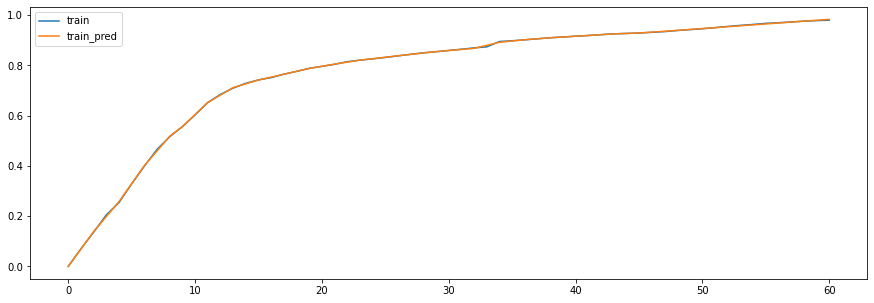

In [30]:
# Plot the training predictions
pd.concat([train['y'], train_predictions['yhat']], axis=1).plot(figsize=(15,5))
plt.legend(['train', 'train_pred'])

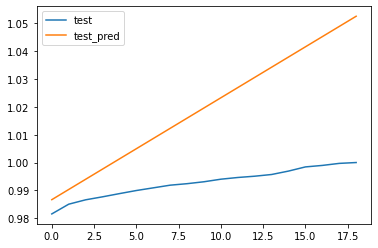

In [31]:
pd.concat([test.reset_index()['y'],test_predictions['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])

### Train RMSE: 0.0018848221440155263, Test RMSE: 0.030829773738268222

# Prophet - Multiple Regressor

In [52]:
df_scaled.head()

,Distributed,Distributed_Janssen,Distributed_Moderna,Distributed_Pfizer,Distributed_Unk_Manuf,Dist_Per_100K,Distributed_Per_100k_5Plus,Distributed_Per_100k_12Plus,Distributed_Per_100k_18Plus,Distributed_Per_100k_65Plus,...,Additional_Doses_Vax_Pct,Additional_Doses_18Plus_Vax_Pct,Additional_Doses_50Plus_Vax_Pct,Additional_Doses_65Plus_Vax_Pct,Additional_Doses_Moderna,Additional_Doses_Pfizer,Additional_Doses_Janssen,Additional_Doses_Unk_Manuf,holiday_season,vax_announcement
Date,,,,,,,,,,,,,,,,,,,,,
2021-11-03,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002677,0.0,0.0
2021-11-10,0.035505,0.083761,0.034580,0.045848,0.0,0.035776,0.035678,0.041371,0.048715,0.137336,...,0.070026,0.070491,0.089551,0.118364,0.075766,0.039331,0.085305,0.000000,1.0,0.0
2021-11-17,0.072682,0.164997,0.077333,0.080529,0.0,0.067730,0.066477,0.071859,0.080049,0.163318,...,0.135949,0.136967,0.169501,0.216584,0.147337,0.080079,0.164947,0.012586,0.0,1.0
2021-11-24,0.102544,0.261788,0.091649,0.117759,0.0,0.095375,0.093287,0.098441,0.107215,0.186691,...,0.204748,0.206337,0.250246,0.308549,0.224831,0.128386,0.248347,0.029076,1.0,0.0
2021-12-01,0.110295,0.300937,0.096530,0.126515,0.0,0.103134,0.100809,0.105900,0.114821,0.193132,...,0.254180,0.257007,0.304702,0.360192,0.277124,0.167467,0.307021,0.038226,0.0,1.0


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


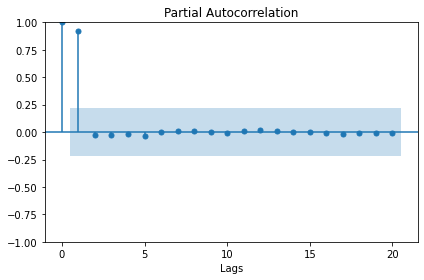

In [45]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(df_scaled[pred_var])
plt.xlabel('Lags')
plt.tight_layout()
plt.show() # to see if we need lag

In [68]:
# Adding lag of 1 to columns -> looking at PACF graph
def process(df, columns_to_exclude=['holiday_season', 'vax_announcement']):
    columns_to_lag = [col for col in df.columns if col not in columns_to_exclude]
    lag1df = df[columns_to_lag].shift(1)
    lag1df.columns = ['lag1_' + str(col) for col in lag1df.columns]
    df=df[['Additional_Doses_Vax_Pct', 'holiday_season', 'vax_announcement']].join(lag1df)
    return df.fillna(0) 
df = process(df_scaled)
df.reset_index(inplace=True)
df.head()

,Date,Additional_Doses_Vax_Pct,holiday_season,vax_announcement,lag1_Distributed,lag1_Distributed_Janssen,lag1_Distributed_Moderna,lag1_Distributed_Pfizer,lag1_Distributed_Unk_Manuf,lag1_Dist_Per_100K,...,lag1_Series_Complete_Pfizer_65Plus,lag1_Series_Complete_Unk_Manuf_65Plus,lag1_Additional_Doses_Vax_Pct,lag1_Additional_Doses_18Plus_Vax_Pct,lag1_Additional_Doses_50Plus_Vax_Pct,lag1_Additional_Doses_65Plus_Vax_Pct,lag1_Additional_Doses_Moderna,lag1_Additional_Doses_Pfizer,lag1_Additional_Doses_Janssen,lag1_Additional_Doses_Unk_Manuf
0,2021-11-03,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2021-11-10,0.070026,1.0,0.0,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002677
2,2021-11-17,0.135949,0.0,1.0,0.035505,0.083761,0.034580,0.045848,0.0,0.035776,...,0.034892,0.033225,0.070026,0.070491,0.089551,0.118364,0.075766,0.039331,0.085305,0.000000
3,2021-11-24,0.204748,1.0,0.0,0.072682,0.164997,0.077333,0.080529,0.0,0.067730,...,0.069056,0.061749,0.135949,0.136967,0.169501,0.216584,0.147337,0.080079,0.164947,0.012586
4,2021-12-01,0.254180,0.0,1.0,0.102544,0.261788,0.091649,0.117759,0.0,0.095375,...,0.055946,0.105722,0.204748,0.206337,0.250246,0.308549,0.224831,0.128386,0.248347,0.029076


In [69]:
# this removed the holiday season and vax_announcement, I will run a multiple prophet model and see if that changes 

In [70]:
df_multiple = df.rename(columns={'Date': 'ds', 'Additional_Doses_Vax_Pct': 'y'})

In [71]:
df_multiple.head(2)

,ds,y,holiday_season,vax_announcement,lag1_Distributed,lag1_Distributed_Janssen,lag1_Distributed_Moderna,lag1_Distributed_Pfizer,lag1_Distributed_Unk_Manuf,lag1_Dist_Per_100K,...,lag1_Series_Complete_Pfizer_65Plus,lag1_Series_Complete_Unk_Manuf_65Plus,lag1_Additional_Doses_Vax_Pct,lag1_Additional_Doses_18Plus_Vax_Pct,lag1_Additional_Doses_50Plus_Vax_Pct,lag1_Additional_Doses_65Plus_Vax_Pct,lag1_Additional_Doses_Moderna,lag1_Additional_Doses_Pfizer,lag1_Additional_Doses_Janssen,lag1_Additional_Doses_Unk_Manuf
0,2021-11-03,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,2021-11-10,0.070026,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002677


In [72]:
# Splitting data into Train and Test -> test is from start of 2023 and beyond

split_date = '2023-01-03'

train_multiple = df_multiple[df_multiple['ds'] < split_date]
test_multiple = df_multiple[df_multiple['ds'] >= split_date]
print(train_multiple.shape, test_multiple.shape)

(61, 63) (19, 63)


### Baseline Prophet Multiple Regressor Model

In [73]:
# Create a Prophet model
model = Prophet()
for col in train_multiple.columns:
    if col not in ['ds', 'y']:
        model.add_regressor(col)
        
# Fit the model on the training data
model.fit(train_multiple)

# Make predictions on the training set
train_predictions = model.predict(train_multiple)

# Make predictions on the test set
test_predictions = model.predict(test_multiple)

# Extract the actual and predicted values
train_actual = train_multiple['y']
test_actual = test_multiple['y']

train_pred = train_predictions['yhat']
test_pred = test_predictions['yhat']

# Calculate RMSE for training set
train_rmse = np.sqrt(mean_squared_error(train_actual, train_pred))

# Calculate RMSE for test set
test_rmse = np.sqrt(mean_squared_error(test_actual, test_pred))

print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")

19:52:44 - cmdstanpy - INFO - Chain [1] start processing
19:53:30 - cmdstanpy - INFO - Chain [1] done processing


Training RMSE: 4.790684770324318e-05
Testing RMSE: 4.939669250649658


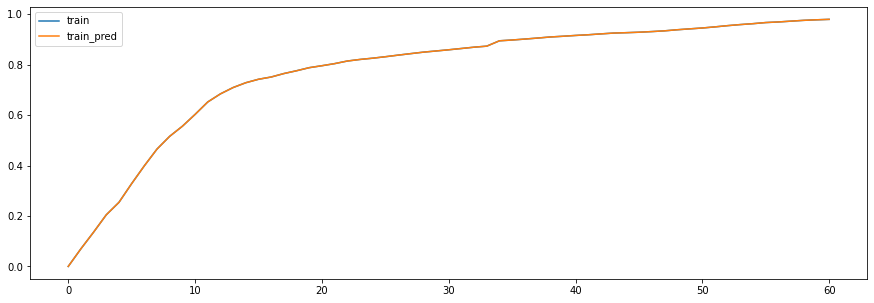

In [74]:
# Plot the training predictions
pd.concat([train_multiple['y'], train_predictions['yhat']], axis=1).plot(figsize=(15,5))
plt.legend(['train', 'train_pred'])

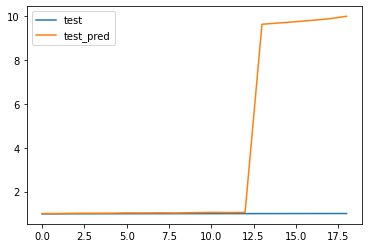

In [75]:
pd.concat([test_multiple.reset_index()['y'],test_predictions['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])

In [87]:
# big spike around test index - date 03/29/2023 
# want to see if cross validation will improve that

In [92]:
# seems to be overfitting the training data -> adjust changepoint_prior_scale/sesonality_prior_scale/holidays_prior_scale
# Create a Prophet model
model = Prophet(holidays_prior_scale = 0.01)
for col in train_multiple.columns:
    if col not in ['ds', 'y']:
        model.add_regressor(col)
        
# Fit the model on the training data
model.fit(train_multiple)

# Make predictions on the training set
train_predictions = model.predict(train_multiple)

# Make predictions on the test set
test_predictions = model.predict(test_multiple)

# Extract the actual and predicted values
train_actual = train_multiple['y']
test_actual = test_multiple['y']

train_pred = train_predictions['yhat']
test_pred = test_predictions['yhat']

# Calculate RMSE for training set
train_rmse = np.sqrt(mean_squared_error(train_actual, train_pred))

# Calculate RMSE for test set
test_rmse = np.sqrt(mean_squared_error(test_actual, test_pred))

print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")

20:17:40 - cmdstanpy - INFO - Chain [1] start processing
20:17:41 - cmdstanpy - INFO - Chain [1] done processing


Training RMSE: 0.0032010082641080895
Testing RMSE: 0.0037336008577581485


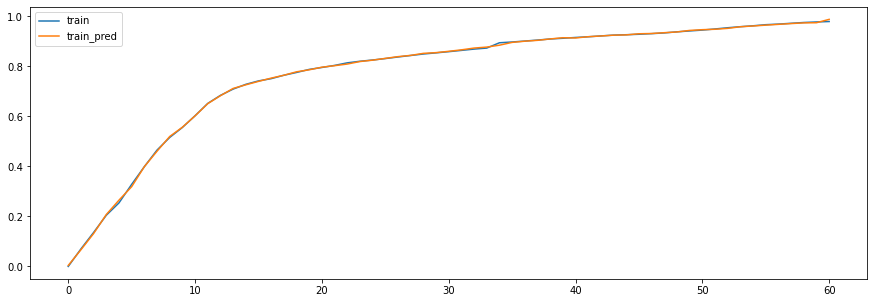

In [93]:
# Plot the training predictions
pd.concat([train_multiple['y'], train_predictions['yhat']], axis=1).plot(figsize=(15,5))
plt.legend(['train', 'train_pred'])

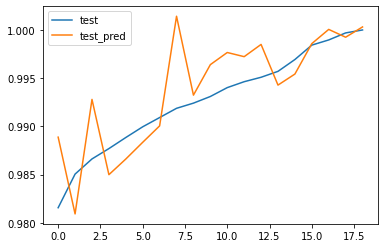

In [94]:
pd.concat([test_multiple.reset_index()['y'],test_predictions['yhat']], axis=1).plot( )
plt.legend(['test', 'test_pred'])

In [95]:
# tuning to holidays_prior_scale = 0.01 seems to avoid overfitting to train data

By setting holidays_prior_scale to 0.01, you are essentially downweighting the impact of holidays, which can be useful in scenarios where you want to reduce the influence of holidays on the overall trend and seasonality. This can be beneficial if you find that the model is overfitting to holiday-specific patterns or if holidays are not significant contributors to the overall behavior of the time series.

### Tuning Prophet Multiple -> Cross Validation

In [97]:
# random grid search to determine which initial, period, and horizon to use to minimize RMSE

from sklearn.model_selection import ParameterSampler

param_grid = {
    'initial': list(range(7, 245, 7)),  #1-25 weeks
    'period': [7, 14] ,  
    'horizon': [7, 14]  #1-25 weeks
}

n_iter = 10

best_rmse = float('inf')
best_params = None

for params in ParameterSampler(param_distributions=param_grid, n_iter=n_iter, random_state=42):
    model = Prophet(holidays_prior_scale = 0.01)
    for col in train_multiple.columns:
        if col not in ['ds', 'y']:
            model.add_regressor(col)   
    model.fit(train_multiple)
    horizon = f'{params["horizon"]} days'
    initial = f'{params["initial"]} days'
    period = f'{params["period"]} days'
    
    df_cv = cross_validation(model, horizon=horizon, initial=initial, period=period)

    metrics = performance_metrics(df_cv)
    rmse = metrics['rmse'].mean()
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

20:24:46 - cmdstanpy - INFO - Chain [1] start processing
20:24:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/28 [00:00<?, ?it/s]

20:24:47 - cmdstanpy - INFO - Chain [1] start processing
20:24:54 - cmdstanpy - INFO - Chain [1] done processing
20:24:54 - cmdstanpy - INFO - Chain [1] start processing
20:25:14 - cmdstanpy - INFO - Chain [1] done processing
20:25:14 - cmdstanpy - INFO - Chain [1] start processing
20:25:36 - cmdstanpy - INFO - Chain [1] done processing
20:25:36 - cmdstanpy - INFO - Chain [1] start processing
20:25:58 - cmdstanpy - INFO - Chain [1] done processing
20:25:58 - cmdstanpy - INFO - Chain [1] start processing
20:26:21 - cmdstanpy - INFO - Chain [1] done processing
20:26:22 - cmdstanpy - INFO - Chain [1] start processing
20:26:46 - cmdstanpy - INFO - Chain [1] done processing
20:26:46 - cmdstanpy - INFO - Chain [1] start processing
20:27:10 - cmdstanpy - INFO - Chain [1] done processing
20:27:10 - cmdstanpy - INFO - Chain [1] start processing
20:27:37 - cmdstanpy - INFO - Chain [1] done processing
20:27:37 - cmdstanpy - INFO - Chain [1] start processing
20:28:04 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/19 [00:00<?, ?it/s]

20:32:00 - cmdstanpy - INFO - Chain [1] start processing
20:32:31 - cmdstanpy - INFO - Chain [1] done processing
20:32:31 - cmdstanpy - INFO - Chain [1] start processing
20:33:02 - cmdstanpy - INFO - Chain [1] done processing
20:33:02 - cmdstanpy - INFO - Chain [1] start processing
20:33:35 - cmdstanpy - INFO - Chain [1] done processing
20:33:35 - cmdstanpy - INFO - Chain [1] start processing
20:34:10 - cmdstanpy - INFO - Chain [1] done processing
20:34:10 - cmdstanpy - INFO - Chain [1] start processing
20:34:46 - cmdstanpy - INFO - Chain [1] done processing
20:34:46 - cmdstanpy - INFO - Chain [1] start processing
20:35:23 - cmdstanpy - INFO - Chain [1] done processing
20:35:23 - cmdstanpy - INFO - Chain [1] start processing
20:35:23 - cmdstanpy - INFO - Chain [1] done processing
20:35:23 - cmdstanpy - INFO - Chain [1] start processing
20:35:24 - cmdstanpy - INFO - Chain [1] done processing
20:35:24 - cmdstanpy - INFO - Chain [1] start processing
20:35:24 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/29 [00:00<?, ?it/s]

20:35:32 - cmdstanpy - INFO - Chain [1] start processing
20:36:08 - cmdstanpy - INFO - Chain [1] done processing
20:36:08 - cmdstanpy - INFO - Chain [1] start processing
20:36:44 - cmdstanpy - INFO - Chain [1] done processing
20:36:44 - cmdstanpy - INFO - Chain [1] start processing
20:37:24 - cmdstanpy - INFO - Chain [1] done processing
20:37:24 - cmdstanpy - INFO - Chain [1] start processing
20:37:24 - cmdstanpy - INFO - Chain [1] done processing
20:37:24 - cmdstanpy - INFO - Chain [1] start processing
20:37:25 - cmdstanpy - INFO - Chain [1] done processing
20:37:25 - cmdstanpy - INFO - Chain [1] start processing
20:37:25 - cmdstanpy - INFO - Chain [1] done processing
20:37:25 - cmdstanpy - INFO - Chain [1] start processing
20:37:26 - cmdstanpy - INFO - Chain [1] done processing
20:37:26 - cmdstanpy - INFO - Chain [1] start processing
20:37:26 - cmdstanpy - INFO - Chain [1] done processing
20:37:26 - cmdstanpy - INFO - Chain [1] start processing
20:37:27 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/38 [00:00<?, ?it/s]

20:37:42 - cmdstanpy - INFO - Chain [1] start processing
20:38:10 - cmdstanpy - INFO - Chain [1] done processing
20:38:11 - cmdstanpy - INFO - Chain [1] start processing
20:38:39 - cmdstanpy - INFO - Chain [1] done processing
20:38:40 - cmdstanpy - INFO - Chain [1] start processing
20:39:10 - cmdstanpy - INFO - Chain [1] done processing
20:39:10 - cmdstanpy - INFO - Chain [1] start processing
20:39:40 - cmdstanpy - INFO - Chain [1] done processing
20:39:40 - cmdstanpy - INFO - Chain [1] start processing
20:40:12 - cmdstanpy - INFO - Chain [1] done processing
20:40:12 - cmdstanpy - INFO - Chain [1] start processing
20:40:44 - cmdstanpy - INFO - Chain [1] done processing
20:40:44 - cmdstanpy - INFO - Chain [1] start processing
20:41:17 - cmdstanpy - INFO - Chain [1] done processing
20:41:17 - cmdstanpy - INFO - Chain [1] start processing
20:41:51 - cmdstanpy - INFO - Chain [1] done processing
20:41:51 - cmdstanpy - INFO - Chain [1] start processing
20:42:25 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/28 [00:00<?, ?it/s]

20:44:28 - cmdstanpy - INFO - Chain [1] start processing
20:45:03 - cmdstanpy - INFO - Chain [1] done processing
20:45:03 - cmdstanpy - INFO - Chain [1] start processing
20:45:39 - cmdstanpy - INFO - Chain [1] done processing
20:45:39 - cmdstanpy - INFO - Chain [1] start processing
20:46:15 - cmdstanpy - INFO - Chain [1] done processing
20:46:15 - cmdstanpy - INFO - Chain [1] start processing
20:46:16 - cmdstanpy - INFO - Chain [1] done processing
20:46:16 - cmdstanpy - INFO - Chain [1] start processing
20:46:16 - cmdstanpy - INFO - Chain [1] done processing
20:46:16 - cmdstanpy - INFO - Chain [1] start processing
20:46:17 - cmdstanpy - INFO - Chain [1] done processing
20:46:17 - cmdstanpy - INFO - Chain [1] start processing
20:46:17 - cmdstanpy - INFO - Chain [1] done processing
20:46:17 - cmdstanpy - INFO - Chain [1] start processing
20:46:18 - cmdstanpy - INFO - Chain [1] done processing
20:46:18 - cmdstanpy - INFO - Chain [1] start processing
20:46:19 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/28 [00:00<?, ?it/s]

20:46:33 - cmdstanpy - INFO - Chain [1] start processing
20:47:09 - cmdstanpy - INFO - Chain [1] done processing
20:47:09 - cmdstanpy - INFO - Chain [1] start processing
20:47:46 - cmdstanpy - INFO - Chain [1] done processing
20:47:46 - cmdstanpy - INFO - Chain [1] start processing
20:47:46 - cmdstanpy - INFO - Chain [1] done processing
20:47:46 - cmdstanpy - INFO - Chain [1] start processing
20:47:47 - cmdstanpy - INFO - Chain [1] done processing
20:47:47 - cmdstanpy - INFO - Chain [1] start processing
20:47:47 - cmdstanpy - INFO - Chain [1] done processing
20:47:47 - cmdstanpy - INFO - Chain [1] start processing
20:47:48 - cmdstanpy - INFO - Chain [1] done processing
20:47:48 - cmdstanpy - INFO - Chain [1] start processing
20:47:48 - cmdstanpy - INFO - Chain [1] done processing
20:47:49 - cmdstanpy - INFO - Chain [1] start processing
20:47:49 - cmdstanpy - INFO - Chain [1] done processing
20:47:49 - cmdstanpy - INFO - Chain [1] start processing
20:47:50 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/53 [00:00<?, ?it/s]

20:48:04 - cmdstanpy - INFO - Chain [1] start processing
20:48:12 - cmdstanpy - INFO - Chain [1] done processing
20:48:12 - cmdstanpy - INFO - Chain [1] start processing
20:48:33 - cmdstanpy - INFO - Chain [1] done processing
20:48:33 - cmdstanpy - INFO - Chain [1] start processing
20:48:55 - cmdstanpy - INFO - Chain [1] done processing
20:48:55 - cmdstanpy - INFO - Chain [1] start processing
20:49:17 - cmdstanpy - INFO - Chain [1] done processing
20:49:17 - cmdstanpy - INFO - Chain [1] start processing
20:49:39 - cmdstanpy - INFO - Chain [1] done processing
20:49:39 - cmdstanpy - INFO - Chain [1] start processing
20:50:03 - cmdstanpy - INFO - Chain [1] done processing
20:50:03 - cmdstanpy - INFO - Chain [1] start processing
20:50:26 - cmdstanpy - INFO - Chain [1] done processing
20:50:26 - cmdstanpy - INFO - Chain [1] start processing
20:50:51 - cmdstanpy - INFO - Chain [1] done processing
20:50:51 - cmdstanpy - INFO - Chain [1] start processing
20:51:15 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/26 [00:00<?, ?it/s]

21:00:45 - cmdstanpy - INFO - Chain [1] start processing
21:01:06 - cmdstanpy - INFO - Chain [1] done processing
21:01:06 - cmdstanpy - INFO - Chain [1] start processing
21:01:28 - cmdstanpy - INFO - Chain [1] done processing
21:01:28 - cmdstanpy - INFO - Chain [1] start processing
21:01:51 - cmdstanpy - INFO - Chain [1] done processing
21:01:51 - cmdstanpy - INFO - Chain [1] start processing
21:02:16 - cmdstanpy - INFO - Chain [1] done processing
21:02:16 - cmdstanpy - INFO - Chain [1] start processing
21:02:41 - cmdstanpy - INFO - Chain [1] done processing
21:02:41 - cmdstanpy - INFO - Chain [1] start processing
21:03:23 - cmdstanpy - INFO - Chain [1] done processing
21:03:23 - cmdstanpy - INFO - Chain [1] start processing
21:04:05 - cmdstanpy - INFO - Chain [1] done processing
21:04:05 - cmdstanpy - INFO - Chain [1] start processing
21:04:47 - cmdstanpy - INFO - Chain [1] done processing
21:04:47 - cmdstanpy - INFO - Chain [1] start processing
21:05:29 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/25 [00:00<?, ?it/s]

21:08:34 - cmdstanpy - INFO - Chain [1] start processing
21:09:04 - cmdstanpy - INFO - Chain [1] done processing
21:09:05 - cmdstanpy - INFO - Chain [1] start processing
21:09:43 - cmdstanpy - INFO - Chain [1] done processing
21:09:43 - cmdstanpy - INFO - Chain [1] start processing
21:10:13 - cmdstanpy - INFO - Chain [1] done processing
21:10:13 - cmdstanpy - INFO - Chain [1] start processing
21:10:39 - cmdstanpy - INFO - Chain [1] done processing
21:10:40 - cmdstanpy - INFO - Chain [1] start processing
21:11:07 - cmdstanpy - INFO - Chain [1] done processing
21:11:07 - cmdstanpy - INFO - Chain [1] start processing
21:11:36 - cmdstanpy - INFO - Chain [1] done processing
21:11:36 - cmdstanpy - INFO - Chain [1] start processing
21:12:06 - cmdstanpy - INFO - Chain [1] done processing
21:12:06 - cmdstanpy - INFO - Chain [1] start processing
21:12:37 - cmdstanpy - INFO - Chain [1] done processing
21:12:37 - cmdstanpy - INFO - Chain [1] start processing
21:13:10 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/27 [00:00<?, ?it/s]

21:15:08 - cmdstanpy - INFO - Chain [1] start processing
21:15:45 - cmdstanpy - INFO - Chain [1] done processing
21:15:46 - cmdstanpy - INFO - Chain [1] start processing
21:15:46 - cmdstanpy - INFO - Chain [1] done processing
21:15:46 - cmdstanpy - INFO - Chain [1] start processing
21:15:46 - cmdstanpy - INFO - Chain [1] done processing
21:15:47 - cmdstanpy - INFO - Chain [1] start processing
21:15:47 - cmdstanpy - INFO - Chain [1] done processing
21:15:47 - cmdstanpy - INFO - Chain [1] start processing
21:15:48 - cmdstanpy - INFO - Chain [1] done processing
21:15:48 - cmdstanpy - INFO - Chain [1] start processing
21:15:48 - cmdstanpy - INFO - Chain [1] done processing
21:15:48 - cmdstanpy - INFO - Chain [1] start processing
21:15:49 - cmdstanpy - INFO - Chain [1] done processing
21:15:49 - cmdstanpy - INFO - Chain [1] start processing
21:15:50 - cmdstanpy - INFO - Chain [1] done processing
21:15:50 - cmdstanpy - INFO - Chain [1] start processing
21:15:50 - cmdstanpy - INFO - Chain [1]

Best Parameters: {'period': 7, 'initial': 154, 'horizon': 7}
Best RMSE: 0.004850656989504596


In [98]:
model = Prophet(holidays_prior_scale = 0.01)
for col in train_multiple.columns:
    if col not in ['ds', 'y']:
        model.add_regressor(col)   
model.fit(train_multiple)
cv_results = cross_validation(model, initial='154 days', period='7 days', horizon='7 days')
df_p = performance_metrics(cv_results)
df_p.head()

21:19:53 - cmdstanpy - INFO - Chain [1] start processing
21:19:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/38 [00:00<?, ?it/s]

21:19:54 - cmdstanpy - INFO - Chain [1] start processing
21:20:24 - cmdstanpy - INFO - Chain [1] done processing
21:20:24 - cmdstanpy - INFO - Chain [1] start processing
21:21:00 - cmdstanpy - INFO - Chain [1] done processing
21:21:00 - cmdstanpy - INFO - Chain [1] start processing
21:21:30 - cmdstanpy - INFO - Chain [1] done processing
21:21:31 - cmdstanpy - INFO - Chain [1] start processing
21:22:01 - cmdstanpy - INFO - Chain [1] done processing
21:22:01 - cmdstanpy - INFO - Chain [1] start processing
21:22:33 - cmdstanpy - INFO - Chain [1] done processing
21:22:33 - cmdstanpy - INFO - Chain [1] start processing
21:23:06 - cmdstanpy - INFO - Chain [1] done processing
21:23:06 - cmdstanpy - INFO - Chain [1] start processing
21:23:39 - cmdstanpy - INFO - Chain [1] done processing
21:23:40 - cmdstanpy - INFO - Chain [1] start processing
21:24:14 - cmdstanpy - INFO - Chain [1] done processing
21:24:14 - cmdstanpy - INFO - Chain [1] start processing
21:24:49 - cmdstanpy - INFO - Chain [1]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,7 days,0.000024,0.004851,0.003135,0.003421,0.002153,0.003419,0.657895


### Tuning Prophet Multiple -> Hyperparameters

In [ ]:
# Python
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    model = Prophet(**params)
    for col in train_multiple.columns:
        if col not in ['ds', 'y']:
            model.add_regressor(col)   
    model.fit(train_multiple)
    df_cv = cross_validation(model, parallel="processes", initial='154 days', period='7 days', horizon='7 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

21:32:17 - cmdstanpy - INFO - Chain [1] start processing
21:32:18 - cmdstanpy - INFO - Chain [1] done processing
21:32:20 - cmdstanpy - INFO - Chain [1] start processing
21:32:20 - cmdstanpy - INFO - Chain [1] start processing
21:32:20 - cmdstanpy - INFO - Chain [1] start processing
21:32:20 - cmdstanpy - INFO - Chain [1] start processing
21:32:20 - cmdstanpy - INFO - Chain [1] start processing
21:32:20 - cmdstanpy - INFO - Chain [1] start processing
21:32:20 - cmdstanpy - INFO - Chain [1] start processing
21:32:20 - cmdstanpy - INFO - Chain [1] start processing
21:32:21 - cmdstanpy - INFO - Chain [1] done processing
21:32:21 - cmdstanpy - INFO - Chain [1] done processing
21:32:21 - cmdstanpy - INFO - Chain [1] done processing
21:32:21 - cmdstanpy - INFO - Chain [1] done processing
21:32:21 - cmdstanpy - INFO - Chain [1] start processing
21:32:21 - cmdstanpy - INFO - Chain [1] start processing
21:32:21 - cmdstanpy - INFO - Chain [1] start processing
21:32:21 - cmdstanpy - INFO - Chain 

21:32:30 - cmdstanpy - INFO - Chain [1] start processing
21:32:30 - cmdstanpy - INFO - Chain [1] start processing
21:32:30 - cmdstanpy - INFO - Chain [1] done processing
21:32:30 - cmdstanpy - INFO - Chain [1] done processing
21:32:30 - cmdstanpy - INFO - Chain [1] done processing
21:32:31 - cmdstanpy - INFO - Chain [1] done processing
21:32:31 - cmdstanpy - INFO - Chain [1] done processing
21:32:32 - cmdstanpy - INFO - Chain [1] done processing
21:32:33 - cmdstanpy - INFO - Chain [1] done processing
21:32:33 - cmdstanpy - INFO - Chain [1] start processing
21:32:33 - cmdstanpy - INFO - Chain [1] done processing
21:32:36 - cmdstanpy - INFO - Chain [1] start processing
21:32:36 - cmdstanpy - INFO - Chain [1] start processing
21:32:36 - cmdstanpy - INFO - Chain [1] start processing
21:32:36 - cmdstanpy - INFO - Chain [1] start processing
21:32:36 - cmdstanpy - INFO - Chain [1] start processing
21:32:36 - cmdstanpy - INFO - Chain [1] start processing
21:32:36 - cmdstanpy - INFO - Chain [1]

21:32:45 - cmdstanpy - INFO - Chain [1] done processing
21:32:45 - cmdstanpy - INFO - Chain [1] done processing
21:32:45 - cmdstanpy - INFO - Chain [1] start processing
21:32:45 - cmdstanpy - INFO - Chain [1] start processing
21:32:45 - cmdstanpy - INFO - Chain [1] done processing
21:32:45 - cmdstanpy - INFO - Chain [1] done processing
21:32:45 - cmdstanpy - INFO - Chain [1] done processing
21:32:45 - cmdstanpy - INFO - Chain [1] start processing
21:32:45 - cmdstanpy - INFO - Chain [1] start processing
21:32:46 - cmdstanpy - INFO - Chain [1] done processing
21:32:46 - cmdstanpy - INFO - Chain [1] done processing
21:32:46 - cmdstanpy - INFO - Chain [1] done processing
21:32:46 - cmdstanpy - INFO - Chain [1] done processing
21:32:46 - cmdstanpy - INFO - Chain [1] done processing
21:32:48 - cmdstanpy - INFO - Chain [1] done processing
21:32:48 - cmdstanpy - INFO - Chain [1] done processing
21:32:48 - cmdstanpy - INFO - Chain [1] start processing
21:32:49 - cmdstanpy - INFO - Chain [1] don

21:33:00 - cmdstanpy - INFO - Chain [1] done processing
21:33:00 - cmdstanpy - INFO - Chain [1] done processing
21:33:00 - cmdstanpy - INFO - Chain [1] start processing
21:33:00 - cmdstanpy - INFO - Chain [1] done processing
21:33:00 - cmdstanpy - INFO - Chain [1] done processing
21:33:00 - cmdstanpy - INFO - Chain [1] start processing
21:33:00 - cmdstanpy - INFO - Chain [1] start processing
21:33:01 - cmdstanpy - INFO - Chain [1] start processing
21:33:01 - cmdstanpy - INFO - Chain [1] start processing
21:33:01 - cmdstanpy - INFO - Chain [1] done processing
21:33:01 - cmdstanpy - INFO - Chain [1] done processing
21:33:01 - cmdstanpy - INFO - Chain [1] done processing
21:33:01 - cmdstanpy - INFO - Chain [1] start processing
21:33:01 - cmdstanpy - INFO - Chain [1] start processing
21:33:01 - cmdstanpy - INFO - Chain [1] done processing
21:33:01 - cmdstanpy - INFO - Chain [1] start processing
21:33:01 - cmdstanpy - INFO - Chain [1] done processing
21:33:01 - cmdstanpy - INFO - Chain [1] 

21:33:15 - cmdstanpy - INFO - Chain [1] done processing
21:33:15 - cmdstanpy - INFO - Chain [1] done processing
21:33:15 - cmdstanpy - INFO - Chain [1] done processing
21:33:15 - cmdstanpy - INFO - Chain [1] start processing
21:33:15 - cmdstanpy - INFO - Chain [1] done processing
21:33:16 - cmdstanpy - INFO - Chain [1] start processing
21:33:16 - cmdstanpy - INFO - Chain [1] start processing
21:33:16 - cmdstanpy - INFO - Chain [1] done processing
21:33:16 - cmdstanpy - INFO - Chain [1] start processing
21:33:16 - cmdstanpy - INFO - Chain [1] start processing
21:33:16 - cmdstanpy - INFO - Chain [1] done processing
21:33:16 - cmdstanpy - INFO - Chain [1] done processing
21:33:16 - cmdstanpy - INFO - Chain [1] done processing
21:33:16 - cmdstanpy - INFO - Chain [1] done processing
21:33:16 - cmdstanpy - INFO - Chain [1] start processing
21:33:16 - cmdstanpy - INFO - Chain [1] done processing
21:33:16 - cmdstanpy - INFO - Chain [1] start processing
21:33:16 - cmdstanpy - INFO - Chain [1] s

21:33:30 - cmdstanpy - INFO - Chain [1] start processing
21:33:30 - cmdstanpy - INFO - Chain [1] done processing
21:33:30 - cmdstanpy - INFO - Chain [1] done processing
21:33:30 - cmdstanpy - INFO - Chain [1] done processing
21:33:30 - cmdstanpy - INFO - Chain [1] done processing
21:33:30 - cmdstanpy - INFO - Chain [1] start processing
21:33:30 - cmdstanpy - INFO - Chain [1] done processing
21:33:30 - cmdstanpy - INFO - Chain [1] done processing
21:33:30 - cmdstanpy - INFO - Chain [1] start processing
21:33:30 - cmdstanpy - INFO - Chain [1] done processing
21:33:30 - cmdstanpy - INFO - Chain [1] start processing
21:33:30 - cmdstanpy - INFO - Chain [1] start processing
21:33:30 - cmdstanpy - INFO - Chain [1] start processing
21:33:30 - cmdstanpy - INFO - Chain [1] start processing
21:33:30 - cmdstanpy - INFO - Chain [1] start processing
21:33:30 - cmdstanpy - INFO - Chain [1] done processing
21:33:30 - cmdstanpy - INFO - Chain [1] start processing
21:33:30 - cmdstanpy - INFO - Chain [1]

21:33:41 - cmdstanpy - INFO - Chain [1] done processing
21:33:41 - cmdstanpy - INFO - Chain [1] done processing
21:33:41 - cmdstanpy - INFO - Chain [1] done processing
21:33:41 - cmdstanpy - INFO - Chain [1] done processing
21:33:42 - cmdstanpy - INFO - Chain [1] start processing
21:33:42 - cmdstanpy - INFO - Chain [1] start processing
21:33:42 - cmdstanpy - INFO - Chain [1] done processing
21:33:42 - cmdstanpy - INFO - Chain [1] start processing
21:33:42 - cmdstanpy - INFO - Chain [1] done processing
21:33:42 - cmdstanpy - INFO - Chain [1] start processing
21:33:42 - cmdstanpy - INFO - Chain [1] start processing
21:33:42 - cmdstanpy - INFO - Chain [1] start processing
21:33:42 - cmdstanpy - INFO - Chain [1] done processing
21:33:42 - cmdstanpy - INFO - Chain [1] start processing
21:33:42 - cmdstanpy - INFO - Chain [1] done processing
21:33:42 - cmdstanpy - INFO - Chain [1] done processing
21:33:42 - cmdstanpy - INFO - Chain [1] done processing
21:33:42 - cmdstanpy - INFO - Chain [1] d

21:33:54 - cmdstanpy - INFO - Chain [1] done processing
21:33:54 - cmdstanpy - INFO - Chain [1] start processing
21:33:54 - cmdstanpy - INFO - Chain [1] done processing
21:33:54 - cmdstanpy - INFO - Chain [1] start processing
21:33:54 - cmdstanpy - INFO - Chain [1] start processing
21:33:54 - cmdstanpy - INFO - Chain [1] start processing
21:33:54 - cmdstanpy - INFO - Chain [1] start processing
21:33:54 - cmdstanpy - INFO - Chain [1] done processing
21:33:54 - cmdstanpy - INFO - Chain [1] done processing
21:33:54 - cmdstanpy - INFO - Chain [1] done processing
21:33:54 - cmdstanpy - INFO - Chain [1] done processing
21:33:54 - cmdstanpy - INFO - Chain [1] start processing
21:33:54 - cmdstanpy - INFO - Chain [1] start processing
21:33:54 - cmdstanpy - INFO - Chain [1] done processing
21:33:54 - cmdstanpy - INFO - Chain [1] start processing
21:33:54 - cmdstanpy - INFO - Chain [1] start processing
21:33:54 - cmdstanpy - INFO - Chain [1] done processing
21:33:54 - cmdstanpy - INFO - Chain [1]

21:34:06 - cmdstanpy - INFO - Chain [1] done processing
21:34:06 - cmdstanpy - INFO - Chain [1] done processing
21:34:06 - cmdstanpy - INFO - Chain [1] done processing
21:34:06 - cmdstanpy - INFO - Chain [1] start processing
21:34:06 - cmdstanpy - INFO - Chain [1] start processing
21:34:06 - cmdstanpy - INFO - Chain [1] done processing
21:34:06 - cmdstanpy - INFO - Chain [1] start processing
21:34:06 - cmdstanpy - INFO - Chain [1] start processing
21:34:06 - cmdstanpy - INFO - Chain [1] done processing
21:34:06 - cmdstanpy - INFO - Chain [1] done processing
21:34:06 - cmdstanpy - INFO - Chain [1] done processing
21:34:06 - cmdstanpy - INFO - Chain [1] start processing
21:34:06 - cmdstanpy - INFO - Chain [1] done processing
21:34:06 - cmdstanpy - INFO - Chain [1] start processing
21:34:06 - cmdstanpy - INFO - Chain [1] start processing
21:34:06 - cmdstanpy - INFO - Chain [1] start processing
21:34:06 - cmdstanpy - INFO - Chain [1] start processing
21:34:06 - cmdstanpy - INFO - Chain [1]

21:35:53 - cmdstanpy - INFO - Chain [1] start processing
21:35:54 - cmdstanpy - INFO - Chain [1] done processing
21:35:56 - cmdstanpy - INFO - Chain [1] start processing
21:35:56 - cmdstanpy - INFO - Chain [1] start processing
21:35:56 - cmdstanpy - INFO - Chain [1] start processing
21:35:56 - cmdstanpy - INFO - Chain [1] start processing
21:35:56 - cmdstanpy - INFO - Chain [1] start processing
21:35:56 - cmdstanpy - INFO - Chain [1] start processing
21:35:56 - cmdstanpy - INFO - Chain [1] start processing
21:35:56 - cmdstanpy - INFO - Chain [1] start processing
21:35:56 - cmdstanpy - INFO - Chain [1] done processing
21:35:57 - cmdstanpy - INFO - Chain [1] start processing
21:36:33 - cmdstanpy - INFO - Chain [1] done processing
21:36:33 - cmdstanpy - INFO - Chain [1] start processing
21:36:33 - cmdstanpy - INFO - Chain [1] done processing
21:36:34 - cmdstanpy - INFO - Chain [1] start processing
21:36:35 - cmdstanpy - INFO - Chain [1] done processing
21:36:35 - cmdstanpy - INFO - Chain 

21:38:41 - cmdstanpy - INFO - Chain [1] start processing
21:38:41 - cmdstanpy - INFO - Chain [1] done processing
21:38:41 - cmdstanpy - INFO - Chain [1] done processing
21:38:41 - cmdstanpy - INFO - Chain [1] start processing
21:38:42 - cmdstanpy - INFO - Chain [1] done processing
21:38:43 - cmdstanpy - INFO - Chain [1] done processing
21:38:44 - cmdstanpy - INFO - Chain [1] done processing
21:38:51 - cmdstanpy - INFO - Chain [1] done processing
21:38:53 - cmdstanpy - INFO - Chain [1] done processing
21:38:58 - cmdstanpy - INFO - Chain [1] done processing
21:38:59 - cmdstanpy - INFO - Chain [1] done processing
21:38:59 - cmdstanpy - INFO - Chain [1] start processing
21:38:59 - cmdstanpy - INFO - Chain [1] done processing
21:39:02 - cmdstanpy - INFO - Chain [1] start processing
21:39:02 - cmdstanpy - INFO - Chain [1] start processing
21:39:02 - cmdstanpy - INFO - Chain [1] start processing
21:39:02 - cmdstanpy - INFO - Chain [1] start processing
21:39:02 - cmdstanpy - INFO - Chain [1] s

21:41:13 - cmdstanpy - INFO - Chain [1] start processing
21:41:13 - cmdstanpy - INFO - Chain [1] done processing
21:41:13 - cmdstanpy - INFO - Chain [1] done processing
21:41:13 - cmdstanpy - INFO - Chain [1] start processing
21:41:14 - cmdstanpy - INFO - Chain [1] start processing
21:41:47 - cmdstanpy - INFO - Chain [1] done processing
21:41:47 - cmdstanpy - INFO - Chain [1] start processing
21:41:48 - cmdstanpy - INFO - Chain [1] done processing
21:41:48 - cmdstanpy - INFO - Chain [1] start processing
21:41:48 - cmdstanpy - INFO - Chain [1] done processing
21:41:48 - cmdstanpy - INFO - Chain [1] start processing
21:41:49 - cmdstanpy - INFO - Chain [1] done processing
21:41:49 - cmdstanpy - INFO - Chain [1] start processing
21:41:49 - cmdstanpy - INFO - Chain [1] done processing
21:41:49 - cmdstanpy - INFO - Chain [1] done processing
21:41:51 - cmdstanpy - INFO - Chain [1] done processing
21:41:51 - cmdstanpy - INFO - Chain [1] done processing
21:41:58 - cmdstanpy - INFO - Chain [1] d

21:44:20 - cmdstanpy - INFO - Chain [1] done processing
21:44:20 - cmdstanpy - INFO - Chain [1] done processing
21:44:20 - cmdstanpy - INFO - Chain [1] start processing
21:44:20 - cmdstanpy - INFO - Chain [1] start processing
21:44:21 - cmdstanpy - INFO - Chain [1] done processing
21:44:21 - cmdstanpy - INFO - Chain [1] start processing
21:44:21 - cmdstanpy - INFO - Chain [1] done processing
21:44:21 - cmdstanpy - INFO - Chain [1] start processing
21:44:21 - cmdstanpy - INFO - Chain [1] done processing
21:44:22 - cmdstanpy - INFO - Chain [1] start processing
21:44:22 - cmdstanpy - INFO - Chain [1] done processing
21:44:22 - cmdstanpy - INFO - Chain [1] start processing
21:44:22 - cmdstanpy - INFO - Chain [1] done processing
21:44:22 - cmdstanpy - INFO - Chain [1] start processing
21:44:23 - cmdstanpy - INFO - Chain [1] done processing
21:44:23 - cmdstanpy - INFO - Chain [1] start processing
21:44:56 - cmdstanpy - INFO - Chain [1] done processing
21:44:56 - cmdstanpy - INFO - Chain [1] 

21:47:30 - cmdstanpy - INFO - Chain [1] done processing
21:47:30 - cmdstanpy - INFO - Chain [1] start processing
21:47:30 - cmdstanpy - INFO - Chain [1] done processing
21:47:30 - cmdstanpy - INFO - Chain [1] done processing
21:47:30 - cmdstanpy - INFO - Chain [1] start processing
21:47:30 - cmdstanpy - INFO - Chain [1] start processing
21:47:30 - cmdstanpy - INFO - Chain [1] done processing
21:47:30 - cmdstanpy - INFO - Chain [1] start processing
21:47:30 - cmdstanpy - INFO - Chain [1] done processing
21:47:31 - cmdstanpy - INFO - Chain [1] start processing
21:47:31 - cmdstanpy - INFO - Chain [1] done processing
21:47:31 - cmdstanpy - INFO - Chain [1] start processing
21:47:31 - cmdstanpy - INFO - Chain [1] done processing
21:47:31 - cmdstanpy - INFO - Chain [1] start processing
21:47:32 - cmdstanpy - INFO - Chain [1] done processing
21:47:32 - cmdstanpy - INFO - Chain [1] done processing
21:47:32 - cmdstanpy - INFO - Chain [1] start processing
21:47:32 - cmdstanpy - INFO - Chain [1] 

21:50:43 - cmdstanpy - INFO - Chain [1] done processing
21:50:43 - cmdstanpy - INFO - Chain [1] done processing
21:50:43 - cmdstanpy - INFO - Chain [1] done processing
21:50:43 - cmdstanpy - INFO - Chain [1] start processing
21:50:43 - cmdstanpy - INFO - Chain [1] start processing
21:50:43 - cmdstanpy - INFO - Chain [1] start processing
21:50:44 - cmdstanpy - INFO - Chain [1] done processing
21:50:44 - cmdstanpy - INFO - Chain [1] done processing
21:50:44 - cmdstanpy - INFO - Chain [1] start processing
21:50:44 - cmdstanpy - INFO - Chain [1] done processing
21:50:44 - cmdstanpy - INFO - Chain [1] done processing
21:50:44 - cmdstanpy - INFO - Chain [1] start processing
21:50:44 - cmdstanpy - INFO - Chain [1] start processing
21:50:44 - cmdstanpy - INFO - Chain [1] start processing
21:50:45 - cmdstanpy - INFO - Chain [1] done processing
21:50:45 - cmdstanpy - INFO - Chain [1] start processing
21:50:45 - cmdstanpy - INFO - Chain [1] done processing
21:50:45 - cmdstanpy - INFO - Chain [1] 

In [ ]:
best_params = all_params[np.argmin(rmses)]
print(best_params)